# Preamble

In [12]:
# generic preamble
import sys,os

gd_path = '/home/dodd/google-drive'

#github_dir = "C:/Users/Lab/Lab Software/GitHub/experiment_control"
github_dir = '/home/dodd/github/experiment_control'
chi2_wg_dir = os.path.join(gd_path,'notebooks/IMEC_chi2_wg_experiments')

#default_data_dir = 'C:/Users/Lab/Google Drive/data/'
#default_data_dir = '/Users/doddgray/Google Drive/data'
default_data_dir = os.path.join(gd_path,'data')

# add my directories
my_dirs = [github_dir,chi2_wg_dir]
for dd in my_dirs:
    if dd not in sys.path:
        sys.path.append(dd)

# import my stuff        
from general_imports import *
from plotting_imports import *

%matplotlib notebook
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}

#plt.rcParams.update(rcParamsDefault)
plt.rcParams.update(my_default_plot_params)
import warnings
warnings.filterwarnings('ignore') # set back to 'default' to see warnings again.
#warnings.filterwarnings('default')
colors = ['r','b','g','m','c','k','orange','purple']


## convenience functions for printing variable names and values together
def namestr(obj, namespace=globals()):
    return [name for name in namespace if namespace[name] is obj][0]

def printval(x,w=4,p=1,form='f'):
    x_units = None
    try:
        x_units = str(x.unit)
        x = x.m
    except:
        pass
    if x_units:
        print(namestr(x)+ f': {x:{w}.{p}{form}} ' + x_units)
    else:
        print(namestr(x)+ f': {x:{w}.{p}{form}}')

def printspan(x,w=4,p=1,form='f'):
    x_units = None
    try:
        x_units = str(x.unit)
        x = x.m
    except:
        pass
    if x_units:
        print('max ' + namestr(x) + f': {x.max():{w}.{p}{form}} ' + x_units)
        print('min ' + namestr(x)+ f': {x.min():{w}.{p}{form}} ' + x_units)
    else:
        print('max ' + namestr(x)+ f': {x.max():{w}.{p}{form}}')
        print('min ' + namestr(x)+ f': {x.min():{w}.{p}{form}}')

π = np.pi
ϵ0 = u.electric_constant


# Function Definitions

In [2]:
# data load functions
from glob import glob
from os import path
import os, sys
import pickle
from datetime import datetime
from time import sleep
from pathlib import Path
from scipy.interpolate import interp2d
from matplotlib.colors import Normalize
from instrumental import instrument, Q_, u
import numpy as np
import os, sys
import pickle
import matplotlib.pyplot as plt
import  matplotlib.cm as cm
from matplotlib.colors import Normalize
from datetime import datetime
from time import sleep
from pathlib import Path
import h5py
import time

colors = ['r','b','g','m','c','k','orange','purple']

def time_array(ds):
   return Q_(np.linspace(ds.attrs['t_min'],ds.attrs['t_max'],ds.attrs['length']),ds.attrs['t_units'])

def load_shg_wavelength_sweep(name='',data_dir=default_data_dir,verbose=False,
                     fpath=None,metadata=False,exact_name=False):
    if fpath:
        if verbose:
            print_statusline('Loading data from file: ' + path.basename(path.normpath(fpath)))
        data_npz = np.load(Path(fpath))
    else:
        file_list =  glob(path.normpath(data_dir)+path.normpath('/'+ 'SHG_wavelength_sweep_' + name + '*'))
        latest_file = max(file_list,key=path.getctime)
        if verbose:
            print_statusline('Loading ' + name +' data from file: ' + path.basename(path.normpath(latest_file)))
        data_npz = np.load(latest_file)
    lm_meas = data_npz['lm_meas'] * u.nm
    V_R = data_npz['V_R'] * u.volt
    theta = data_npz['theta'] * u.degree
    try:
        V_P_24_trans = data_npz['V_P_24_trans'] * u.volt
        V_P_24_ref = data_npz['V_P_24_ref'] * u.volt
        ds = {'lm_meas':lm_meas,
                'V_P_24_trans':V_P_24_trans,
                'V_P_24_ref':V_P_24_ref,
                'V_R':V_R,
                'theta':theta}
    except:
        ds = {'lm_meas':lm_meas,
                'V_R':V_R,
                'theta':theta}
    return ds


def load_SHG_V_wavelength_sweep(name='',data_dir=default_data_dir,verbose=False,set_dir=None,
                                metadata=False,exact_name=False):
    if set_dir:
        if verbose:
            print_statusline('Loading data from dir: ' + path.basename(path.normpath(set_dir)))
    else:
        file_list =  glob(path.normpath(data_dir)+path.normpath('/'+ 'SHG_V_wavelength_sweep_' + name + '*'))
        set_dir = path.normpath(max(file_list,key=path.getctime))
        if verbose:
            print_statusline('Loading data from dir: ' + path.basename(set_dir))
    sweep_file_list =  glob(path.normpath(set_dir)+path.normpath('/'+ 'sweep_data' + '*'))
    latest_sweep_file = path.normpath(max(sweep_file_list,key=path.getctime))
    with open(latest_sweep_file, "rb" ) as f:
        ds = pickle.load(f)
    for Vind,VV in enumerate(ds['V']):
        V_dir = path.normpath(path.join(set_dir,f'{VV.m:3.2f}V'))
        V_ds = load_shg_wavelength_sweep(fpath=path.join(V_dir,f'{VV.m:3.2f}V.npz'))
        if Vind==0:
            n_lm = V_ds['lm_meas'].shape[0]
            n_pts_per_setpoint = V_ds['lm_meas'].shape[1]
            lm_meas = np.zeros((n_lm,n_pts_per_setpoint,len(ds['V']))) * u.nm
            V_R = np.zeros((n_lm,n_pts_per_setpoint,len(ds['V']))) * u.volt
            V_P_24_ref = np.zeros((n_lm,n_pts_per_setpoint,len(ds['V']))) * u.volt
            theta = np.zeros((n_lm,n_pts_per_setpoint,len(ds['V']))) * u.degree
        lm_meas[:,:,Vind] = V_ds['lm_meas']
        V_R[:,:,Vind] = V_ds['V_R']
        theta[:,:,Vind] = V_ds['theta']
        V_P_24_ref[:,:,Vind] = V_ds['V_P_24_ref']
    ds['lm_meas'] = lm_meas
    ds['V_R'] = V_R
    ds['V_P_24_ref'] = V_P_24_ref
    ds['theta'] = theta
    return ds

In [3]:
# Chris' model functions for linear cavity resonance

# added imports 
from scipy.io import loadmat
from scipy.interpolate import interp2d

from numpy import sqrt,exp,array,newaxis,ones,zeros,linspace

# Functions for calculating resonances

def make_equations(kappa_1, kappa_2, n_eff, L, k, l):
    N = len(L)
    N_equations = zeros((N, 5, 5), dtype = complex)
    for i in range(N):
        L_i = L[i]
        equations  = array([[t_1, -1, 0, 0, c_1],
                           [0, t_2*exp(1.j*n_eff*L_i*k), -1, c_2, 0],
                           [c_1*exp(1.j*n_eff*l/2.*k), 0, 0, -1, t_1*exp(1.j*n_eff*l/2.*k)],
                           [0, c_2*exp(1.j*n_eff*(L_i+l/2.)*k), 0, t_2*exp(1.j*n_eff*l/2.*k), -1],
                           [1, 0, 0, 0, 0]])
        N_equations[i,:,:] = equations
    return N_equations

def solve_system(kappa_1, kappa_2, n_eff, L, k, l, E_0 = 1.):
    t_1 = sqrt(1.-kappa_1**2)
    t_2 = sqrt(1.-kappa_2**2)
    c_1 = 1.j*kappa_1
    c_2 = 1.j*kappa_2

    N_equations = make_equations(kappa_1, kappa_2, n_eff, L, k, l)

    constants = array([0,0,0,0,E_0]).T
    solution = np.linalg.solve(N_equations, constants)
    return solution

def get_E_with_loss(kappa_1, kappa_2, n_eff, L, k, l, alpha_c=0, alpha_u=0, E0 = 1, return_z=False):
    n_c = n_eff
    n_u = n_eff
    t1 = sqrt(1.-kappa_1**2)
    t2 = sqrt(1.-kappa_2**2)
    c1 = 1.j*kappa_1
    c2 = 1.j*kappa_2
    N_L = len(L)
    N_k = len(k)
    N_l = len(l)

    L = Q_(swapaxes(L[:, newaxis, newaxis]*ones((N_l, N_k)), 0, 2), L.units)
    k = k[:, newaxis, newaxis]*ones((N_l, N_L))
    l = Q_(swapaxes(l[:, newaxis, newaxis]*ones((N_k, N_L)), 0,1), l.units)
    wavelength = 2*np.pi/k

    numerator = c1*t2*(1.-alpha_c)**2*exp(1.j*n_c*l*k)+c2*t1*(1.-alpha_u)*(1.-alpha_c)*exp(1.j*(n_u*L+n_c*l/2.)*k)
    z = t1*t2*(1.-alpha_c)**2*exp(1.j*n_c*l*k) + c1*c2*(1.-alpha_u)*(1.-alpha_c)*exp(1.j*(n_u*L+n_c*l/2.)*k)
    denominator = 1. - z
    E_ring_2 = numerator/denominator*E0
    E_ring_1 = (1.-alpha_c)*exp(1.j*n_c*l/2.*k)*(c1*E0 + t1*E_ring_2)
    E_cavity = t1*E0 + c1*E_ring_2
    E_out = c2*E_ring_1 + t2*(1.-alpha_u)*E_cavity*exp(1.j*n_u*L*k)
    P_ring_2 = abs(E_ring_2)**2
    P_ring_1 = abs(E_ring_1)**2
    P_cavity = abs(E_cavity)**2
    P_out = abs(E_out)**2
    P0 = abs(E0)**2
    if return_z:
        return P_ring_2, P_ring_1, P_cavity, P_out, P0, L, l, wavelength, z
    else:
        return P_ring_2, P_ring_1, P_cavity, P_out, P0, L, l, wavelength


def get_E(kappa_1, kappa_2, n_eff, L, k, l, E0 = 1):
    t1 = sqrt(1.-kappa_1**2)
    t2 = sqrt(1.-kappa_2**2)
    c1 = 1.j*kappa_1
    c2 = 1.j*kappa_2
    N_L = len(L)
    N_k = len(k)
    N_l = len(l)

    L = Q_(swapaxes(L[:, newaxis, newaxis]*ones((N_l, N_k)), 0, 2), L.units)
    k = k[:, newaxis, newaxis]*ones((N_l, N_L))
    l = Q_(swapaxes(l[:, newaxis, newaxis]*ones((N_k, N_L)), 0,1), l.units)
    wavelength = 2*np.pi/k

    numerator = c1*t2*exp(1.j*n_eff*l*k)+c2*t1*exp(1.j*n_eff*(L+l/2.)*k)
    denominator = 1. - t1*t2*exp(1.j*n_eff*l*k) - c1*c2*exp(1.j*n_eff*(L+l/2.)*k)
    E_ring_2 = numerator/denominator*E0
    E_ring_1 = t1*E_ring_2*exp(1.j*n_eff*l/2.*k) + c1*E0*exp(1.j*n_eff*l/2.*k)
    E_cavity = t1*E0 + c1*E_ring_2
    E_out = c2*E_ring_1 + t2*E_cavity*exp(1.j*n_eff*L*k)
    P_ring_2 = abs(E_ring_2)**2
    P_ring_1 = abs(E_ring_1)**2
    P_cavity = abs(E_cavity)**2
    P_out = abs(E_out)**2
    P0 = abs(E0)**2
    return P_ring_2, P_ring_1, P_cavity, P_out, P0, L, l, wavelength

def get_P_from_phi(kappa_1, kappa_2, alpha_c=0, alpha_u=0, phi_1=0, phi_2=np.pi, get_cavity=False):
    """ Returns P_ring_2, unless get_cavity is True, in which case it returns P_cavity"""
    t1 = sqrt(1.-kappa_1**2)
    t2 = sqrt(1.-kappa_2**2)
    c1 = 1.j*kappa_1
    c2 = 1.j*kappa_2
    numerator = c1*t2*(1.-alpha_c)**2*exp(1.j*phi_1)+c2*t1*(1.-alpha_u)*(1.-alpha_c)*exp(1.j*phi_2)
    denominator = 1. - t1*t2*(1.-alpha_c)**2*exp(1.j*phi_1) - c1*c2*(1.-alpha_u)*(1.-alpha_c)*exp(1.j*phi_2)
    E_ring_2 = numerator/denominator
    if get_cavity:
        E_ring_1 = (1.-alpha_c)*exp(1.j*phi_2/2.)*(c1 + t1*E_ring_2)
        E_cavity = t1 + c1*E_ring_2
        return abs(E_cavity**2)
    else:
        return abs(E_ring_2**2)

def get_max_P(kappa_1, kappa_2, alpha_c=0, alpha_u=0, get_cavity=False, N_phi=100, N_cuts=10, delta_phi_scale=1.):
    phi_scale = ((1.-kappa_1**2)/kappa_1**2 + (1.-kappa_2**2)/kappa_2**2)/2.
    phi_scale_range = linspace(-1, 1, N_cuts)*delta_phi_scale*(phi_scale - 1.) + phi_scale
    phi_1 = linspace(-np.pi/2, np.pi/2, N_phi)
    P_mat = zeros((N_phi, N_cuts))
    for i in range(N_cuts):
        phi_2_i = -phi_1*phi_scale_range[i] + np.pi
        P_mat[:,i] = get_P_from_phi(kappa_1, kappa_2, alpha_c, alpha_u, phi_1, phi_2_i, get_cavity)
    return amax(P_mat, 1), phi_1

def get_lossy_resonance(kappa_1, kappa_2, alpha_c=0, alpha_u=0, x0=array([0, np.pi]), delta_x0=0.01):
    x0 = x0 + array([1,-1])*delta_x0
    fun = lambda phi: -get_P_from_phi(kappa_1, kappa_2, alpha_c, alpha_u, phi[0], phi[1])
    phi_resonance = minimize(fun, x0, bounds=[(0, np.pi/2), (np.pi/2, np.pi)])
    return get_P_from_phi(kappa_1, kappa_2, alpha_c, alpha_u, *phi_resonance.x, get_cavity=True), phi_resonance

def E_resonance(kappa_1, kappa_2, E0 = 1):
    t1 = sqrt(1.-kappa_1**2)
    t2 = sqrt(1.-kappa_2**2)
    c1 = 1.j*kappa_1
    c2 = 1.j*kappa_2

    numerator = c1*t2-c2*t1
    denominator = 1. - t1*t2 + c1*c2
    E_ring_2 = numerator/denominator*E0

    E_ring_1 = t1*E_ring_2 + c1*E0
    E_cavity = t1*E0 + c1*E_ring_2
    E_out = c2*E_ring_1 + t2*E_cavity
    P_ring_2 = abs(E_ring_2)**2
    P_ring_1 = abs(E_ring_1)**2
    P_cavity = abs(E_cavity)**2
    P_out = abs(E_out)**2
    P0 = abs(E0)**2
    return P_ring_2, P_ring_1, P_cavity, P_out, P0

def get_E_ring(kappa_1, kappa_2, n_eff, k, l, E0 = 1):
    t1 = sqrt(1.-kappa_1**2)
    t2 = sqrt(1.-kappa_2**2)
    c1 = 1.j*kappa_1
    c2 = 1.j*kappa_2
    N_k = len(k)
    N_l = len(l)
    k = k[:, newaxis]*ones((N_l))
    l = Q_(swapaxes(l[:, newaxis]*ones((N_k)), 0,1), l.units)
    wavelength = 2*np.pi/k

    E_circ = c1/(1.-t1*t2*exp(1.j*n_eff*l*k))*E0
    P_circ = abs(E_circ**2)
    P0 = abs(E0)**2
    return P_circ, P0, l, wavelength

def E_loss_resonance(kappa_1, kappa_2, alpha_c, alpha_u, E0 = 1):
    kappa_1, kappa_2, alpha_c, alpha_u = convert_to_matrices(kappa_1, kappa_2, alpha_c, alpha_u)
    t1 = sqrt(1.-kappa_1**2)
    t2 = sqrt(1.-kappa_2**2)
    c1 = 1.j*kappa_1
    c2 = 1.j*kappa_2

    numerator = c1*t2*(1-alpha_c)**2-c2*t1*(1-alpha_c)*(1-alpha_u)
    denominator = 1. - t1*t2*(1-alpha_c)**2 + c1*c2*(1-alpha_c)*(1-alpha_u)
    E_ring_2 = numerator/denominator*E0

    E_ring_1 = t1*(1-alpha_c)*E_ring_2 + c1*(1-alpha_c)*E0
    E_cavity = t1*E0 + c1*E_ring_2
    E_out = c2*E_ring_1 + t2*(1-alpha_u)*E_cavity
    P_ring_2 = abs(E_ring_2)**2
    P_ring_1 = abs(E_ring_1)**2
    P_cavity = abs(E_cavity)**2
    P_out = abs(E_out)**2
    P0 = abs(E0)**2
    return P_ring_2, P_ring_1, P_cavity, P_out, P0

def dB_to_fractional_loss(dB_loss):
    return 1. - 10**(-dB_loss/10.)

def convert_to_array_if_not(input_list):
    for input_i, i in zip(input_list, range(len(input_list))):
        if not isinstance(input_i, ndarray):
            input_list[i] = array([input_i])
    if len(input_list)==1:
        return input_list[0]
    return input_list

def convert_to_matrices(kappa_1, kappa_2, alpha_c, alpha_u=None):
    kappa_1, kappa_2, alpha_c = convert_to_array_if_not([kappa_1, kappa_2, alpha_c])
    N_kappa_2 = len(kappa_2)
    N_kappa_1 = len(kappa_1)
    N_alpha_c = len(alpha_c)

    alpha_c = swapaxes(alpha_c[:, newaxis, newaxis]*ones((N_kappa_2, N_kappa_1)), 0, 2)
    kappa_1 = kappa_1[:, newaxis, newaxis]*ones((N_kappa_2, N_alpha_c))
    kappa_2 = swapaxes(kappa_2[:, newaxis, newaxis]*ones((N_kappa_1, N_alpha_c)), 0,1)

    if alpha_u is not None:
        alpha_u = convert_to_array_if_not([alpha_u,])
        N_alpha_u = len(alpha_u)
        alpha_u = swapaxes(alpha_u[:, newaxis, newaxis, newaxis]*ones((N_kappa_2, N_alpha_c, N_kappa_1)), 0, 3)
        alpha_c = alpha_c[:,:,:,newaxis]*ones(N_alpha_u)
        kappa_1 = kappa_1[:,:,:,newaxis]*ones(N_alpha_u)
        kappa_2 = kappa_2[:,:,:,newaxis]*ones(N_alpha_u)
        return kappa_1, kappa_2, alpha_c, alpha_u
    return kappa_1, kappa_2, alpha_c


In [4]:
# linear transmission sweep import and processing functions

def import_linear_transmission_data(fpath,nt_skip=10,V_24_trans_offset=288*u.mV,λ_min=2250*u.nm,λ_max=2550*u.nm):
    ds = {}
    with h5py.File(fpath,'r') as f:
        λ = f['lm'][...] * u.nm
        t = time_array(f['12_off/V_24_trans'])[::nt_skip]
        V_trans_24 = f['12_off/V_24_trans'][::nt_skip,:,:]
        V_ref_24 = f['12_off/V_24_ref'][::nt_skip,:,:]
    sort_inds = np.argsort(λ.reshape((λ.size,)))
    # collapse 2D (stepper+pzt) IPG scan into 1D by sorting all data using Bristol 621's measured wavelength
    λ_sort = λ.ravel()[sort_inds]
    V_trans_24_sort = V_trans_24.reshape((V_trans_24.shape[0],λ.size))[:,sort_inds]
    V_ref_24_sort = V_ref_24.reshape((V_ref_24.shape[0],λ.size))[:,sort_inds]
    # get rid of all data with wavelengths outside specified range. 
    # this is primarily for when the Bristol signal was too low to measure the wavelength
    mask = (λ_sort>λ_min) * (λ_sort<λ_max)
    λ_sort_filt = λ_sort[mask]
    V_trans_24_sort_filt = V_trans_24_sort[:,mask]
    V_ref_24_sort_filt = V_ref_24_sort[:,mask]
    # subtract offset from 2.4μm transmission detector voltage and add all data to ds dict
    ds['t'] = t
    ds['λ'] = λ_sort_filt
    ds['V_trans_24'] = V_trans_24_sort_filt - V_24_trans_offset
    ds['V_ref_24'] = V_ref_24_sort_filt
    return ds



In [5]:
# Chris' functions to load directional coupler simulation data

def custom_loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    data = sp.io.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return data

def load_dir_coupler_data(fpath):
    sim_dict = custom_loadmat(fpath)
    N_wavelength = len(sim_dict['data_signal_cavity_forward'].T_total)
    array_shape = N_wavelength
    total_signal_forward = zeros(array_shape)
    total_signal_backward = zeros(array_shape)
    total_signal_through = zeros(array_shape)
    total_signal_in = ones(array_shape)
    signal_loss = zeros(array_shape)
    signal_wavelength = zeros(array_shape)
    total_signal_forward[:]  = -sim_dict['data_signal_cavity_forward'].T_total
    total_signal_backward[:]  = sim_dict['data_signal_cavity_backwards'].T_total
    total_signal_through[:]  = sim_dict['data_signal_through'].T_total
    total_signal_in[:]  = sim_dict['data_signal_in'].T_total
    signal_wavelength[:] = (u.speed_of_light/(sim_dict['data_signal_through'].f*u.Hz)).to(u.nm)
    gap = sim_dict['gap']
    L_coupler = sim_dict['L_coupler']
    delta_n = sim_dict['delta_n']
    coupler_base_width = sim_dict['coupler_base_width']
    ring_base_width = sim_dict['ring_base_width']
    ring_radius = sim_dict['ring_radius']
    slab_height = sim_dict['slab_height']
    waveguide_height = sim_dict['waveguide_height']
    signal_loss = (total_signal_in - total_signal_through-total_signal_forward)/total_signal_in
    sim_dict['total_signal_forward'] = total_signal_forward
    sim_dict['total_signal_backward'] = total_signal_backward
    sim_dict['total_signal_through'] = total_signal_through
    sim_dict['total_signal_in'] = total_signal_in
    sim_dict['signal_wavelength'] = signal_wavelength
    sim_dict['gap'] = gap
    sim_dict['L_coupler'] = L_coupler
    sim_dict['delta_n'] = delta_n
    sim_dict['coupler_base_width'] = coupler_base_width
    sim_dict['ring_base_width'] = ring_base_width
    sim_dict['ring_radius'] = ring_radius
    sim_dict['slab_height'] = slab_height
    sim_dict['waveguide_height'] = waveguide_height
    sim_dict['signal_loss'] = signal_loss
    return sim_dict

In [6]:
# plotting functions
import matplotlib
def cmap_map(function, cmap):
    """ Applies function (which should operate on vectors of shape 3: [r, g, b]), on colormap cmap.
    This routine will break any discontinuous points in a colormap.
    """
    if type(cmap) is matplotlib.colors.ListedColormap:
        cmaplist = [cmap(i) for i in range(cmap.N)]
        cmaplist[0] = (1.0,1.0,1.0,1.0)
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list('mcm',cmaplist, cmap.N)
    cdict = cmap._segmentdata
    step_dict = {}
    # Firt get the list of points where the segments start or end
    for key in ('red', 'green', 'blue'):
        step_dict[key] = list(map(lambda x: x[0], cdict[key]))
    step_list = sum(step_dict.values(), [])
    step_list = np.array(list(set(step_list)))
    # Then compute the LUT, and apply the function to the LUT
    reduced_cmap = lambda step : np.array(cmap(step)[0:3])
    old_LUT = np.array(list(map(reduced_cmap, step_list)))
    new_LUT = np.array(list(map(function, old_LUT)))
    # Now try to make a minimal segment definition of the new LUT
    cdict = {}
    for i, key in enumerate(['red','green','blue']):
        this_cdict = {}
        for j, step in enumerate(step_list):
            if step in step_dict[key]:
                this_cdict[step] = new_LUT[j, i]
            elif new_LUT[j,i] != old_LUT[j, i]:
                this_cdict[step] = new_LUT[j, i]
        colorvector = list(map(lambda x: x + (x[1], ), this_cdict.items()))
        colorvector.sort()
        cdict[key] = colorvector

    return matplotlib.colors.LinearSegmentedColormap('colormap',cdict,1024)

# now for example to lighten a colormap, use
# light_jet = cmap_map(lambda x: x/2 + 0.5, matplotlib.cm.jet)

# for pcolor plots of masked arrays with transparency at masked points

import matplotlib.colors as mcolors

class MidpointNormalize(mcolors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mcolors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # Note that I'm ignoring clipping and other edge cases here.
        result, is_scalar = self.process_value(value)
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.array(np.interp(value, x, y), mask=result.mask, copy=False)
### use example:
# N = 100
# non_masked_data = np.sort(np.random.rand(N,N)*4.0-2.0)
# data = np.ma.masked_where(non_masked_data < -1.0, non_masked_data)

# fig, ax = plt.subplots()
# ax.set_facecolor('black')

# norm_me = MidpointNormalize(midpoint=1.,vmin=data.min(),vmax=data.max())
# plot = plt.imshow(data, origin='lower', interpolation='none', cmap="RdBu_r", norm=norm_me)
# cb   = fig.colorbar(plot)
# plt.show()


# Load Data

In [7]:
# OPO linear 2.4μm transmission datasets
fpath_ds1_15 = path.normpath(path.join(default_data_dir,'OPO_data_ds1_V2_w800_g200_T15_2018_12_12_21_51_00.hdf5'))
fpath_ds1_25 = path.normpath(path.join(default_data_dir,'OPO_data_ds1_V2_w800_g200_T25_2018_12_12_23_23_25.hdf5'))
fpath_ds1_30 = path.normpath(path.join(default_data_dir,'OPO_data_ds1_V2_w800_g200_T30_2018_12_13_03_15_30.hdf5'))
fpath_ds1_45 = path.normpath(path.join(default_data_dir,'OPO_data_ds1_V2_w800_g200_T45_2018_12_13_04_50_08.hdf5'))

fpath_ds2_20 = path.normpath(path.join(default_data_dir,'OPO_data_ds2_V2_w800_g200_T20_2018_12_14_20_46_57.hdf5'))
fpath_ds2_30 = path.normpath(path.join(default_data_dir,'OPO_data_ds2_V2_w800_g200_T30_2018_12_14_23_39_53.hdf5'))

fpath_ds3_g300_20 = path.normpath(path.join(default_data_dir,'OPO_data_ds3_V2_w800_g300_T20_2019_02_14_06_04_12.hdf5'))

fpath_ds3_g400_20 = path.normpath(path.join(default_data_dir,'OPO_data_ds3_V2_w800_g400_T20_2019_02_15_01_58_17.hdf5'))

fpath_ds3_WB4_CH2_g400_20 = path.join(default_data_dir,'OPO_data_ds3_V2_WB4_CH2_w800_g400_T20_hires_2019_02_19_03_23_42.hdf5')

fpath_ds3_WB4_CH4_g300_20 = path.normpath(path.join(default_data_dir,'OPO_data_ds3_V2_WB1_CH2_w800_g300_wb4_ch4_T20_2019_02_18_15_54_45.hdf5'))

# fpath_ds3_WB4_unmarked_flattened_g200_20 = path.join(default_data_dir,'OPO_data_ds3_V2_WB4_unmarked_flattened_pins_w800_g200_T20_hires_2019_02_19_16_46_45.hdf5')

fpath_ds3_WB4_unmarked_flattened_g200_20 = path.join(default_data_dir,'OPO_data_ds4_V2_WB4_unmarked_flattened_pins_w800_g200_T20_2019_02_24_19_09_50.hdf5')



fpath_ds3_WB4_unmarked_flattened_g200_20_new_bg = path.join(default_data_dir,'OPO_data_ds3_V2_WB4_unmarked_flattened_pins_w800_g200_T20_new_bg_2019_02_20_05_26_26.hdf5')

fpath_ds3_bg_only = path.join(default_data_dir,'OPO_data_ds3_bg_only_2019_02_20_23_59_01.hdf5')

# ds1_w800_g200_15 = import_linear_transmission_data(fpath_ds1_15,V_24_trans_offset=0*u.volt)
# ds1_w800_g200_25 = import_linear_transmission_data(fpath_ds1_25,V_24_trans_offset=0*u.volt)
# ds1_w800_g200_30 = import_linear_transmission_data(fpath_ds1_30,V_24_trans_offset=0*u.volt)
# ds1_w800_g200_45 = import_linear_transmission_data(fpath_ds1_45,V_24_trans_offset=0*u.volt)

# ds2_w800_g200_20 = import_linear_transmission_data(fpath_ds2_20,V_24_trans_offset=0*u.volt)
# ds2_w800_g200_30 = import_linear_transmission_data(fpath_ds2_30,V_24_trans_offset=0*u.volt)

# ds3_w800_g300_20 = import_linear_transmission_data(fpath_ds3_g300_20,V_24_trans_offset=0*u.volt)
# ds3_w800_g400_20 = import_linear_transmission_data(fpath_ds3_g400_20,V_24_trans_offset=0*u.volt)
ds3_WB4_CH2_g400_20 = import_linear_transmission_data(fpath_ds3_WB4_CH2_g400_20,V_24_trans_offset=0*u.volt)
ds3_WB4_CH4_g300_20 = import_linear_transmission_data(fpath_ds3_WB4_CH4_g300_20,V_24_trans_offset=0*u.volt)
ds3_WB4_unmarked_flattened_g200_20 = import_linear_transmission_data(fpath_ds3_WB4_unmarked_flattened_g200_20,V_24_trans_offset=0*u.volt)
ds3_WB4_unmarked_flattened_g200_20_new_bg = import_linear_transmission_data(fpath_ds3_WB4_unmarked_flattened_g200_20_new_bg,V_24_trans_offset=0*u.volt)
ds3_bg_only = import_linear_transmission_data(fpath_ds3_bg_only)

In [8]:
# Lumerical Waveguide dispersion model data

# code from sweep script (.lsf) for reference
### Set up sweep
# HH = 215e-9; # core height
# hh = 60e-9; # cladding height
# nw = 2;
# w = linspace(0.78e-6,0.8e-6,nw);
# #h_list = [0, 60e-9,100e-9,150e-9];
# #nh = length(h_list);
# #H_list = [215e-9];
# #nH = length(H_list);
# T_list_C = linspace(18,50,50-18+1);
# T_list_K = linspace(273.15+18,273.15+50,50-18+1);
# nT = length(T_list_K);

# lm_stop = 1.15e-6; # pump wavelength sweep start
# lm_start = 1.25e-6; # pump wavelength sweep stop
# n_lm = 30;

n_sweep = 0

λ_p_stop = 1.15 *u.um # [um] pump wavelength sweep start
λ_p_start = 1.25 *u.um # [um] pump wavelength sweep stop

λ_s_stop = 2*λ_p_stop # [um] signal wavelength sweep start
λ_s_start = 2*λ_p_start # [um] signal wavelength sweep stop

f_p_stop = ( u.speed_of_light / λ_p_stop ).to(u.THz)
f_p_start = ( u.speed_of_light / λ_p_start ).to(u.THz)
nλ = 30
nw = 2
nT = 50-18+1 # one simulation per integer temperature in Celsius, 18-50C
f_p = np.linspace(f_p_start.m,f_p_stop.m,nλ)*u.THz
f_s = f_p / 2
λ_p = ( u.speed_of_light / ( f_p ) ).to(u.um)
λ_s = ( u.speed_of_light / ( f_s ) ).to(u.um)
w = np.array([0.78,0.8]) * u.um # np.array([0.78,0.8]) * u.um
h = 60*u.nm
H = 215*u.nm
T_C = Q_(np.arange(18,51,1),u.degC)
T_K = T_C.to(u.degK)
#wdope = np.linspace(-50,150,nwdope) * u.nm

#data_dir = f"C:/Users/Lab/Google Drive/notebooks/IMEC_chi2_wg_experiments/lumerical/sweep{n_sweep}"
#data_dir = f"/Users/doddgray/Google Drive/notebooks/IMEC_chi2_wg_experiments/lumerical/sweep{n_sweep}"
data_dir = path.normpath(path.join(gd_path,f"notebooks/IMEC_chi2_wg_experiments/lumerical/sweep{n_sweep}"))


f_p_load = np.empty((nλ,nw,nT),dtype=float) * u.THz  # ( f['f_p'].value.view(np.float).squeeze() * u.Hz ).to(u.THz)
f_s_load = np.empty((nλ,nw,nT),dtype=float) * u.THz # ( f['f_s'].value.view(np.float).squeeze() * u.Hz ).to(u.THz)
lm_p_load = np.empty((nλ,nw,nT),dtype=float) * u.cm # ( f['lm_p'].value.view(np.float).squeeze() * u.m ).to(u.um)
lm_s_load = np.empty((nλ,nw,nT),dtype=float) * u.cm # ( f['lm_s'].value.view(np.float).squeeze() * u.m ).to(u.um)
neff_p_r = np.empty((nλ,nw,nT),dtype=float) # f['neff_p_r'].value.view(np.float).squeeze()
neff_p_i = np.empty((nλ,nw,nT),dtype=float) # f['neff_p_i'].value.view(np.float).squeeze()
neff_s_r = np.empty((nλ,nw,nT),dtype=float) # f['neff_s_r'].value.view(np.float).squeeze()
neff_s_i = np.empty((nλ,nw,nT),dtype=float) # f['neff_s_i'].value.view(np.float).squeeze()
ng_p = np.empty((nλ,nw,nT),dtype=float) # f['ng_p'].value.view(np.float).squeeze()
ng_s = np.empty((nλ,nw,nT),dtype=float) # f['ng_s'].value.view(np.float).squeeze()


for wind, ww in enumerate(w):
    for Tind, TT in enumerate(T_C):
        fname = f'w{wind+1}_T{Tind+1}_mode.mat'
        fpath = path.normpath(path.join(data_dir,fname))
        f = h5py.File(fpath,'r')
        #f.keys()
        if (wind==0) and (Tind==0):
            f_p_load = ( f['f_p'].value.view(np.float).squeeze() * u.Hz ).to(u.THz)
            f_s_load = ( f['f_s'].value.view(np.float).squeeze() * u.Hz ).to(u.THz)
            lm_p_load = ( f['lm_p'].value.view(np.float).squeeze() * u.m ).to(u.um)
            lm_s_load = ( f['lm_s'].value.view(np.float).squeeze() * u.m ).to(u.um)
        neff_p_r[:,wind,Tind] = f['neff_p_r'].value.view(np.float).squeeze()
        neff_p_i[:,wind,Tind] = f['neff_p_i'].value.view(np.float).squeeze()
        neff_s_r[:,wind,Tind] = f['neff_s_r'].value.view(np.float).squeeze()
        neff_s_i[:,wind,Tind] = f['neff_s_i'].value.view(np.float).squeeze()
        ng_p[:,wind,Tind] = f['ng_p'].value.view(np.float).squeeze()
        ng_s[:,wind,Tind] = f['ng_s'].value.view(np.float).squeeze()
        f.close()

        
# create 2D interpolated model of effective index as a function of wavelength and temperature

wind = 1 # 800nm wide ridge

y_s = λ_s[::-1].m
x = T_C.m
z_s = neff_s_r[::-1,wind,:]
f_neff_s_interp = interp2d(x,y_s,z_s) # this function takes T[C],λ_s[um] as inputs and returns an interpolated effective index
y_p = λ_p[::-1].m
z_p = neff_p_r[::-1,wind,:]
f_neff_p_interp = interp2d(x,y_p,z_p) # this function takes T[C],λ_p[um] as inputs and returns an interpolated effective index

# define function to get the power in the U as a function of λ[um], T_U[C], T_ring[C] and cavity geometry parameters
def get_P_U_with_loss(λ,T_U,T_ring, L_U, L_ring, alpha_half_ring, alpha_u, kappa_1, kappa_2, E0=1):
    t1 = sqrt(1.-kappa_1**2)[:,newaxis]
    t2 = sqrt(1.-kappa_2**2)[:,newaxis]
    c1 = 1.j*kappa_1[:,newaxis]
    c2 = 1.j*kappa_2[:,newaxis]
    N_λ = len(λ)
    N_T_U = 1 #len(T_U)
    N_T_ring = len(T_ring)
    n_ring = f_neff_s_interp(T_ring.m,λ.to(u.um).m) # * np.ones(N_T_U)
    #n_u = np.swapaxes(f_neff_s_interp(T_U.m,λ.to(u.um).m)[:,newaxis] * np.ones(N_T_ring),1,2)
    n_u = f_neff_s_interp(T_U.m,λ.to(u.um).m) #[:,newaxis] * np.ones(N_T_ring)
    #k = 2*np.pi / ( λ[:, newaxis, newaxis]*ones((N_T_ring, N_T_U)) )
    k = 2*np.pi / ( λ[:, newaxis]*ones(N_T_ring) )
    numerator = c1*t2*(1.-alpha_half_ring)**2*exp(1.j*n_ring*L_ring*k)+c2*t1*(1.-alpha_u)*(1.-alpha_half_ring)*exp(1.j*(n_u*L_U+n_ring*L_ring/2.)*k)
    z = t1*t2*(1.-alpha_half_ring)**2*exp(1.j*n_ring*L_ring*k) + c1*c2*(1.-alpha_u)*(1.-alpha_half_ring)*exp(1.j*(n_u*L_U+n_ring*L_ring/2.)*k)
    denominator = 1. - z
    E_ring_2 = numerator/denominator*E0
    E_ring_1 = (1.-alpha_half_ring)*exp(1.j*n_ring*L_ring/2.*k)*(c1*E0 + t1*E_ring_2)
    E_cavity = t1*E0 + c1*E_ring_2
    E_out = c2*E_ring_1 + t2*(1.-alpha_u)*E_cavity*exp(1.j*n_u*L_U*k)
#     P_ring_2 = abs(E_ring_2)**2
#     P_ring_1 = abs(E_ring_1)**2
    P_cavity = abs(E_cavity)**2
    P_out = abs(E_out)**2
    return P_cavity, P_out

# define function to get relative SHG efficiency per squared input power as a function of λ[um], T_U[C] and cavity geometry parameters
def η_SHG_U(λ_s,T_U,L_U,Λ_fab,alpha_u):
    λ_p = λ_s/2.0
    n_s = f_neff_s_interp(T_U.m,λ_s.to(u.um).m)
    n_p = f_neff_p_interp(T_U.m,λ_p.to(u.um).m)
    Δk = (2 * np.pi / λ_p[:,newaxis] * ( n_p - n_s ) - 2 * np.pi / Λ_fab).to(1/u.um)        
    η_sinc_input = (Δk * L_U / 2.0 / np.pi).to(u.dimensionless).m # differs from Marty's notes, ΔkL/(2π) instead of ΔkL/2 due to numpy definition of sinc 
    η_rel_SHG = np.sinc( η_sinc_input )**2
    return η_rel_SHG         


############# available data in lumerical .mat files ###########

# ('D', <HDF5 dataset "D": shape (1, 1), type "<f8">)
# ('Edc_fname', <HDF5 dataset "Edc_fname": shape (7, 1), type "<u2">)
# ('HH', <HDF5 dataset "HH": shape (1, 1), type "<f8">)
# ('T', <HDF5 dataset "T": shape (1, 1), type "<f8">)
# ('TT', <HDF5 dataset "TT": shape (1, 1), type "<f8">)
# ('T_list_C', <HDF5 dataset "T_list_C": shape (1, 33), type "<f8">)
# ('T_list_K', <HDF5 dataset "T_list_K": shape (1, 33), type "<f8">)
# ('Vind', <HDF5 dataset "Vind": shape (1, 1), type "<f8">)
# ('bend_radius', <HDF5 dataset "bend_radius": shape (1, 1), type "<f8">)
# ('bent_wg', <HDF5 dataset "bent_wg": shape (1, 1), type "<f8">)
# ('dx_max', <HDF5 dataset "dx_max": shape (1, 1), type "<f8">)
# ('dx_mr', <HDF5 dataset "dx_mr": shape (1, 1), type "<f8">)
# ('dx_mr_c', <HDF5 dataset "dx_mr_c": shape (1, 1), type "<f8">)
# ('dxy_grad_fact', <HDF5 dataset "dxy_grad_fact": shape (1, 1), type "<f8">)
# ('dxy_min', <HDF5 dataset "dxy_min": shape (1, 1), type "<f8">)
# ('dy_max', <HDF5 dataset "dy_max": shape (1, 1), type "<f8">)
# ('dy_mr', <HDF5 dataset "dy_mr": shape (1, 1), type "<f8">)
# ('dy_mr_c', <HDF5 dataset "dy_mr_c": shape (1, 1), type "<f8">)
# ('f_p', <HDF5 dataset "f_p": shape (1, 30), type "<f8">)
# ('f_s', <HDF5 dataset "f_s": shape (1, 30), type "<f8">)
# ('f_start', <HDF5 dataset "f_start": shape (1, 1), type "<f8">)
# ('f_stop', <HDF5 dataset "f_stop": shape (1, 1), type "<f8">)
# ('fname', <HDF5 dataset "fname": shape (10, 1), type "<u2">)
# ('hh', <HDF5 dataset "hh": shape (1, 1), type "<f8">)
# ('i', <HDF5 dataset "i": shape (1, 1), type "<f8">)
# ('k', <HDF5 dataset "k": shape (1, 1), type "<f8">)
# ('lm_p', <HDF5 dataset "lm_p": shape (1, 30), type "<f8">)
# ('lm_s', <HDF5 dataset "lm_s": shape (1, 30), type "<f8">)
# ('lm_start', <HDF5 dataset "lm_start": shape (1, 1), type "<f8">)
# ('lm_stop', <HDF5 dataset "lm_stop": shape (1, 1), type "<f8">)
# ('loss_p', <HDF5 dataset "loss_p": shape (1, 30), type "<f8">)
# ('loss_s', <HDF5 dataset "loss_s": shape (1, 30), type "<f8">)
# ('max_edge', <HDF5 dataset "max_edge": shape (1, 1), type "<f8">)
# ('min_edge', <HDF5 dataset "min_edge": shape (1, 1), type "<f8">)
# ('nT', <HDF5 dataset "nT": shape (1, 1), type "<f8">)
# ('n_lm', <HDF5 dataset "n_lm": shape (1, 1), type "<f8">)
# ('neff_p_i', <HDF5 dataset "neff_p_i": shape (1, 30), type "<f8">)
# ('neff_p_r', <HDF5 dataset "neff_p_r": shape (1, 30), type "<f8">)
# ('neff_s_i', <HDF5 dataset "neff_s_i": shape (1, 30), type "<f8">)
# ('neff_s_r', <HDF5 dataset "neff_s_r": shape (1, 30), type "<f8">)
# ('ng_p', <HDF5 dataset "ng_p": shape (1, 30), type "<f8">)
# ('ng_s', <HDF5 dataset "ng_s": shape (1, 30), type "<f8">)
# ('nw', <HDF5 dataset "nw": shape (1, 1), type "<f8">)
# ('t_contact', <HDF5 dataset "t_contact": shape (1, 1), type "<f8">)
# ('t_sio2', <HDF5 dataset "t_sio2": shape (1, 1), type "<f8">)
# ('testing', <HDF5 dataset "testing": shape (1, 1), type "<f8">)
# ('w', <HDF5 dataset "w": shape (1, 2), type "<f8">)
# ('w_contact', <HDF5 dataset "w_contact": shape (1, 1), type "<f8">)
# ('write_fields', <HDF5 dataset "write_fields": shape (1, 1), type "<f8">)
# ('ww', <HDF5 dataset "ww": shape (1, 1), type "<f8">)
# ('z_span', <HDF5 dataset "z_span": shape (1, 1), type "<f8">)


In [22]:
# Lumerical 2.5D FDTD directional coupler simulations

# 60μm radius ring, L_straight = 0, g = 200, 300, 400nm, matching IMEC V2 designs
fpath_res_coupler_g200 = '/home/dodd/github/lumerical/soi_chi2/h60_r60_final_redo_1_run_1_data_1.mat'
fpath_res_coupler_g300 = '/home/dodd/github/lumerical/soi_chi2/h60_r60_final_redo_1_run_1_data_2.mat'
fpath_res_coupler_g400 = '/home/dodd/github/lumerical/soi_chi2/h60_r60_final_redo_1_run_1_data_3.mat'
fpath_grating_dir_coupler ='/home/dodd/github/lumerical/soi_chi2/h60_r65_L20_g430_grating_dir_coupler_redo_1_run_1_data_1.mat'

ds_res_coupler_g200 = load_dir_coupler_data(fpath_res_coupler_g200)
ds_res_coupler_g300 = load_dir_coupler_data(fpath_res_coupler_g300)
ds_res_coupler_g400 = load_dir_coupler_data(fpath_res_coupler_g400)
ds_grating_dir_coupler = load_dir_coupler_data(fpath_grating_dir_coupler)


y = [200,300,400]
# len(d['signal_wavelength']) = 500
z = np.zeros((3,500))
for dind,d in enumerate([ds_res_coupler_g200,ds_res_coupler_g300,ds_res_coupler_g400]):
    z[dind,:] = d['total_signal_forward'][::-1]
f_dc_rev = interp2d(1/d['signal_wavelength'][::-1], y, z, kind='linear', copy=True, bounds_error=False, fill_value=np.nan)
f_dc = lambda x,y:  f_dc_rev(1/x[::-1],y)[::-1]

In [10]:
# functions to generate model data corresponding to experiment data (ranges,parameters,etc.)
# for adjascent plots and possibly fitting
def linear_res_model(λ_lim,nλ=1001,T_ring_min=Q_(21,'degC'),T_ring_max=Q_(21,'degC'),nT_ring=1000,g=300*u.nm,
                     T_U=Q_(21,'degC'),Λ=1.41*u.um,L_U_straight=583*u.um,d_U_curve=122.35*u.um,d_ring=120*u.um,
                     κ_1=None,δκ=0.05,α_db_u=0.5/u.cm,α_db_ring=0.5/u.cm,include_taper_dc=True):
    ds_model = {}
    λ = np.linspace(λ_lim[0],λ_lim[1],nλ) * u.nm
    T_U = Q_(np.array([T_U.m]),u.degC)
    T_ring = Q_(np.linspace(T_ring_min.m,T_ring_max.m,nT_ring),u.degC)
    L_U_curve = np.pi * d_U_curve / 2.0
    L_U = 2 * L_U_straight + L_U_curve
    L_ring = np.pi * d_ring
    T_taper_dc = np.ones(λ.shape) # transmission across dir. coupler between 2.4μm grating coupler taper and U
    if not(κ_1):
        κ_1 = np.sqrt(f_dc(λ.to(u.nm).m,g.to(u.nm).m))
    κ_2 = sqrt(κ_1**2 - δκ *κ_1**2)
    if include_taper_dc:
        T_taper_dc = np.sqrt(np.interp(λ.to(u.nm).m[::-1],
                                   ds_grating_dir_coupler['signal_wavelength'][::-1],
                                   ds_grating_dir_coupler['total_signal_through'][::-1]))[::-1]
    α_u = dB_to_fractional_loss((L_U*α_db_u).to('dimensionless').m) 
    α_half_ring = dB_to_fractional_loss((L_ring*α_db_ring).to('dimensionless').m) # dimensionless
    P_cavity, P_out = get_P_U_with_loss(λ,T_U,T_ring, L_U, L_ring, α_half_ring, α_u, κ_1, κ_2)
    η_rel_SHG = η_SHG_U(λ,T_U,L_U,Λ,α_u)#*T_taper_dc**2
    P_out = P_out #* T_taper_dc**2
    P_cavity = P_cavity# * T_taper_dc
    ds_model['λ'] = λ
    ds_model['T_ring'] = T_ring
    ds_model['T_U'] = T_U[0]
    ds_model['L_U_straight'] = L_U_straight
    ds_model['d_U_curve'] = d_U_curve
    ds_model['d_ring'] = d_ring
    ds_model['κ_1'] = κ_1
    ds_model['κ_2'] = κ_2
    ds_model['δκ'] = δκ
    ds_model['α_db_u'] = α_db_u
    ds_model['α_db_ring'] = α_db_ring
    ds_model['α_u'] = α_u
    ds_model['α_half_ring'] = α_half_ring
    ds_model['L_U'] = L_U
    ds_model['T_taper_dc'] = T_taper_dc
    ds_model['L_ring'] = L_ring
    ds_model['P_cavity'] = P_cavity.m
    ds_model['P_out'] = P_out.m
    ds_model['η_rel_SHG'] = η_rel_SHG
    return ds_model
    

# Inspect data

<IPython.core.display.Javascript object>


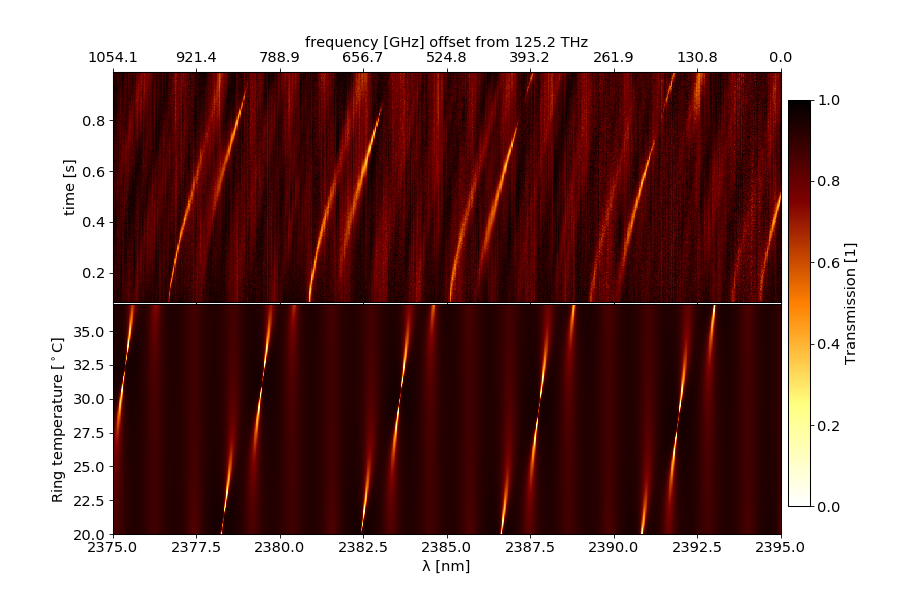

In [10]:
#d = ds1_w800_g200_15
#d = ds2_w800_g200_30
#d = ds3_w800_g300_20
#d = ds3_w800_g400_20
d = ds3_WB4_CH2_g400_20
#d = ds3_WB4_CH4_g300_20
d0 = d
t = d['t']

c = cm.afmhot_r # cm.gist_heat_r
#λ_lim = 2390.5,2391.2 # x limits in nm
λ_lim = 2375.,2395. # x limits in nm
#λ_lim = 2386.,2388. # x limits in nm
t_lim = 0.085,d['t'].max().m
vmax = 1
vmin = 0
recalc_model = True

#f = d['λ'].to(u.THz,'sp')
λ = d['λ'].to(u.nm)
T = d['V_trans_24'] - 286.7 * u.mV
ref = d['V_ref_24']

λ_mask = (λ.m<λ_lim[1])*(λ.m>λ_lim[0])
t_mask = (t.m<t_lim[1])*(t.m>t_lim[0])
ref_max = ref[t_mask,:][:,λ_mask].max()
T_max = T[t_mask,:][:,λ_mask].max()
z = T / T_max  #T_max #/T.max(axis=0)
z = T /T.max(axis=0)
#z = z/z.mean(axis=0)


g = 400*u.nm


%matplotlib notebook

if recalc_model:
    ds_model = linear_res_model(λ_lim,
                                nλ=1001,
                                T_ring_min=Q_(20,'degC'),
                                T_ring_max=Q_(37,'degC'),
#                                 T_ring_min=Q_(26,'degC'),
#                                 T_ring_max=Q_(35,'degC'),
                                nT_ring=1000,
                                T_U=Q_(21,'degC'),
                                Λ=1.41*u.um,
                                L_U_straight=583*u.um,
                                d_U_curve=122.35*u.um,
                                d_ring=120*u.um,
                                δκ=0.2,
                                g=g,
                                α_db_u = 1.5/u.cm,
                                α_db_ring=0.70/u.cm,
                                include_taper_dc=False)


fig = plt.figure(figsize=(12,8))
gs = GridSpec(4,2,width_ratios=(30,1),height_ratios=(1,8,8,1),hspace=0.02,wspace=0.02)
ax_expt = fig.add_subplot(gs[:2,0])
#ax_ref = fig.add_subplot(gs[2,0])
ax_model = fig.add_subplot(gs[2:,0])
cax = fig.add_subplot(gs[1:3,1])

p_expt = ax_expt.pcolormesh(λ,t,z,vmin=vmin,vmax=vmax,cmap=c)

#p_ref = ax_ref.pcolormesh(λ,t,ref/ref_max,vmin=0,vmax=1,cmap=c)


#z_model = ds_model['P_out'].squeeze().T
z_model = ds_model['P_out'].squeeze().T * ds_model['T_taper_dc'].squeeze().T
#z_model = z_model/z_model.max(axis=0)
p_model = ax_model.pcolormesh(ds_model['λ'],
                              ds_model['T_ring'],
                              z_model,
                              vmin=vmin,
                              vmax=vmax,
                              cmap=c)


for a in [ax_expt,ax_model]:
    if λ_lim:
        a.set_xlim(λ_lim)

if t_lim:
    for a in [ax_expt,]:
        a.set_ylim(t_lim)

ax_expt.set_ylabel('time [s]')
ax_model.set_ylabel('Ring temperature [$^\circ$C]')
ax_model.set_xlabel('λ [nm]')
ax_expt.tick_params(labelbottom=False)
#ax_ref.tick_params(labelbottom=False)
ax2 = lm2f_twiny_offset(ax_expt,offset=ax_expt.get_xlim()[1],units='GHz',w=3,p=1)
ax2.grid('off')
plt.colorbar(p_expt,label='Transmission [1]',cax=cax)
fig.tight_layout(gs)

<IPython.core.display.Javascript object>


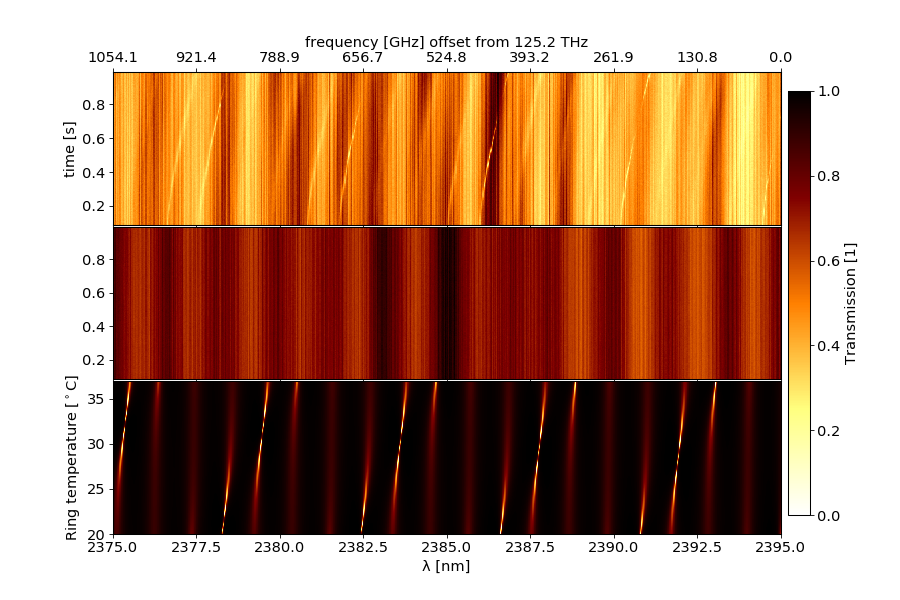

In [212]:
#d = ds1_w800_g200_15
#d = ds2_w800_g200_30
#d = ds3_w800_g300_20
#d = ds3_w800_g400_20
#d = ds3_WB1_CH2_g400_20
d = ds3_WB4_CH4_g300_20
d1 = d
t = d['t']

c = cm.afmhot_r # cm.gist_heat_r
#λ_lim = 2390.5,2391.2 # x limits in nm
λ_lim = 2375.,2395. # x limits in nm
t_lim = 0.085,d['t'].max().m
vmax = 1
vmin = 0
# recalc_model = True

#f = d['λ'].to(u.THz,'sp')
λ = d['λ'].to(u.nm)
T = d['V_trans_24'] - 286.7 * u.mV
ref = d['V_ref_24']

λ_mask = (λ.m<λ_lim[1])*(λ.m>λ_lim[0])
t_mask = (t.m<t_lim[1])*(t.m>t_lim[0])
ref_max = ref[t_mask,:][:,λ_mask].max()
T_max = T[t_mask,:][:,λ_mask].max()
z = T / T_max  #T_max #/T.max(axis=0)
#z = z/z.mean(axis=0)



g = 300*u.nm

%matplotlib notebook

if recalc_model:
    ds_model = linear_res_model(λ_lim,
                                nλ=1001,
                                T_ring_min=Q_(20,'degC'),
                                T_ring_max=Q_(37,'degC'),
#                                 T_ring_min=Q_(26,'degC'),
#                                 T_ring_max=Q_(35,'degC'),
                                nT_ring=1000,
                                T_U=Q_(21,'degC'),
                                Λ=1.41*u.um,
                                L_U_straight=583*u.um,
                                d_U_curve=122.35*u.um,
                                d_ring=120*u.um,
                                #κ_1=np.sqrt(0.6),
                                g=g,
                                δκ=0.2,
                                α_db_u = 1.0/u.cm,
                                α_db_ring=0.70/u.cm)


fig = plt.figure(figsize=(12,8))
gs = GridSpec(5,2,width_ratios=(30,1),height_ratios=(1,8,9,8,1),hspace=0.02,wspace=0.02)
ax_expt = fig.add_subplot(gs[:2,0])
ax_ref = fig.add_subplot(gs[2,0])
ax_model = fig.add_subplot(gs[3:,0])
cax = fig.add_subplot(gs[1:4,1])

p_expt = ax_expt.pcolormesh(λ,t,z,vmin=vmin,vmax=vmax,cmap=c)

p_ref = ax_ref.pcolormesh(λ,t,ref/ref_max,vmin=0,vmax=1,cmap=c)


z_model = ds_model['P_out'].squeeze().T
#z_model = z_model/z_model.max(axis=0)
p_model = ax_model.pcolormesh(ds_model['λ'],
                              ds_model['T_ring'],
                              z_model,
#                               vmin=vmin,
#                               vmax=vmax,
                              cmap=c)


for a in [ax_expt,ax_ref,ax_model]:
    if λ_lim:
        a.set_xlim(λ_lim)

if t_lim:
    for a in [ax_expt,ax_ref,]:
        a.set_ylim(t_lim)

ax_expt.set_ylabel('time [s]')
ax_model.set_ylabel('Ring temperature [$^\circ$C]')
ax_model.set_xlabel('λ [nm]')
ax_expt.tick_params(labelbottom=False)
ax_ref.tick_params(labelbottom=False)
ax2 = lm2f_twiny_offset(ax_expt,offset=ax_expt.get_xlim()[1],units='GHz',w=3,p=1)
ax2.grid('off')
plt.colorbar(p_expt,label='Transmission [1]',cax=cax)
fig.tight_layout(gs)

<IPython.core.display.Javascript object>


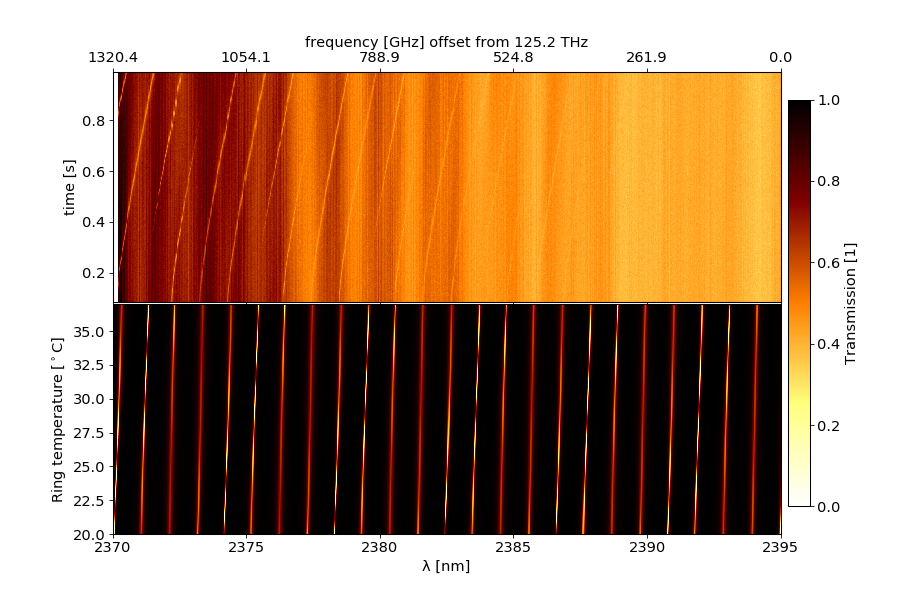

In [321]:
d = ds3_WB4_unmarked_flattened_g200_20
d2 = d
t = d['t']

c = cm.afmhot_r # cm.gist_heat_r
#λ_lim = 2390.5,2391.2 # x limits in nm
λ_lim = 2370.,2395. # x limits in nm
t_lim = 0.085,d['t'].max().m
vmax = 1
vmin = 0
recalc_model = True

#f = d['λ'].to(u.THz,'sp')
λ = d['λ'].to(u.nm)
T = d['V_trans_24']
T = T - 275*u.mV
#- 286.7 * u.mV
ref = d['V_ref_24']

λ_mask = (λ.m<λ_lim[1])*(λ.m>λ_lim[0])
t_mask = (t.m<t_lim[1])*(t.m>t_lim[0])
ref_max = ref[t_mask,:][:,λ_mask].max()
T_max = T[t_mask,:][:,λ_mask].max()
z = T / T_max  #T_max #/T.max(axis=0)
#z = z/z.mean(axis=0)



g = 200*u.nm

%matplotlib notebook

if recalc_model:
    ds_model = linear_res_model(λ_lim,
                                nλ=1001,
                                T_ring_min=Q_(20,'degC'),
                                T_ring_max=Q_(37,'degC'),
#                                 T_ring_min=Q_(26,'degC'),
#                                 T_ring_max=Q_(35,'degC'),
                                nT_ring=1000,
                                T_U=Q_(21,'degC'),
                                Λ=1.41*u.um,
                                L_U_straight=583*u.um,
                                d_U_curve=122.35*u.um,
                                d_ring=120*u.um,
                                #κ_1=np.sqrt(0.6),
                                δκ=0.2,
                                g=g,
                                α_db_u = 1.0/u.cm,
                                α_db_ring=0.70/u.cm)


fig = plt.figure(figsize=(12,8))
gs = GridSpec(4,2,width_ratios=(30,1),height_ratios=(1,8,8,1),hspace=0.02,wspace=0.02)
ax_expt = fig.add_subplot(gs[:2,0])
#ax_ref = fig.add_subplot(gs[2,0])
ax_model = fig.add_subplot(gs[2:,0])
cax = fig.add_subplot(gs[1:3,1])

p_expt = ax_expt.pcolormesh(λ,t,z,vmin=vmin,vmax=vmax,cmap=c)

#p_ref = ax_ref.pcolormesh(λ,t,ref/ref_max,vmin=0,vmax=1,cmap=c)


z_model = ds_model['P_out'].squeeze().T
#z_model = z_model/z_model.max(axis=0)
p_model = ax_model.pcolormesh(ds_model['λ'],
                              ds_model['T_ring'],
                              z_model,
#                               vmin=vmin,
#                               vmax=vmax,
                              cmap=c)


for a in [ax_expt,ax_model]:
    if λ_lim:
        a.set_xlim(λ_lim)

if t_lim:
    for a in [ax_expt,]:
        a.set_ylim(t_lim)

ax_expt.set_ylabel('time [s]')
ax_model.set_ylabel('Ring temperature [$^\circ$C]')
ax_model.set_xlabel('λ [nm]')
ax_expt.tick_params(labelbottom=False)
#ax_ref.tick_params(labelbottom=False)
ax2 = lm2f_twiny_offset(ax_expt,offset=ax_expt.get_xlim()[1],units='GHz',w=3,p=1)
ax2.grid('off')
plt.colorbar(p_expt,label='Transmission [1]',cax=cax)
fig.tight_layout(gs)


<IPython.core.display.Javascript object>


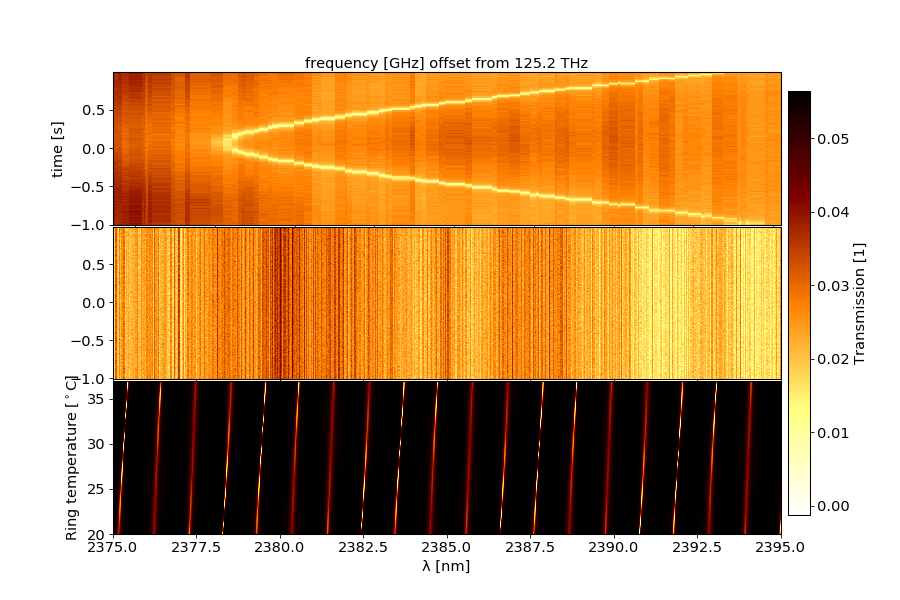

In [238]:
d = ds3_WB4_unmarked_flattened_g200_20_new_bg
d1 = d
t = d['t']

d_bg = ds3_bg_only 

c = cm.afmhot_r # cm.gist_heat_r
#λ_lim = 2390.5,2391.2 # x limits in nm
λ_lim = 2375.,2395. # x limits in nm
t_lim = d['t'].min().m,d['t'].max().m #0.085,d['t'].max().m
vmax = None #1
vmin = None # 0
recalc_model = True

#f = d['λ'].to(u.THz,'sp')
λ = d['λ'].to(u.nm)
λ_bg = d_bg['λ'].to(u.nm)
bg = d_bg['V_trans_24'] - 290.3*u.mV 
ref = d['V_ref_24']
T = d['V_trans_24'] - 290.3 * u.mV #(d['V_trans_24'] - 286.7 * u.mV) / ref

λ_mask = (λ.m<λ_lim[1])*(λ.m>λ_lim[0])
t_mask = (t.m<t_lim[1])*(t.m>t_lim[0])
ref_max = ref[t_mask,:][:,λ_mask].max()
ref_rel = ref / ref_max
T_max = T[t_mask,:][:,λ_mask].max()
z_bg = bg
z = T    #T_max #/T.max(axis=0)
#z = z/z.mean(axis=0)



g = 200*u.nm

%matplotlib notebook

if recalc_model:
    ds_model = linear_res_model(λ_lim,
                                nλ=1001,
                                T_ring_min=Q_(20,'degC'),
                                T_ring_max=Q_(37,'degC'),
#                                 T_ring_min=Q_(26,'degC'),
#                                 T_ring_max=Q_(35,'degC'),
                                nT_ring=1000,
                                T_U=Q_(21,'degC'),
                                Λ=1.41*u.um,
                                L_U_straight=583*u.um,
                                d_U_curve=122.35*u.um,
                                d_ring=120*u.um,
                                κ_1=np.array([np.sqrt(0.9)]),
                                g=g,
                                δκ=0.1,
                                α_db_u = 0.6/u.cm,
                                α_db_ring=0.70/u.cm)


fig = plt.figure(figsize=(12,8))
gs = GridSpec(5,2,width_ratios=(30,1),height_ratios=(1,8,9,8,1),hspace=0.02,wspace=0.02)
ax_expt = fig.add_subplot(gs[:2,0])
ax_ref = fig.add_subplot(gs[2,0])
ax_model = fig.add_subplot(gs[3:,0])
cax = fig.add_subplot(gs[1:4,1])

p_expt = ax_expt.pcolormesh(λ,t,z,vmin=vmin,vmax=vmax,cmap=c)

p_ref = ax_ref.pcolormesh(λ_bg,t,z_bg,vmin=vmin,vmax=vmax,cmap=c)


z_model = ds_model['P_out'].squeeze().T
#z_model = z_model/z_model.max(axis=0)
p_model = ax_model.pcolormesh(ds_model['λ'],
                              ds_model['T_ring'],
                              z_model,
                              vmin=vmin,
                              vmax=vmax,
                              cmap=c)


for a in [ax_expt,ax_ref,ax_model]:
    if λ_lim:
        a.set_xlim(λ_lim)

if t_lim:
    for a in [ax_expt,ax_ref,]:
        a.set_ylim(t_lim)

ax_expt.set_ylabel('time [s]')
ax_model.set_ylabel('Ring temperature [$^\circ$C]')
ax_model.set_xlabel('λ [nm]')
ax_expt.tick_params(labelbottom=False)
ax_ref.tick_params(labelbottom=False)
ax2 = lm2f_twiny_offset(ax_expt,offset=ax_expt.get_xlim()[1],units='GHz',w=3,p=1)
ax2.grid('off')
plt.colorbar(p_expt,label='Transmission [1]',cax=cax)
fig.tight_layout(gs)


<IPython.core.display.Javascript object>


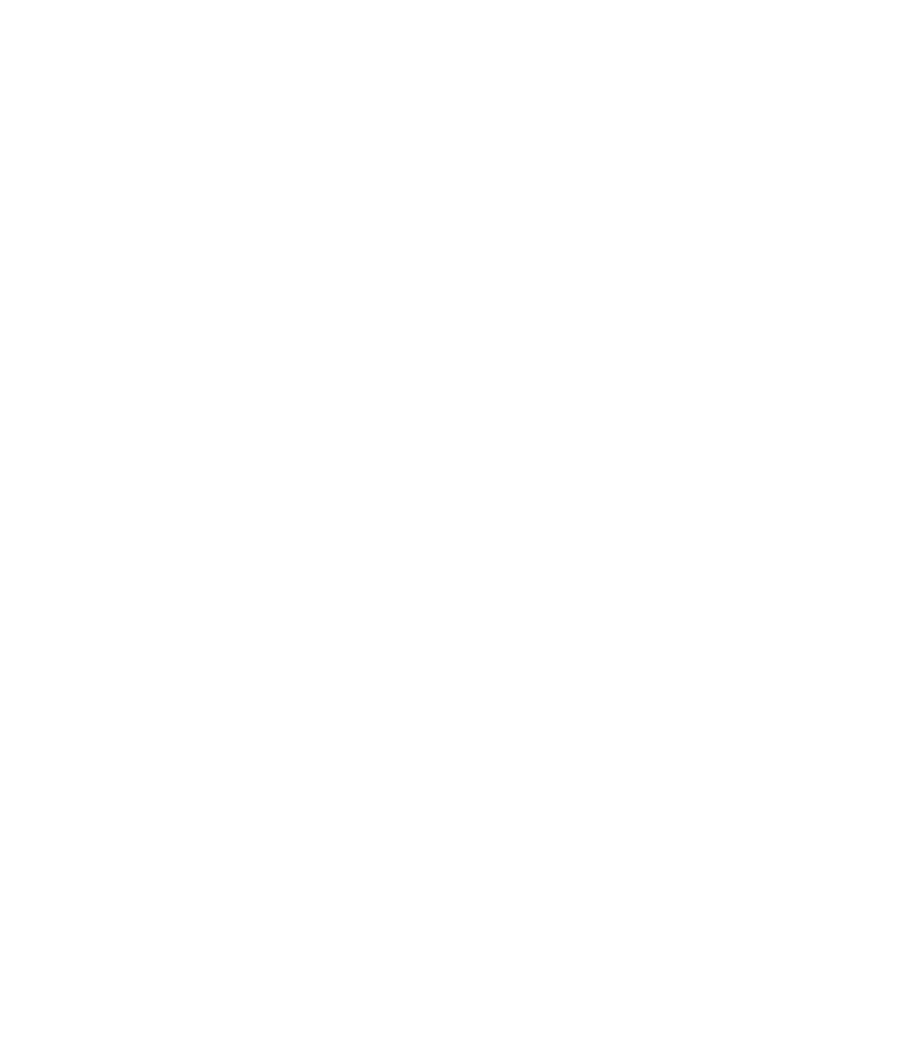

In [14]:


# compare two different chip/device measurements to see if the transmitted 2.4μm backgrounds align
t2 = d2['t']
t1 = d1['t']
t0 = d0['t']
c = cm.afmhot_r # cm.gist_heat_r
#λ_lim = 2390.5,2391.2 # x limits in nm
λ_lim = 2375.,2395. # x limits in nm
t_lim = 0.085,d['t'].max().m
vmax = 1
vmin = 0



λ0 = d0['λ'].to(u.nm)
T0 = d0['V_trans_24'] - 286.7 * u.mV
ref0 = d0['V_ref_24']
λ0_mask = (λ0.m<λ_lim[1])*(λ0.m>λ_lim[0])
t0_mask = (t0.m<t_lim[1])*(t0.m>t_lim[0])
ref0_max = ref0[t0_mask,:][:,λ0_mask].max()
T0_max = T0[t0_mask,:][:,λ0_mask].max()
z0 = T0 / T0_max  #T_max #/T.max(axis=0)

λ1 = d1['λ'].to(u.nm)
T1 = d1['V_trans_24'] - 286.7 * u.mV
ref1 = d1['V_ref_24']
λ1_mask = (λ1.m<λ_lim[1])*(λ1.m>λ_lim[0])
t1_mask = (t1.m<t_lim[1])*(t1.m>t_lim[0])
ref1_max = ref1[t1_mask,:][:,λ1_mask].max()
T1_max = T1[t1_mask,:][:,λ1_mask].max()
z1 = T1 / T1_max  #T_max #/T.max(axis=0)

λ2 = d2['λ'].to(u.nm)
T2 = d2['V_trans_24'] - 286.7 * u.mV
ref2 = d2['V_ref_24']
λ2_mask = (λ2.m<λ_lim[1])*(λ2.m>λ_lim[0])
t2_mask = (t2.m<t_lim[1])*(t2.m>t_lim[0])
ref2_max = ref2[t2_mask,:][:,λ2_mask].max()
T2_max = T2[t2_mask,:][:,λ2_mask].max()
z2 = T2 / T2_max  #T_max #/T.max(axis=0)


%matplotlib notebook

fig = plt.figure(figsize=(12,14))
gs = GridSpec(8,2,width_ratios=(30,1),height_ratios=(1,8,9,9,9,9,8,1),hspace=0.02,wspace=0.02)
ax_expt0 = fig.add_subplot(gs[:2,0])
ax_expt1 = fig.add_subplot(gs[2,0])
ax_expt2 = fig.add_subplot(gs[3,0])
ax_ref0 = fig.add_subplot(gs[4,0])
ax_ref1 = fig.add_subplot(gs[5,0])
ax_ref2 = fig.add_subplot(gs[6:,0])
cax = fig.add_subplot(gs[1:7,1])

p_expt0 = ax_expt0.pcolormesh(λ0,t0,z0,vmin=vmin,vmax=vmax,cmap=c)
p_ref0 = ax_ref0.pcolormesh(λ0,t0,ref0/ref0_max,vmin=0,vmax=1,cmap=c)
p_expt1 = ax_expt1.pcolormesh(λ1,t1,z1,vmin=vmin,vmax=vmax,cmap=c)
p_ref1 = ax_ref1.pcolormesh(λ1,t1,ref1/ref1_max,vmin=0,vmax=1,cmap=c)
p_expt2 = ax_expt2.pcolormesh(λ2,t2,z2,vmin=vmin,vmax=vmax,cmap=c)
p_ref2 = ax_ref2.pcolormesh(λ2,t2,ref2/ref2_max,vmin=0,vmax=1,cmap=c)


for a in [ax_expt0,ax_ref0,ax_expt1,ax_ref1,ax_expt2,ax_ref2,]:
    if λ_lim:
        a.set_xlim(λ_lim)
    if t_lim:
        a.set_ylim(t_lim)
    a.set_ylabel('time [s]')

ax_ref1.set_xlabel('λ [nm]')
ax_expt0.tick_params(labelbottom=False)
ax_expt1.tick_params(labelbottom=False)
ax_expt2.tick_params(labelbottom=False)
ax_ref0.tick_params(labelbottom=False)
ax_ref1.tick_params(labelbottom=False)
ax2 = lm2f_twiny_offset(ax_expt0,offset=ax_expt.get_xlim()[1],units='GHz',w=3,p=1)
ax2.grid('off')
plt.colorbar(p_expt0,label='Transmission [1]',cax=cax)
fig.tight_layout(gs)

<IPython.core.display.Javascript object>


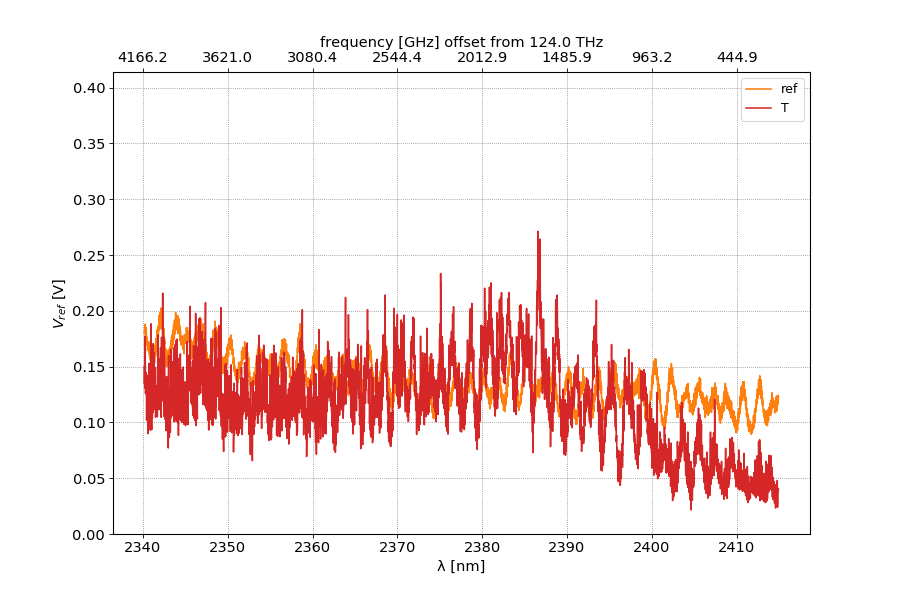

In [71]:
d = ds3_WB4_CH4_g300_20
c = cm.plasma_r
λ_lim = None # 2340,2410 # x limits in nm
V_lim = 0,2*d['V_ref_24'].max()
vmax = None # 1
vmin = None # 0

%matplotlib notebook
fig,ax = plt.subplots(1,1,figsize=(12,8))

# t = d['t']
# #f = d['λ'].to(u.THz,'sp')
# λ = d['λ'].to(u.nm)
T = d['V_trans_24'] - 288 * u.mV
ref = d['V_ref_24']
z_ref = ref.mean(axis=0) #/ T.max(axis=0)
z_T = T.mean(axis=0) #/ T.max(axis=0)

m = 0.13/0.02
#z = z/z.mean(axis=0)
#p = ax.pcolormesh(λ,t,z,vmin=vmin,vmax=vmax,cmap=c)
ax.plot(λ,z_ref,'C1',label='ref')
ax.plot(λ,m*z_T,'C3',label='T')
ax.legend()

if λ_lim:
    ax.set_xlim(λ_lim)
if V_lim:
    ax.set_ylim(V_lim)

ax.set_ylabel('$V_{ref}$ [V]')
ax.set_xlabel('λ [nm]')
ax2 = lm2f_twiny_offset(ax,offset=ax.get_xlim()[1])
ax2.grid('off')


<IPython.core.display.Javascript object>


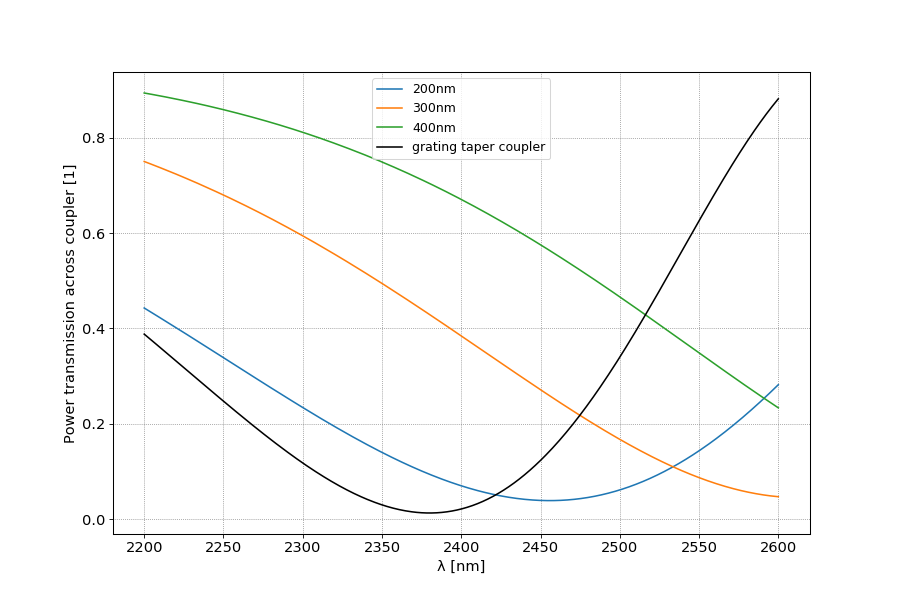

dind: 0, g: 200.0
dind: 1, g: 300.0
dind: 2, g: 400.0
dind: 3, g: 430.0


Text(0, 0.5, 'Power transmission across coupler [1]')

In [72]:
fig,ax = plt.subplots(1,1,figsize=(12,8))
ds_grating_dir_coupler
labels = ['200nm','300nm','400nm','grating taper coupler']
line_colors = ['C0','C1','C2','k']
for dind,d in enumerate([ds_res_coupler_g200,ds_res_coupler_g300,ds_res_coupler_g400,ds_grating_dir_coupler]):
    print(f"dind: {dind}, g: {d['gap']*1e9:4.1f}")
    ax.plot(d['signal_wavelength'],d['total_signal_through'],'-',label=labels[dind],color=line_colors[dind])

ax.legend()
ax.set_xlabel('λ [nm]')          
ax.set_ylabel('Power transmission across coupler [1]')

<IPython.core.display.Javascript object>


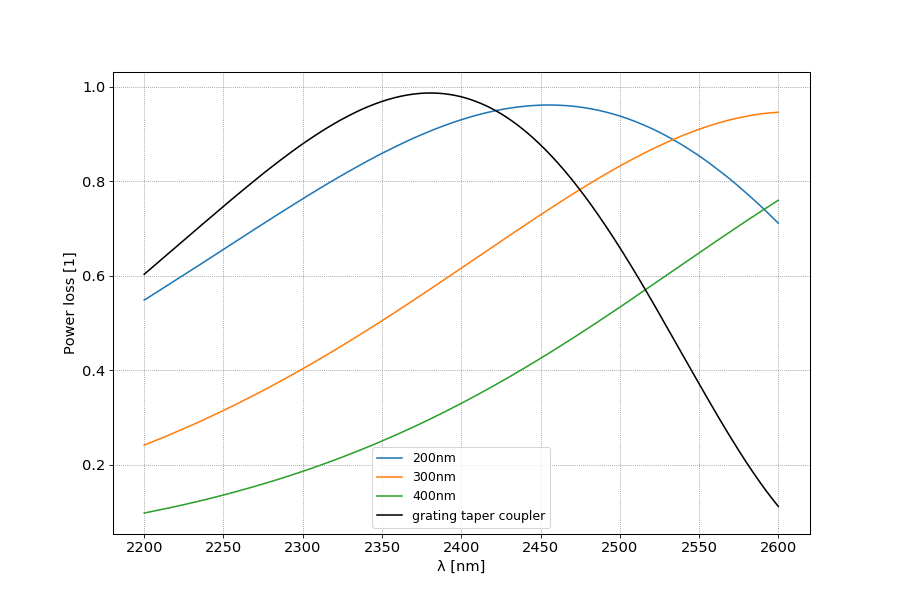

dind: 0, g: 200.0
dind: 1, g: 300.0
dind: 2, g: 400.0
dind: 3, g: 430.0


Text(0, 0.5, 'Power loss [1]')

In [73]:
fig,ax = plt.subplots(1,1,figsize=(12,8))
ds_grating_dir_coupler
labels = ['200nm','300nm','400nm','grating taper coupler']
line_colors = ['C0','C1','C2','k']
for dind,d in enumerate([ds_res_coupler_g200,ds_res_coupler_g300,ds_res_coupler_g400,ds_grating_dir_coupler]):
    print(f"dind: {dind}, g: {d['gap']*1e9:4.1f}")
    ax.plot(d['signal_wavelength'],d['total_signal_forward'],label=labels[dind],color=line_colors[dind])

ax.legend()
ax.set_xlabel('λ [nm]')          
ax.set_ylabel('Power loss [1]')

#ds_res_coupler_g200.keys()

#: dict_keys(['__header__', '__version__', '__globals__', 'data_signal_cavity_forward', 'data_signal_cavity_backwards', 'data_signal_in', 'data_signal_through', 'gap', 'L_coupler', 'delta_n', 'coupler_base_width', 'ring_base_width', 'ring_radius', 'slab_height', 'waveguide_height', 'simulate_pump', 'total_signal_forward', 'total_signal_backward', 'total_signal_through', 'total_signal_in', 'signal_wavelength', 'signal_loss'])

<IPython.core.display.Javascript object>


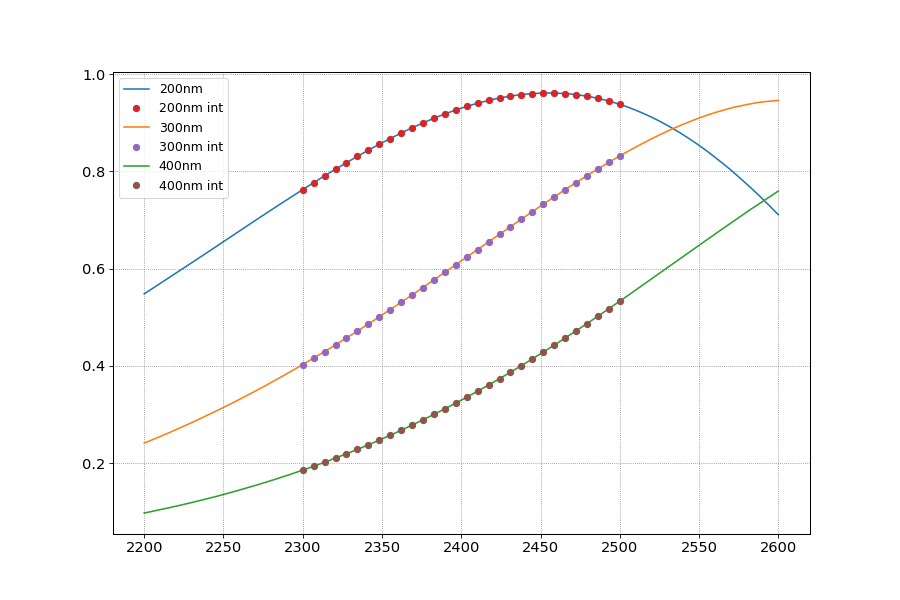

In [74]:
# check interpolation for modeling
λ_lim = 2300,2500
nλ=30
λ = np.linspace(λ_lim[0],λ_lim[1],nλ) * u.nm
g = 400*u.nm
d = ds_res_coupler_g400
Ti_1d = np.interp(λ.to(u.nm).m,d['signal_wavelength'][::-1],d['total_signal_through'][::-1])                  

y = [200,300,400]
# len(d['signal_wavelength']) = 500
z = np.zeros((3,500))
for dind,d in enumerate([ds_res_coupler_g200,ds_res_coupler_g300,ds_res_coupler_g400]):
    z[dind,:] = d['total_signal_forward'][::-1]
f_dc_rev = interp2d(1/d['signal_wavelength'][::-1], y, z, kind='linear', copy=True, bounds_error=False, fill_value=np.nan)
f_dc = lambda x,y:  f_dc_rev(1/x[::-1],y)[::-1]

fig,ax = plt.subplots(1,1,figsize=(12,8))
# ax.plot(d['signal_wavelength'],d['total_signal_through'],'k-',label='lumerical')
# ax.plot(λ,Ti_1d,'ro',label='interp')
line_colors = ['C0','C1','C2','k']
int_colors = ['C3','C4','C5','k']

for dind,d in enumerate([ds_res_coupler_g200,ds_res_coupler_g300,ds_res_coupler_g400]):
    #print(f"dind: {dind}, g: {d['gap']*1e9:4.1f}")
    ax.plot(d['signal_wavelength'],d['total_signal_forward'],label=labels[dind],color=line_colors[dind])
    #ax.plot(λ,f_dc(1/λ,y[dind])[::-1],'o',ms=6,color=int_colors[dind],label=labels[dind]+' int')
    ax.plot(λ,f_dc(λ,y[dind]),'o',ms=6,color=int_colors[dind],label=labels[dind]+' int')
ax.legend()

<IPython.core.display.Javascript object>


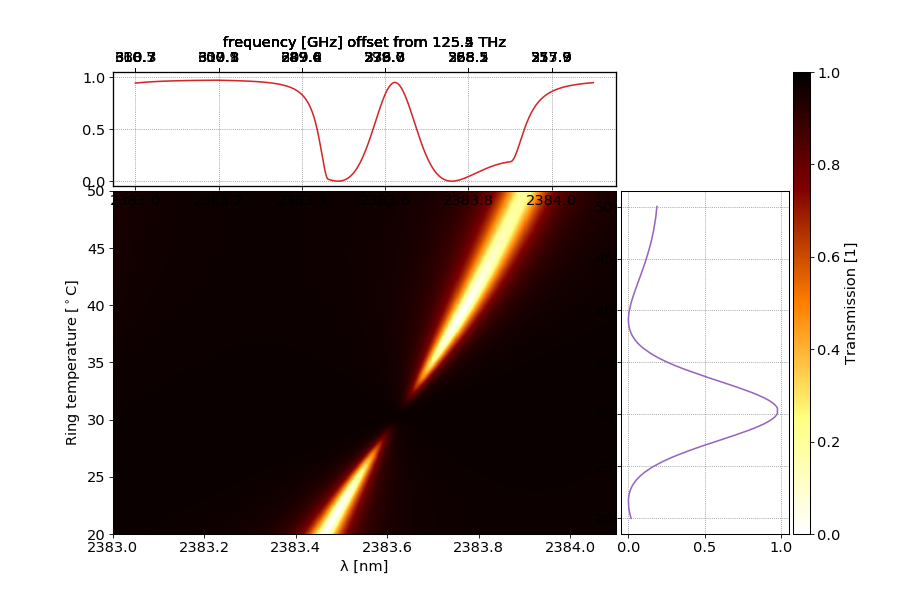

In [75]:
d = ds3_WB4_CH2_g400_20
t = d['t']
#d_bg = ds3_bg_only 

c = cm.afmhot_r # cm.gist_heat_r

#λ_lim = 2370,2390 #d['λ'].min().to(u.nm).m,d['λ'].max().to(u.nm).m
λ_lim = 2383,2384.1
t_lim = 0.085,d['t'].max().m
vmax = 1
vmin =  0
recalc_model = True

#f = d['λ'].to(u.THz,'sp')
λ = d['λ'].to(u.nm)
ref = d['V_ref_24']
T = d['V_trans_24'] - 290.3 * u.mV #(d['V_trans_24'] - 286.7 * u.mV) / ref

λ_mask = (λ.m<λ_lim[1])*(λ.m>λ_lim[0])
t_mask = (t.m<t_lim[1])*(t.m>t_lim[0])
ref_max = ref[t_mask,:][:,λ_mask].max()
ref_rel = ref / ref_max
T_max = T[t_mask,:][:,λ_mask].max()

z = T    #T_max #/T.max(axis=0)
#z = z/z.mean(axis=0)

g=200*u.nm



%matplotlib notebook

if recalc_model:
    ds_model = linear_res_model(λ_lim,
                                nλ=1001,
                                T_ring_min=Q_(20,'degC'),
                                T_ring_max=Q_(50,'degC'),
#                                 T_ring_min=Q_(26,'degC'),
#                                 T_ring_max=Q_(35,'degC'),
                                nT_ring=1000,
                                T_U=Q_(21,'degC'),
                                Λ=1.41*u.um,
                                L_U_straight=583*u.um,
                                d_U_curve=122.35*u.um,
                                d_ring=120*u.um,
                                #κ_1=np.array([np.sqrt(0.7)]),
                                δκ=0.001,
                                g=g,
                                α_db_u = 2.0/u.cm,
                                α_db_ring=1.0/u.cm,
                               include_taper_dc=False)

fig = plt.figure(figsize=(12,8))

gs = GridSpec(2,3,width_ratios=(30,10,1),height_ratios=(1,3),hspace=0.02,wspace=0.02)
ax_model = fig.add_subplot(gs[1,0])
ax_model_T_int = fig.add_subplot(gs[0,0])
ax_model_lm_int = fig.add_subplot(gs[1,1])
cb_ax = fig.add_subplot(gs[:,2])

z_model = ds_model['P_out'].squeeze().T * ds_model['T_taper_dc'].squeeze().T
#z_model = z_model/z_model.max(axis=0)
p_model = ax_model.pcolormesh(ds_model['λ'],
                              ds_model['T_ring'],
                              z_model,
                              vmin=vmin,
                              vmax=vmax,
                              cmap=c)

ax_model_T_int.plot(ds_model['λ'],ds_model['P_out'].min(axis=1),'C3')
ax_model_T_int.set_ylim([-0.05,1.05])

ax_model_lm_int.plot(ds_model['P_out'].min(axis=0),ds_model['T_ring'],'C4')
ax_model_lm_int.set_xlim([-0.05,1.05])


ax_model.set_xlim(λ_lim)
#ax_model.set_ylim(t_lim)
ax_model.set_ylabel('Ring temperature [$^\circ$C]')
ax_model.set_xlabel('λ [nm]')

ax2 = lm2f_twiny_offset(ax_model_T_int,offset=ax_expt.get_xlim()[1],units='GHz',w=3,p=1)
ax2.grid('off')
plt.colorbar(p_model,label='Transmission [1]',cax=cb_ax)




<IPython.core.display.Javascript object>


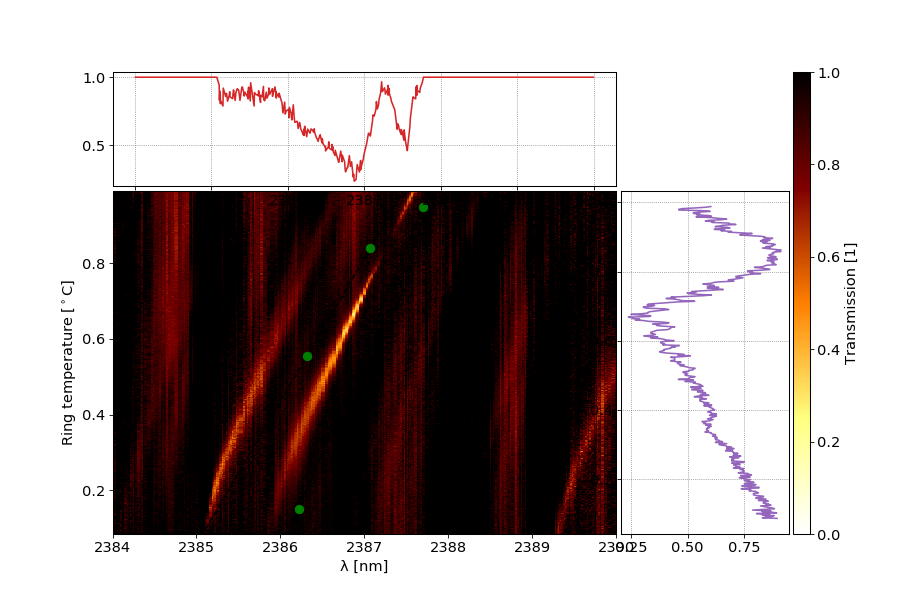

In [76]:
d = ds3_WB4_CH2_g400_20
t = d['t']
#d_bg = ds3_bg_only 

c = cm.afmhot_r # cm.gist_heat_r

#λ_lim = 2370,2390 #d['λ'].min().to(u.nm).m,d['λ'].max().to(u.nm).m
#λ_lim = 2383,2384.1
#λ_lim = 2386.,2388. # x limits in nm
λ_lim = 2384.,2390. # x limits in nm
t_lim = 0.085,d['t'].max().m
vmax = 1
vmin = 0
recalc_model = True

#f = d['λ'].to(u.THz,'sp')
λ = d['λ'].to(u.nm)
ref = d['V_ref_24']
T = d['V_trans_24'] - 290.3 * u.mV #(d['V_trans_24'] - 286.7 * u.mV) / ref

λ_mask = (λ.m<λ_lim[1])*(λ.m>λ_lim[0])
t_mask = (t.m<t_lim[1])*(t.m>t_lim[0])
ref_max = ref[t_mask,:][:,λ_mask].max()
ref_rel = ref / ref_max
T_max = T[t_mask,:][:,λ_mask].max()

λ = λ[λ_mask]
t = t[t_mask]
T = T[t_mask,:][:,λ_mask]

#### define diagonal lines along which to find normalization ###
# upper bg line def
u_p0 = (2386.32,0.5557)
u_p1 = (2387.07,0.83964)
m_u = (u_p1[1] - u_p0[1])/(u_p1[0] - u_p0[0])
b_u = u_p0[1] - m_u * u_p0[0]
bg_u = m_u * λ.m + b_u

# lower bg line def
l_p0 = 2386.22,0.15079
l_p1 = 2387.7,0.947
m_l = (l_p1[1] - l_p0[1])/(l_p1[0] - l_p0[0])
b_l = l_p0[1] - m_l * l_p0[0]
bg_l = m_l * λ.m + b_l

# now find values at points closest to these lines
z_norm_l = np.zeros(len(λ))
z_norm_u = np.zeros(len(λ))
z_norm = np.zeros(len(λ))
tind_norm_u = np.zeros(len(λ),dtype=np.int)
tind_norm_l = np.zeros(len(λ),dtype=np.int)
z = T.m #/T.max().m
for lind,ll in enumerate(λ):
    t_norm_u = m_u * ll.m + b_u
    t_norm_l = m_l * ll.m + b_l
    tind_norm_u[lind] = np.argmin(np.abs(t.m-t_norm_u))
    tind_norm_l[lind] = np.argmin(np.abs(t.m-t_norm_l))
    z_norm_u[lind] = T[tind_norm_u[lind],lind].m
    z_norm_l[lind] = T[tind_norm_l[lind],lind].m
    z_norm[lind] = np.max((z_norm_u[lind],z_norm_l[lind]))
    z[:,lind] = z[:,lind] / (z_norm[lind]*np.ones(len(t)))

#z_norm = z_norm[newaxis,:] * np.ones(len(t))[:,newaxis]
#z = T / z_norm    #T_max #/T.max(axis=0)
#z = z/z.mean(axis=0)

λ_mesh,t_mesh = np.meshgrid(λ.m,t.m)
mask = (m_u*λ_mesh+b_u > t_mesh) * (m_l*λ_mesh+b_l < t_mesh)
not_mask = (m_u*λ_mesh+b_u < t_mesh) + (m_l*λ_mesh+b_l > t_mesh)
z_new = z*mask + np.ones(z.shape)*not_mask

fig = plt.figure(figsize=(12,8))

gs = GridSpec(2,3,width_ratios=(30,10,1),height_ratios=(1,3),hspace=0.02,wspace=0.02)
ax_expt = fig.add_subplot(gs[1,0])
ax_expt_T_int = fig.add_subplot(gs[0,0])
ax_expt_lm_int = fig.add_subplot(gs[1,1])
cb_ax = fig.add_subplot(gs[:,2])

#z_model = ds_model['P_out'].squeeze().T * ds_model['T_taper_dc'].squeeze().T
#z_model = z_model/z_model.max(axis=0)
# p_model = ax_model.pcolormesh(ds_model['λ'],
#                               ds_model['T_ring'],
#                               z_model,
#                               cmap=c)

p_expt = ax_expt.pcolormesh(λ,t,z,vmin=vmin,vmax=vmax,cmap=c)

ax_expt_T_int.plot(λ,z_new.min(axis=0),'C3')
#ax_expt_T_int.set_ylim([-0.05,1.05])

ax_expt_lm_int.plot(z_new.min(axis=1),t,'C4')
#ax_expt_lm_int.set_xlim([-0.05,1.05])




ax_expt.plot(λ,bg_u,'k--')
ax_expt.plot(u_p0[0],u_p0[1],'go')
ax_expt.plot(u_p1[0],u_p1[1],'go')
ax_expt.plot(λ,bg_l,'k--')
ax_expt.plot(l_p0[0],l_p0[1],'go')
ax_expt.plot(l_p1[0],l_p1[1],'go')

ax_expt.set_xlim(λ_lim)
ax_expt.set_ylim(t_lim)
ax_expt.set_ylabel('Ring temperature [$^\circ$C]')
ax_expt.set_xlabel('λ [nm]')

ax2 = lm2f_twiny_offset(ax_model_T_int,offset=ax_expt.get_xlim()[1],units='GHz',w=3,p=1)
ax2.grid('off')
plt.colorbar(p_expt,label='Transmission [1]',cax=cb_ax)

<IPython.core.display.Javascript object>


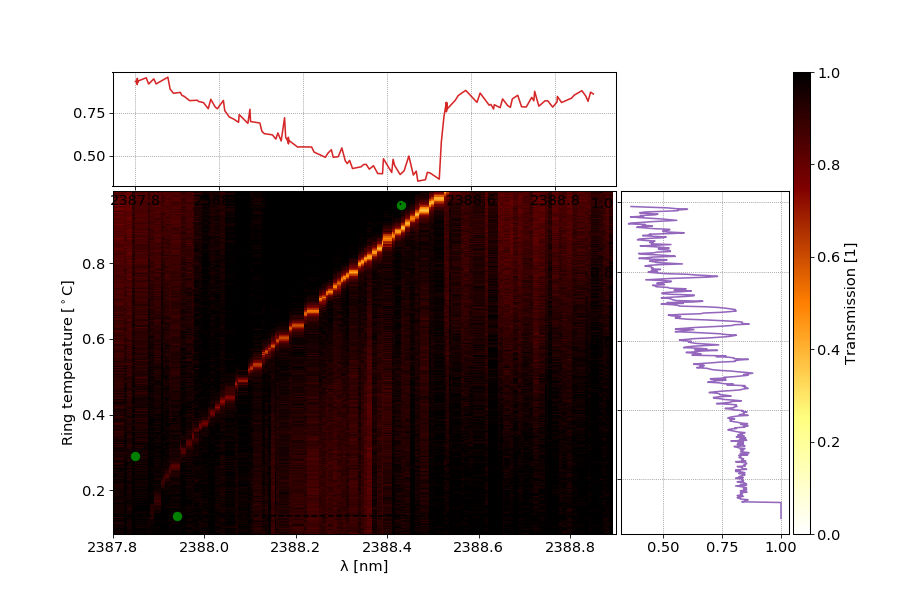

In [81]:

#d = ds3_WB4_CH2_g400_20
#d = ds3_WB4_CH4_g300_20
#d = ds3_WB4_unmarked_flattened_g200_20
d = ds3_WB4_unmarked_flattened_g200_20_new_bg

t = d['t']
#d_bg = ds3_bg_only 

c = cm.afmhot_r # cm.gist_heat_r

#λ_lim = 2370,2390 #d['λ'].min().to(u.nm).m,d['λ'].max().to(u.nm).m
#λ_lim = 2383,2384.1
#λ_lim = 2386.,2388. # x limits in nm
λ_lim = 2387.8,2388.9 # x limits in nm
t_lim = 0.085,d['t'].max().m
vmax = 1
vmin = 0
recalc_model = True

#f = d['λ'].to(u.THz,'sp')
λ = d['λ'].to(u.nm)
ref = d['V_ref_24']
T = d['V_trans_24'] - 290.3 * u.mV #(d['V_trans_24'] - 286.7 * u.mV) / ref

λ_mask = (λ.m<λ_lim[1])*(λ.m>λ_lim[0])
t_mask = (t.m<t_lim[1])*(t.m>t_lim[0])
ref_max = ref[t_mask,:][:,λ_mask].max()
ref_rel = ref / ref_max
T_max = T[t_mask,:][:,λ_mask].max()

λ = λ[λ_mask]
t = t[t_mask]
T = T[t_mask,:][:,λ_mask]

#### define diagonal lines along which to find normalization ###
# upper bg line def
u_p0 = (2387.85,0.29)
u_p1 = (2388.43,0.953)
m_u = (u_p1[1] - u_p0[1])/(u_p1[0] - u_p0[0])
b_u = u_p0[1] - m_u * u_p0[0]
bg_u = m_u * λ.m + b_u

# lower bg line def
l_p0 = 2387.94,0.133
l_p1 = 23888.6,0.97
m_l = (l_p1[1] - l_p0[1])/(l_p1[0] - l_p0[0])
b_l = l_p0[1] - m_l * l_p0[0]
bg_l = m_l * λ.m + b_l

# now find values at points closest to these lines
z_norm_l = np.zeros(len(λ))
z_norm_u = np.zeros(len(λ))
z_norm = np.zeros(len(λ))
tind_norm_u = np.zeros(len(λ),dtype=np.int)
tind_norm_l = np.zeros(len(λ),dtype=np.int)
z = T.m #/T.max().m
for lind,ll in enumerate(λ):
    t_norm_u = m_u * ll.m + b_u
    t_norm_l = m_l * ll.m + b_l
    tind_norm_u[lind] = np.argmin(np.abs(t.m-t_norm_u))
    tind_norm_l[lind] = np.argmin(np.abs(t.m-t_norm_l))
    z_norm_u[lind] = T[tind_norm_u[lind],lind].m
    z_norm_l[lind] = T[tind_norm_l[lind],lind].m
    z_norm[lind] = np.max((z_norm_u[lind],z_norm_l[lind]))
    z[:,lind] = z[:,lind] / (z_norm[lind]*np.ones(len(t)))

#z_norm = z_norm[newaxis,:] * np.ones(len(t))[:,newaxis]
#z = T / z_norm    #T_max #/T.max(axis=0)
#z = z/z.mean(axis=0)

λ_mesh,t_mesh = np.meshgrid(λ.m,t.m)
mask = (m_u*λ_mesh+b_u > t_mesh) * (m_l*λ_mesh+b_l < t_mesh)
not_mask = (m_u*λ_mesh+b_u < t_mesh) + (m_l*λ_mesh+b_l > t_mesh)
z_new = z*mask + np.ones(z.shape)*not_mask

fig = plt.figure(figsize=(12,8))

gs = GridSpec(2,3,width_ratios=(30,10,1),height_ratios=(1,3),hspace=0.02,wspace=0.02)
ax_expt = fig.add_subplot(gs[1,0])
ax_expt_T_int = fig.add_subplot(gs[0,0])
ax_expt_lm_int = fig.add_subplot(gs[1,1])
cb_ax = fig.add_subplot(gs[:,2])

#z_model = ds_model['P_out'].squeeze().T * ds_model['T_taper_dc'].squeeze().T
#z_model = z_model/z_model.max(axis=0)
# p_model = ax_model.pcolormesh(ds_model['λ'],
#                               ds_model['T_ring'],
#                               z_model,
#                               cmap=c)

p_expt = ax_expt.pcolormesh(λ,t,z,vmin=vmin,vmax=vmax,cmap=c)

ax_expt_T_int.plot(λ,z_new.min(axis=0),'C3')
#ax_expt_T_int.set_ylim([-0.05,1.05])

ax_expt_lm_int.plot(z_new.min(axis=1),t,'C4')
#ax_expt_lm_int.set_xlim([-0.05,1.05])




ax_expt.plot(λ,bg_u,'k--')
ax_expt.plot(u_p0[0],u_p0[1],'go')
ax_expt.plot(u_p1[0],u_p1[1],'go')
ax_expt.plot(λ,bg_l,'k--')
ax_expt.plot(l_p0[0],l_p0[1],'go')
ax_expt.plot(l_p1[0],l_p1[1],'go')

ax_expt.set_xlim(λ_lim)
ax_expt.set_ylim(t_lim)
ax_expt.set_ylabel('Ring temperature [$^\circ$C]')
ax_expt.set_xlabel('λ [nm]')

ax2 = lm2f_twiny_offset(ax_model_T_int,offset=ax_expt.get_xlim()[1],units='GHz',w=3,p=1)
ax2.grid('off')
plt.colorbar(p_expt,label='Transmission [1]',cax=cb_ax)


<IPython.core.display.Javascript object>


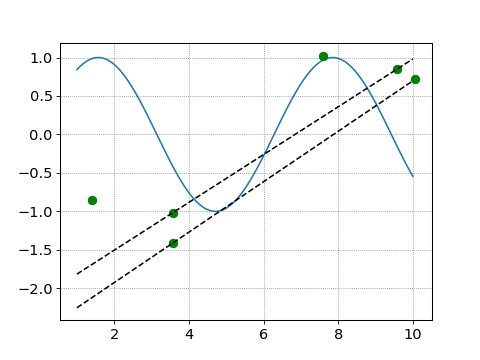

In [82]:
f,a = plt.subplots()
x = np.linspace(1,10,100)
y = np.sin(x)
a.plot(x,y)
pos = []
def onclick(event):
    if event.button == 1:
        pos.append([event.xdata,event.ydata])
        #print(f'x: {event.xdata:3.3f}, y: {event.ydata:3.3f}')
        plt.plot(event.xdata,event.ydata,'go')
        plt.draw()
    elif event.button == 3:
        # Write to figure
#         plt.figtext(3, 8, 'boxed italics text in data coords', style='italic', bbox={'facecolor':'red', 'alpha':0.5, 'pad':10})
        u_p0 = pos[-2] #(2387.85,0.29)
        u_p1 = pos[-1] #(2388.43,0.953)
        m_u = (u_p1[1] - u_p0[1])/(u_p1[0] - u_p0[0])
        b_u = u_p0[1] - m_u * u_p0[0]
        y_line = bg_u = m_u * x + b_u
        plt.plot(x,y_line,'k--')
        plt.draw()
    else:
        pass # Do nothing
f.canvas.mpl_connect('button_press_event', onclick)
f.show()


In [83]:
def manual_norm(ds3_WB4_CH2_g400_20):
    t = d['t']
    c_full = cm.afmhot_r # cm.gist_heat_r
    c_zoom = cm.bone_r
    λ_lim = 2375,2395 #d['λ'].min().to(u.nm).m,d['λ'].max().to(u.nm).m
    #λ_lim = 2383,2384.1
    #λ_lim = 2386.,2388. # x limits in nm
    #λ_lim = 2384.,2390. # x limits in nm
    t_lim = 0.085,d['t'].max().m
    vmax = 1
    vmin = 0
    recalc_model = True

    #f = d['λ'].to(u.THz,'sp')
    λ = d['λ'].to(u.nm)
    ref = d['V_ref_24']
    T = d['V_trans_24'] - 290.3 * u.mV #(d['V_trans_24'] - 286.7 * u.mV) / ref

    λ_mask = (λ.m<λ_lim[1])*(λ.m>λ_lim[0])
    t_mask = (t.m<t_lim[1])*(t.m>t_lim[0])
    ref_max = ref[t_mask,:][:,λ_mask].max()
    ref_rel = ref / ref_max
    T_max = T[t_mask,:][:,λ_mask].max()

    λ = λ[λ_mask]
    t = t[t_mask]
    T = T[t_mask,:][:,λ_mask]
    z_full = T.m /T.max().m
    z = T.m
    
    
    
    fig = plt.figure(figsize=(12,8))

    gs = GridSpec(3,3,width_ratios=(30,10,1),height_ratios=(2,1,3),hspace=0.02,wspace=0.02)
    ax_full = fig.add_subplot(gs[0,:2])
    ax_zoom = fig.add_subplot(gs[2,0])
    ax_zoom_t_int = fig.add_subplot(gs[1,0])
    ax_zoom_λ_int = fig.add_subplot(gs[1,2])
    cb_ax_full = fig.add_subplot(gs[0,2])
    cb_ax_zoom = fig.add_subplot(gs[2,2])

    p_full = ax_full.pcolormesh(λ,t,z,vmin=vmin,vmax=vmax,cmap=c_full)

    ax_full.set_xlim(λ_lim)
    ax_full.set_ylim(t_lim)
    ax_full.set_ylabel('time [s]')
    ax_full.set_xlabel('λ [nm]')

#     ax2 = lm2f_twiny_offset(ax_model_T_int,offset=ax_expt.get_xlim()[1],units='GHz',w=3,p=1)
#     ax2.grid('off')
    plt.colorbar(p_full,label='Transmission [1]',cax=cb_ax_full)
    pts = []
    λ_zoom = []
    z_zoom_t_min = []
    
    
    def onclick(event):
        if event.button == 1:
            pts.append([event.xdata,event.ydata])
            #print(f'x: {event.xdata:3.3f}, y: {event.ydata:3.3f}')
            ax_full.plot(event.xdata,event.ydata,'go')
            plt.draw()
        elif event.button == 3:
            normalize_slice(z,pts,z_zoom_t_min,λ_zoom_t_min,ax_full,ax_zoom,ax_zoom_t_int,
                            ax_zoom_λ_int,cb_ax_zoom,vmin=0,vmax=1)
            plt.draw()
        else:
            pass # Do nothing
    fig.canvas.mpl_connect('button_press_event', onclick)
    fig.show()
    
    
def normalize_slice(z,pts,z_zoom_t_min,λ_zoom_t_min,ax_full,ax_zoom,ax_t_int,ax_λ_int,cb_ax_zoom,vmin=0,vmax=1):

    u_p0 = pts[-4]
    u_p1 = pts[-3]
    m_u = (u_p1[1] - u_p0[1])/(u_p1[0] - u_p0[0])
    b_u = u_p0[1] - m_u * u_p0[0]

    u_p0 = pts[-2]
    u_p1 = pts[-1]
    m_l = (l_p1[1] - l_p0[1])/(l_p1[0] - l_p0[0])
    b_l = l_p0[1] - m_l * l_p0[0]
    
    
    λ_zoom_lim = (t_lim[0]-b_u)/m_u, (t_lim[1]-b_l)/m_l
    λ_zoom_mask = (λ.m<λ_zoom_lim[1])*(λ.m>λ_zoom_lim[0])
    λ_zoom = λ[λ_zoom_mask]
    T_zoom = T[t_mask,:][:,λ_zoom_mask]
    z_zoom = T_zoom
    
    bg_u = m_u * λ_zoom.m + b_u
    bg_l = m_l * λ_zoom.m + b_l
    
    # now find values at points closest to these lines
    z_norm_l = np.zeros(len(λ_zoom))
    z_norm_u = np.zeros(len(λ_zoom))
    z_norm = np.zeros(len(λ_zoom))
    tind_norm_u = np.zeros(len(λ_zoom),dtype=np.int)
    tind_norm_l = np.zeros(len(λ_zoom),dtype=np.int)
    for lind,ll in enumerate(λ_zoom):
        t_norm_u = m_u * ll.m + b_u
        t_norm_l = m_l * ll.m + b_l
        tind_norm_u[lind] = np.argmin(np.abs(t.m-t_norm_u))
        tind_norm_l[lind] = np.argmin(np.abs(t.m-t_norm_l))
        z_norm_u[lind] = T_zoom[tind_norm_u[lind],lind].m
        z_norm_l[lind] = T_zoom[tind_norm_l[lind],lind].m
        z_norm[lind] = np.max((z_norm_u[lind],z_norm_l[lind]))
        z_zoom[:,lind] = z[:,lind] / (z_norm[lind]*np.ones(len(t)))

    λ_mesh,t_mesh = np.meshgrid(λ_zoom.m,t.m)
    mask = (m_u*λ_mesh+b_u > t_mesh) * (m_l*λ_mesh+b_l < t_mesh)
    not_mask = (m_u*λ_mesh+b_u < t_mesh) + (m_l*λ_mesh+b_l > t_mesh)
    z_zoom = z_zoom*mask + np.ones(z_zoom.shape)*not_mask
    z_zoom_min_t = z_zoom.min(axis=0)
    z_zoom_min_λ = z_zoom.min(axis=1)
    ax_t_int.plot(λ_zoom,z_zoom_min_t,'C3')
    ax_λ_int.plot(z_zoom_min_λ,t,'C4')
    λ_zoom_t_min.append(λ_zoom)
    z_zoom_t_min.append(z_zoom_min_t)
    p_zoom = ax_zoom.pcolormesh(λ_zoom,t,z_zoom,vmin=vmin,vmax=vmax,cmap=c_full)
    ax_full.plot(λ_zoom,bg_u,'b--')
#     ax_full.plot(u_p0[0],u_p0[1],'go')
#     ax_full.plot(u_p1[0],u_p1[1],'go')
    ax_full.plot(λ_zoom,bg_l,'b--')
#     ax_full.plot(l_p0[0],l_p0[1],'go')
#     ax_full.plot(l_p1[0],l_p1[1],'go')
    ax_zoom.plot(λ_zoom,bg_u,'b--')
    ax_zoom.plot(u_p0[0],u_p0[1],'go')
    ax_zoom.plot(u_p1[0],u_p1[1],'go')
    ax_zoom.plot(λ_zoom,bg_l,'b--')
    ax_zoom.plot(l_p0[0],l_p0[1],'go')
    ax_zoom.plot(l_p1[0],l_p1[1],'go')
    plt.colorbar(p_zoom,label='Transmission [1]',cax=cb_ax_zoom)
    
    

<IPython.core.display.Javascript object>


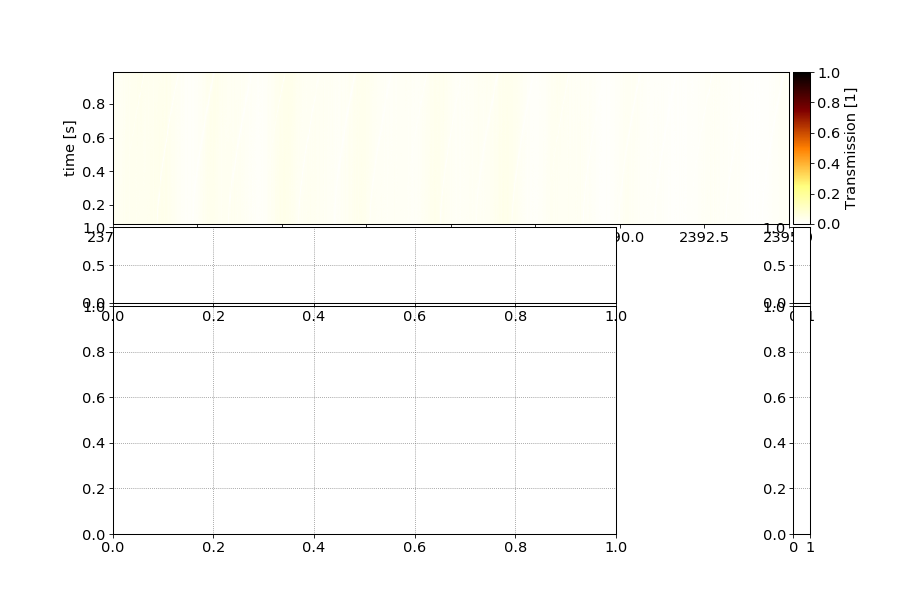

In [84]:
manual_norm(ds3_WB4_CH2_g400_20)

<IPython.core.display.Javascript object>


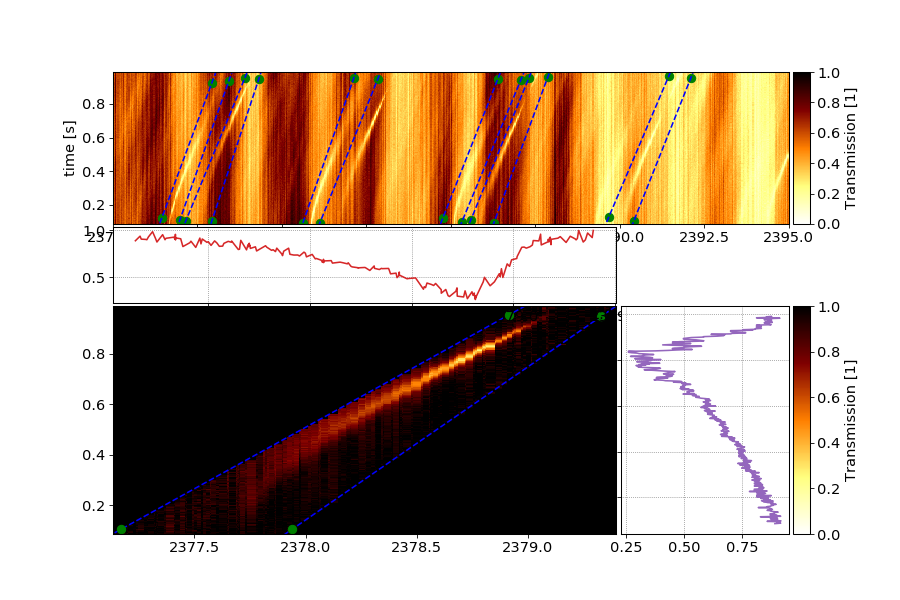

In [303]:
d = ds3_WB4_CH2_g400_20
t = d['t']
c_full = cm.afmhot_r # cm.gist_heat_r
c_zoom = cm.bone_r
λ_lim = 2375,2395 #d['λ'].min().to(u.nm).m,d['λ'].max().to(u.nm).m
#λ_lim = 2383,2384.1
#λ_lim = 2386.,2388. # x limits in nm
#λ_lim = 2384.,2390. # x limits in nm
t_lim = 0.085,d['t'].max().m
vmax = 1
vmin = 0
recalc_model = True

#f = d['λ'].to(u.THz,'sp')
λ = d['λ'].to(u.nm)
ref = d['V_ref_24']
T = d['V_trans_24'] - 290.3 * u.mV #(d['V_trans_24'] - 286.7 * u.mV) / ref

λ_mask = (λ.m<λ_lim[1])*(λ.m>λ_lim[0])
t_mask = (t.m<t_lim[1])*(t.m>t_lim[0])
ref_max = ref[t_mask,:][:,λ_mask].max()
ref_rel = ref / ref_max
T_max = T[t_mask,:][:,λ_mask].max()

λ = λ[λ_mask]
t = t[t_mask]
T = T[t_mask,:][:,λ_mask]
z_full = T.m /T.max().m
z = T.m



fig = plt.figure(figsize=(12,8))

gs = GridSpec(3,3,width_ratios=(30,10,1),height_ratios=(2,1,3),hspace=0.02,wspace=0.02)
ax_full = fig.add_subplot(gs[0,:2])
ax_zoom = fig.add_subplot(gs[2,0])
ax_zoom_t_int = fig.add_subplot(gs[1,0])
ax_zoom_λ_int = fig.add_subplot(gs[2,1])
cb_ax_full = fig.add_subplot(gs[0,2])
cb_ax_zoom = fig.add_subplot(gs[2,2])

p_full = ax_full.pcolormesh(λ,t,z_full,vmin=vmin,vmax=vmax,cmap=c_full)

λ_zoom=λ
z_zoom = z_full
z_zoom_min_t = z_zoom.min(axis=0)
z_zoom_min_λ = z_zoom.min(axis=1)
ax_zoom_t_int.plot(λ_zoom,z_zoom_min_t,'C3')
ax_zoom_λ_int.plot(z_zoom_min_λ,t,'C4')
p_zoom = ax_zoom.pcolormesh(λ_zoom,t,z_zoom,vmin=vmin,vmax=vmax,cmap=c_full)
plt.colorbar(p_zoom,label='Transmission [1]',cax=cb_ax_zoom)
ax_zoom.set_xlim(λ_lim)
ax_zoom.set_ylim(t_lim)


ax_full.set_xlim(λ_lim)
ax_full.set_ylim(t_lim)
ax_full.set_ylabel('time [s]')
ax_full.set_xlabel('λ [nm]')

#     ax2 = lm2f_twiny_offset(ax_model_T_int,offset=ax_expt.get_xlim()[1],units='GHz',w=3,p=1)
#     ax2.grid('off')
plt.colorbar(p_full,label='Transmission [1]',cax=cb_ax_full)
pts = []
λ_zoom_t_min = []
z_zoom_t_min = []


def onclick(event):
    if event.button == 1:
        pts.append([event.xdata,event.ydata])
        #print(f'x: {event.xdata:3.3f}, y: {event.ydata:3.3f}')
        ax_full.plot(event.xdata,event.ydata,'go')
        plt.draw()
    elif event.button == 3:
#         normalize_slice(z,pts,z_zoom_t_min,λ_zoom_t_min,ax_full,ax_zoom,ax_zoom_t_int,
#                         ax_zoom_λ_int,cb_ax_zoom,vmin=0,vmax=1)
        #ax_full.plot(event.xdata,event.ydata,'bo')
        u_p0 = pts[-4]
        u_p1 = pts[-3]
        m_u = (u_p1[1] - u_p0[1])/(u_p1[0] - u_p0[0])
        b_u = u_p0[1] - m_u * u_p0[0]

        l_p0 = pts[-2]
        l_p1 = pts[-1]
        m_l = (l_p1[1] - l_p0[1])/(l_p1[0] - l_p0[0])
        b_l = l_p0[1] - m_l * l_p0[0]
        λ_zoom_lim = (t_lim[0]-b_u)/m_u, (t_lim[1]-b_l)/m_l
        λ_zoom_mask = (λ.m<λ_zoom_lim[1])*(λ.m>λ_zoom_lim[0])
        λ_zoom = λ[λ_zoom_mask]
        T_zoom = T[:,λ_zoom_mask]
        z_zoom = T_zoom.m

        bg_u = m_u * λ_zoom.m + b_u
        bg_l = m_l * λ_zoom.m + b_l
#         ax_full.plot(λ_zoom,bg_u,'b--')
#         ax_full.plot(λ_zoom,bg_l,'b--')
#         plt.draw()
        # now find values at points closest to these lines
        z_norm_l = np.zeros(len(λ_zoom))
        z_norm_u = np.zeros(len(λ_zoom))
        z_norm = np.zeros(len(λ_zoom))
        tind_norm_u = np.zeros(len(λ_zoom),dtype=np.int)
        tind_norm_l = np.zeros(len(λ_zoom),dtype=np.int)
        for lind,ll in enumerate(λ_zoom):
            t_norm_u = m_u * ll.m + b_u
            t_norm_l = m_l * ll.m + b_l
            tind_norm_u[lind] = np.argmin(np.abs(t.m-t_norm_u))
            tind_norm_l[lind] = np.argmin(np.abs(t.m-t_norm_l))
            z_norm_u[lind] = T_zoom[tind_norm_u[lind],lind].m
            z_norm_l[lind] = T_zoom[tind_norm_l[lind],lind].m
            z_norm[lind] = np.max((z_norm_u[lind],z_norm_l[lind]))
            z_zoom[:,lind] = z_zoom[:,lind] / (z_norm[lind]*np.ones(len(t)))

        λ_mesh,t_mesh = np.meshgrid(λ_zoom.m,t.m)
        mask = (m_u*λ_mesh+b_u > t_mesh) * (m_l*λ_mesh+b_l < t_mesh)
        not_mask = (m_u*λ_mesh+b_u < t_mesh) + (m_l*λ_mesh+b_l > t_mesh)
        z_zoom = z_zoom*mask + np.ones(z_zoom.shape)*not_mask
        z_zoom_min_t = z_zoom.min(axis=0)
        z_zoom_min_λ = z_zoom.min(axis=1)
        
#         plt.sca(ax_zoom_t_int) #
#         plt.cla() #
        ax_zoom_t_int.clear()
        ax_zoom_t_int.plot(λ_zoom,z_zoom_min_t,'C3')
        
#         plt.sca(ax_zoom_λ_int) #
#         plt.cla() #
        ax_zoom_λ_int.clear()
        ax_zoom_λ_int.plot(z_zoom_min_λ,t,'C4')
        λ_zoom_t_min.append(λ_zoom)
        z_zoom_t_min.append(z_zoom_min_t)
        
#         plt.sca(ax_zoom) #
#         plt.cla() #
        ax_zoom.clear()
        p_zoom = ax_zoom.pcolormesh(λ_zoom,t,z_zoom,vmin=vmin,vmax=vmax,cmap=c_full)
        ax_zoom.plot(λ_zoom,bg_u,'b--')
        ax_zoom.plot(u_p0[0],u_p0[1],'go')
        ax_zoom.plot(u_p1[0],u_p1[1],'go')
        ax_zoom.plot(λ_zoom,bg_l,'b--')
        ax_zoom.plot(l_p0[0],l_p0[1],'go')
        ax_zoom.plot(l_p1[0],l_p1[1],'go')
        ax_zoom.set_xlim(λ_zoom_lim)
        ax_zoom.set_ylim(t_lim)
        
        
        plt.sca(ax_full) #
        ax_full.plot(λ_zoom,bg_u,'b--')
        ax_full.plot(λ_zoom,bg_l,'b--')
        
        #plt.colorbar(p_zoom,label='Transmission [1]',cax=cb_ax_zoom)
        plt.draw()
        fig.canvas.flush_events()
    else:
        pass # Do nothing

fig.canvas.mpl_connect('button_press_event', onclick)
fig.show()

# Manual normalization and fitting

## Analysis of g400 data

<IPython.core.display.Javascript object>


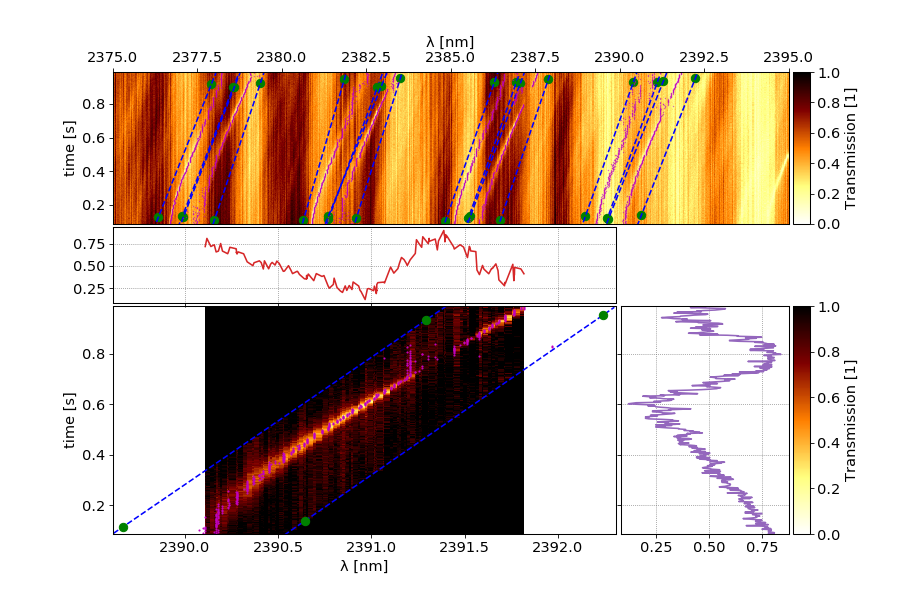

In [147]:
# pick out diagonal regions of 2D tuning with nice resonance data
d = ds3_WB4_CH2_g400_20
t = d['t']
c_full = cm.afmhot_r # cm.gist_heat_r
c_zoom = cm.bone_r
λ_lim = 2375,2395 #d['λ'].min().to(u.nm).m,d['λ'].max().to(u.nm).m
#λ_lim = 2383,2384.1
#λ_lim = 2386.,2388. # x limits in nm
#λ_lim = 2384.,2390. # x limits in nm
t_lim = 0.085,d['t'].max().m
vmax = 1
vmin = 0
recalc_model = True

#f = d['λ'].to(u.THz,'sp')
λ = d['λ'].to(u.nm)
ref = d['V_ref_24']
T = d['V_trans_24'] - 290.3 * u.mV #(d['V_trans_24'] - 286.7 * u.mV) / ref

λ_mask = (λ.m<λ_lim[1])*(λ.m>λ_lim[0])
t_mask = (t.m<t_lim[1])*(t.m>t_lim[0])
ref_max = ref[t_mask,:][:,λ_mask].max()
ref_rel = ref / ref_max
T_max = T[t_mask,:][:,λ_mask].max()

λ = λ[λ_mask]
t = t[t_mask]
T = T[t_mask,:][:,λ_mask]
z_full = T.m /T.max().m
z = T.m



fig = plt.figure(figsize=(12,8))

gs = GridSpec(3,3,width_ratios=(30,10,1),height_ratios=(2,1,3),hspace=0.02,wspace=0.02)
ax_full = fig.add_subplot(gs[0,:2])
ax_zoom = fig.add_subplot(gs[2,0])
ax_zoom_t_int = fig.add_subplot(gs[1,0])
ax_zoom_λ_int = fig.add_subplot(gs[2,1])
cb_ax_full = fig.add_subplot(gs[0,2])
cb_ax_zoom = fig.add_subplot(gs[2,2])

p_full = ax_full.pcolormesh(λ,t,z_full,vmin=vmin,vmax=vmax,cmap=c_full)

λ_zoom=λ
z_zoom = z_full
z_zoom_min_t = z_zoom.min(axis=0)
z_zoom_min_λ = z_zoom.min(axis=1)
ax_zoom_t_int.plot(λ_zoom,z_zoom_min_t,'C3')
ax_zoom_λ_int.plot(z_zoom_min_λ,t,'C4')
p_zoom = ax_zoom.pcolormesh(λ_zoom,t,z_zoom,vmin=vmin,vmax=vmax,cmap=c_full)
plt.colorbar(p_zoom,label='Transmission [1]',cax=cb_ax_zoom)
ax_zoom.set_xlim(λ_lim)
ax_zoom.set_ylim(t_lim)



ax_zoom_t_int.set_xticklabels([])
ax_zoom_λ_int.set_yticklabels([])
ax_zoom.set_ylabel('time [s]')
ax_zoom.set_xlabel('λ [nm]')

ax_full.set_xlim(λ_lim)
ax_full.set_ylim(t_lim)
ax_full.set_ylabel('time [s]')
ax_full.set_xlabel('λ [nm]')
ax_full.xaxis.tick_top() 
ax_full.xaxis.set_label_position('top') 

#     ax2 = lm2f_twiny_offset(ax_model_T_int,offset=ax_expt.get_xlim()[1],units='GHz',w=3,p=1)
#     ax2.grid('off')
plt.colorbar(p_full,label='Transmission [1]',cax=cb_ax_full)
pts = []
λ_zoom_t_min = []
z_zoom_t_min = []
λ_min_zoom_vs_t = []
z_zoom_store = []

def onclick(event):
    if event.button == 1:
        pts.append([event.xdata,event.ydata])
        #print(f'x: {event.xdata:3.3f}, y: {event.ydata:3.3f}')
        ax_full.plot(event.xdata,event.ydata,'go')
        plt.draw()
    elif event.button == 3:
#         normalize_slice(z,pts,z_zoom_t_min,λ_zoom_t_min,ax_full,ax_zoom,ax_zoom_t_int,
#                         ax_zoom_λ_int,cb_ax_zoom,vmin=0,vmax=1)
        #ax_full.plot(event.xdata,event.ydata,'bo')
        u_p0 = pts[-4]
        u_p1 = pts[-3]
        m_u = (u_p1[1] - u_p0[1])/(u_p1[0] - u_p0[0])
        b_u = u_p0[1] - m_u * u_p0[0]

        l_p0 = pts[-2]
        l_p1 = pts[-1]
        m_l = (l_p1[1] - l_p0[1])/(l_p1[0] - l_p0[0])
        b_l = l_p0[1] - m_l * l_p0[0]
        λ_zoom_lim = (t_lim[0]-b_u)/m_u, (t_lim[1]-b_l)/m_l
        λ_zoom_mask = (λ.m<λ_zoom_lim[1])*(λ.m>λ_zoom_lim[0])
        λ_zoom = λ[λ_zoom_mask]
        T_zoom = T[:,λ_zoom_mask]
        z_zoom = T_zoom.m

        bg_u = m_u * λ_zoom.m + b_u
        bg_l = m_l * λ_zoom.m + b_l
#         ax_full.plot(λ_zoom,bg_u,'b--')
#         ax_full.plot(λ_zoom,bg_l,'b--')
#         plt.draw()
        # now find values at points closest to these lines
        z_norm_l = np.zeros(len(λ_zoom))
        z_norm_u = np.zeros(len(λ_zoom))
        z_norm = np.zeros(len(λ_zoom))
        tind_norm_u = np.zeros(len(λ_zoom),dtype=np.int)
        tind_norm_l = np.zeros(len(λ_zoom),dtype=np.int)
        for lind,ll in enumerate(λ_zoom):
            t_norm_u = m_u * ll.m + b_u
            t_norm_l = m_l * ll.m + b_l
            tind_norm_u[lind] = np.argmin(np.abs(t.m-t_norm_u))
            tind_norm_l[lind] = np.argmin(np.abs(t.m-t_norm_l))
            z_norm_u[lind] = T_zoom[tind_norm_u[lind],lind].m
            z_norm_l[lind] = T_zoom[tind_norm_l[lind],lind].m
            z_norm[lind] = np.max((z_norm_u[lind],z_norm_l[lind]))
            z_zoom[:,lind] = z_zoom[:,lind] / (z_norm[lind]*np.ones(len(t)))

        # mask selected region and locally process data
        λ_mesh,t_mesh = np.meshgrid(λ_zoom.m,t.m)
        mask = (m_u*λ_mesh+b_u > t_mesh) * (m_l*λ_mesh+b_l < t_mesh)
        not_mask = (m_u*λ_mesh+b_u < t_mesh) + (m_l*λ_mesh+b_l > t_mesh)
        z_zoom = z_zoom*mask + np.ones(z_zoom.shape)*not_mask
        λ_zoom_old = λ_zoom
        z_zoom_old = z_zoom
        z_zoom_store.append(z_zoom)
        λ_min_zoom_vs_t.append(λ_zoom_old[np.argmin(z_zoom,axis=1)]) # λ values where min over λ occurs for each t val
        λ_zoom_cutoff_mask = (λ_zoom_old >= λ_min_zoom_vs_t[-1][0]) * (λ_zoom_old <= λ_min_zoom_vs_t[-1][-1])
        # this cut λ values for which resonance was not observed at any t out of zoomed dataset
        λ_zoom = λ_zoom_old[λ_zoom_cutoff_mask]
        z_zoom = z_zoom_old[:,λ_zoom_cutoff_mask]
        z_zoom_min_t = z_zoom.min(axis=0)
        z_zoom_min_λ = z_zoom.min(axis=1)
        ax_zoom_t_int.clear()
        ax_zoom_t_int.plot(λ_zoom,z_zoom_min_t,'C3')
        ax_zoom_t_int.set_xlim(λ_zoom_lim)
        ax_zoom_t_int.set_xticklabels([])
        ax_zoom_λ_int.clear()
        ax_zoom_λ_int.plot(z_zoom_min_λ,t,'C4')
        ax_zoom_λ_int.set_ylim(t_lim)
        ax_zoom_λ_int.set_yticklabels([])
        λ_zoom_t_min.append(λ_zoom)
        z_zoom_t_min.append(z_zoom_min_t)
        
        # save selected region and locally processed data to dataset
        d['pts'] = pts
        d['λ_zoom_t_min'] = λ_zoom_t_min
        d['z_zoom_t_min'] = z_zoom_t_min
        d['λ_min_zoom_vs_t'] = λ_min_zoom_vs_t
        
        # plot selected region and locally processed data
        ax_zoom.clear()
        p_zoom = ax_zoom.pcolormesh(λ_zoom,t,z_zoom,vmin=vmin,vmax=vmax,cmap=c_full)
        ax_zoom.plot(λ_zoom_old,bg_u,'b--')
        ax_zoom.plot(u_p0[0],u_p0[1],'go')
        ax_zoom.plot(u_p1[0],u_p1[1],'go')
        ax_zoom.plot(λ_zoom_old,bg_l,'b--')
        ax_zoom.plot(l_p0[0],l_p0[1],'go')
        ax_zoom.plot(l_p1[0],l_p1[1],'go')
        ax_zoom.set_xlim(λ_zoom_lim)
        ax_zoom.set_ylim(t_lim)
        ax_zoom.plot(λ_min_zoom_vs_t[-1],t,'m.',ms=2)
        ax_zoom.set_ylabel('time [s]')
        ax_zoom.set_xlabel('λ [nm]')
        plt.sca(ax_full) #
        ax_full.plot(λ_zoom_old,bg_u,'b--')
        ax_full.plot(λ_zoom_old,bg_l,'b--')
        ax_full.plot(λ_min_zoom_vs_t[-1],t,'m.',ms=0.5)
        #plt.colorbar(p_zoom,label='Transmission [1]',cax=cb_ax_zoom)
        plt.draw()
        fig.canvas.flush_events()
    else:
        pass # Do nothing


fig.canvas.mpl_connect('button_press_event', onclick)
fig.show()

<IPython.core.display.Javascript object>


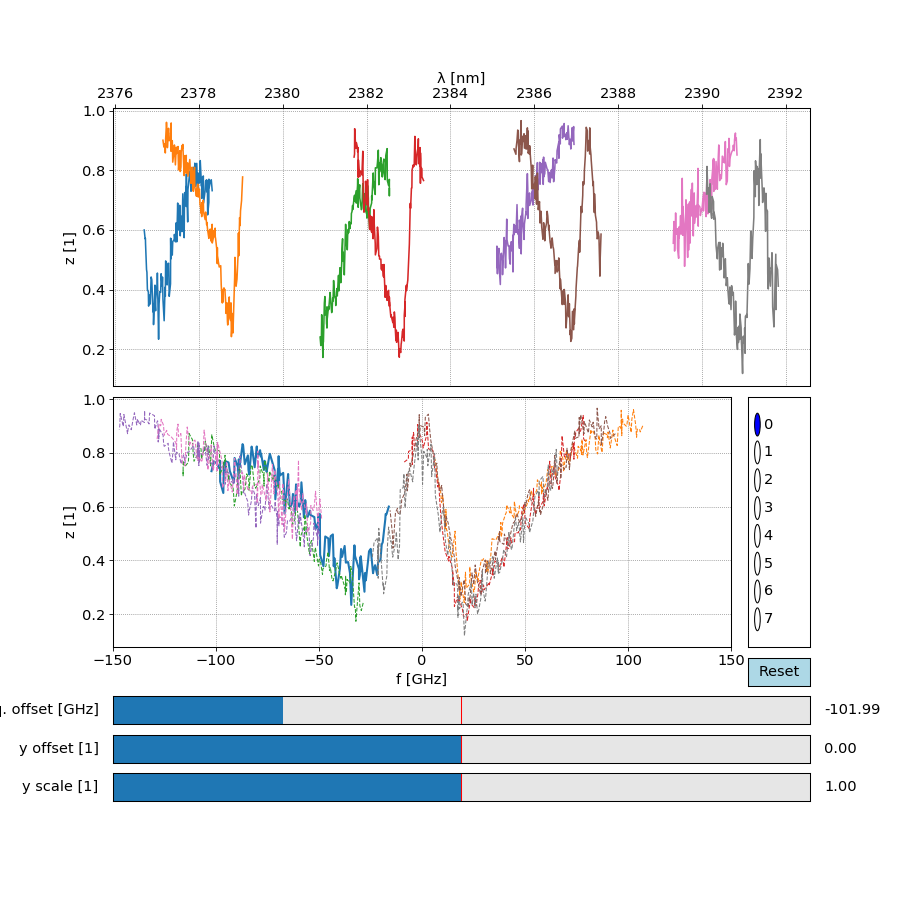

0

In [201]:
# align fragments of "full fringe" to collect approximation of single full fringe
fig = plt.figure(figsize=(12,12))
d = ds3_WB4_CH2_g400_20

flim = -150.,150.
sl_ax_color = '0.9'
button_color = 'lightblue'
global cind 
cind = 0
n_curves = len(d['z_zoom_t_min'])
curves = []
f0 = []
f_mod = []
z0 = []
z_mod = []
f_offset = np.zeros(n_curves) * u.GHz
y_offset = np.zeros(n_curves)
y_scale = np.ones(n_curves)

gs = GridSpec(6,2,height_ratios=[1,0.9,0.1,0.1,0.1,0.1],width_ratios=[1,0.1],wspace=0.05,hspace=0.1)

ax0 = fig.add_subplot(gs[0,:])
ax1 = fig.add_subplot(gs[1,0])
ax_sel = fig.add_subplot(gs[1,1])
ax_reset = fig.add_subplot(gs[2,1])
ax_fo = fig.add_subplot(gs[3,:],facecolor=sl_ax_color)
ax_yo = fig.add_subplot(gs[4,:],facecolor=sl_ax_color)
ax_ys = fig.add_subplot(gs[5,:],facecolor=sl_ax_color)


sl_fo = Slider(ax_fo, 'freq. offset [GHz]', -200., 200., valinit=0.)
sl_yo = Slider(ax_yo, 'y offset [1]', -0.5, 0.5, valinit=0.)
sl_ys = Slider(ax_ys, 'y scale [1]', 0.5, 1.5, valinit=1.)

ax0.set_ylabel('z [1]')
ax0.set_xlabel('λ [nm]')
ax0.xaxis.tick_top() 
ax0.xaxis.set_label_position('top') 
ax1.set_ylabel('z [1]')
ax1.set_xlabel('f [GHz]')
ax1.set_xlim(flim)

for ind in range(n_curves):
    z = d['z_zoom_t_min'][ind]
    z0.append(z)
    z_mod.append(z)
    ax0.plot(d['λ_zoom_t_min'][ind],z)
    f_abs = d['λ_zoom_t_min'][ind].to(u.GHz,'sp')
    f_rel = f_abs - f_abs.min()
    f0.append(f_rel)
    f_mod.append(f_rel)
    curves.append(ax1.plot(f_rel,z,color='C'+str(ind),ls='--',lw=1)[0])
    

def update(val):
    cind = int(rad_sel.value_selected)
    cc = curves[cind]
    fo = sl_fo.val
    yo = sl_yo.val
    ys = sl_ys.val
    f_offset[cind] = fo * u.GHz
    y_offset[cind] = yo
    y_scale[cind] = ys
    ff = f0[cind].m + fo
    yy0 = z0[cind].max() + yo
    yy_rel = (z0[cind] - z0[cind].max()) * ys
    yy = yy0 + yy_rel
    f_mod[cind] = ff * u.GHz
    z_mod[cind] = yy
    cc.set_xdata(ff)
    cc.set_ydata(yy)
    fig.canvas.draw_idle()
#     fig.canvas.draw()
#     fig.canvas.flush_events()

sl_fo.on_changed(update)
sl_yo.on_changed(update)
sl_ys.on_changed(update)


reset_button = Button(ax_reset, 'Reset', color=button_color, hovercolor='0.975')


def reset(event):
    sl_fo.reset()
    sl_yo.reset()
    sl_ys.reset()
reset_button.on_clicked(reset)


rad_sel = RadioButtons(ax_sel, [str(j) for j in range(n_curves)], active=0)


def select_curve(label):
    cind = int(label)
    for cc in curves[:cind]:
        cc.set_ls('--')
        cc.set_lw(1.0)
    for cc in curves[cind+1:]:
        cc.set_ls('--')
        cc.set_lw(1.0)
    cc = curves[cind]
    cc.set_ls('-')
    cc.set_lw(2.0)
    sl_fo.set_val(f_offset[cind].m)
    sl_yo.set_val(y_offset[cind])
    sl_ys.set_val(y_scale[cind])
    fig.canvas.draw_idle()
rad_sel.on_clicked(select_curve)
    

In [219]:
# add fragment alignment data to dataset dictionary
d['f0'] = f0
d['f_mod'] = f_mod 
d['z0'] = z0 
d['z_mod'] = z_mod 
d['f_offset'] = f_offset 
d['y_offset'] = y_offset 
d['y_scale'] = y_scale 
f_mod_tot = np.hstack(f_mod)
z_mod_tot = np.hstack(z_mod)
d['f_mod_tot'] = f_mod_tot
d['z_mod_tot'] = z_mod_tot

<IPython.core.display.Javascript object>


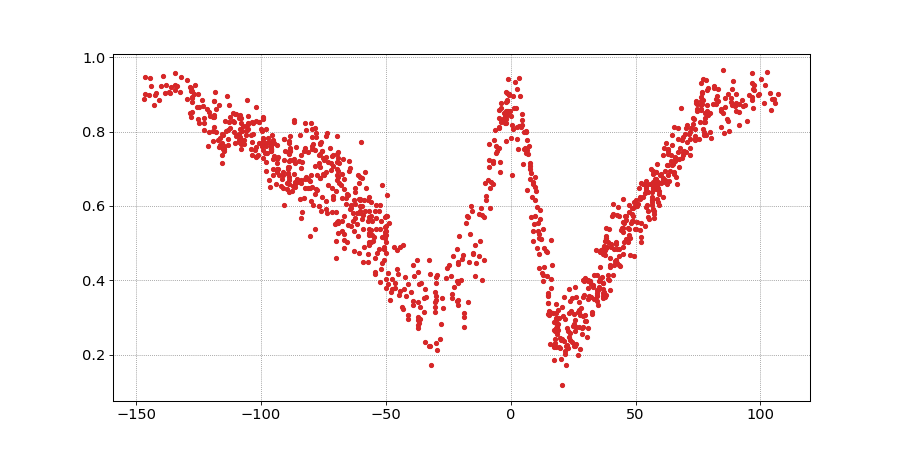

In [215]:
# plot combined fragment data as one lineshape
f_mod_tot = np.hstack(f_mod)
z_mod_tot = np.hstack(z_mod)
fig,ax = plt.subplots(figsize=(12,6))
ax.plot(f_mod_tot,z_mod_tot,'C3.')

In [220]:
# save processing and alignment data as pickled dictionary alongside raw data for future use
ds3_WB4_CH2_g400_20_proc = {}
keys = ['pts', 'λ_zoom_t_min', 'z_zoom_t_min', 'λ_min_zoom_vs_t', 'f0', 'f_mod', 'z0', 'z_mod', 'f_offset', 'y_offset', 'y_scale','f_mod_tot','z_mod_tot']

for kk in keys:
    ds3_WB4_CH2_g400_20_proc[kk] = d[kk]

fpath_ds3_WB4_CH2_g400_20_proc = path.join(default_data_dir,'OPO_data_proc_ds3_V2_WB4_CH2_w800_g400_T20_hires_2019_02_19_03_23_42.dat')
with open(fpath_ds3_WB4_CH2_g400_20_proc, 'wb') as f:
    pickle.dump(ds3_WB4_CH2_g400_20_proc, f, protocol=pickle.HIGHEST_PROTOCOL)


In [13]:
# load processed data
fpath_ds3_WB4_CH2_g400_20_proc = path.join(default_data_dir,'OPO_data_proc_ds3_V2_WB4_CH2_w800_g400_T20_hires_2019_02_19_03_23_42.dat')
with open(fpath_ds3_WB4_CH2_g400_20_proc, 'rb') as handle:
    ds3_WB4_CH2_g400_20_proc_reload = pickle.load(handle)
#    ds3_WB4_CH4_g300_20_proc = pickle.load(handle)

f_g400 = ds3_WB4_CH2_g400_20_proc_reload['f_mod_tot']
T_min_g400 = ds3_WB4_CH2_g400_20_proc_reload['z_mod_tot']

## Analysis of g300 data

<IPython.core.display.Javascript object>


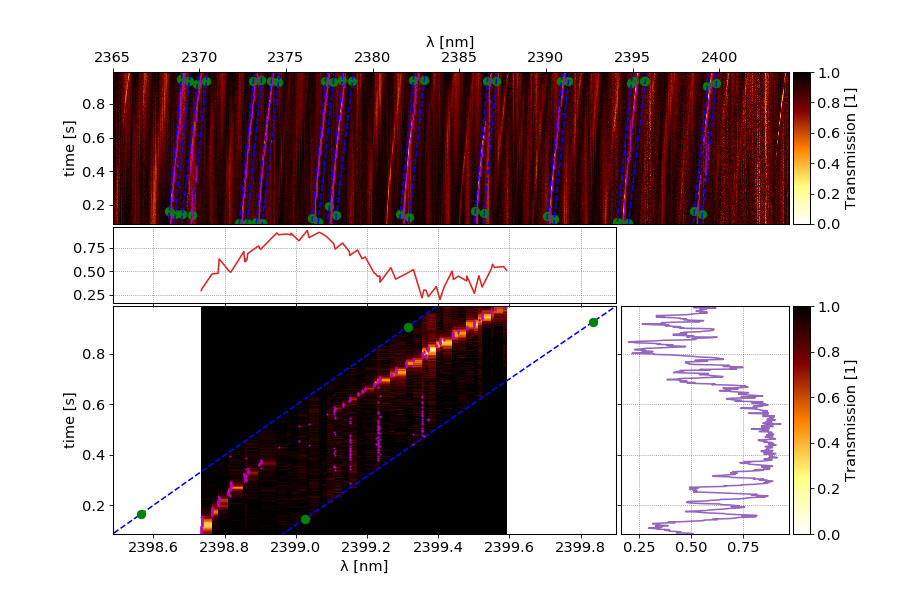

In [250]:
# pick out diagonal regions of 2D tuning with nice resonance data
d = ds3_WB4_CH4_g300_20
t = d['t']
c_full = cm.afmhot_r # cm.gist_heat_r
c_zoom = cm.bone_r
#λ_lim = 2375,2395 #d['λ'].min().to(u.nm).m,d['λ'].max().to(u.nm).m
λ_lim = 2365,2404 
#λ_lim = 2383,2384.1
#λ_lim = 2386.,2388. # x limits in nm
#λ_lim = 2384.,2390. # x limits in nm
t_lim = 0.085,d['t'].max().m
vmax = 1
vmin = 0
recalc_model = True

#f = d['λ'].to(u.THz,'sp')
λ = d['λ'].to(u.nm)
ref = d['V_ref_24']
T = d['V_trans_24'] - 290.3 * u.mV #(d['V_trans_24'] - 286.7 * u.mV) / ref

λ_mask = (λ.m<λ_lim[1])*(λ.m>λ_lim[0])
t_mask = (t.m<t_lim[1])*(t.m>t_lim[0])
ref_max = ref[t_mask,:][:,λ_mask].max()
ref_rel = ref / ref_max
T_max = T[t_mask,:][:,λ_mask].max()

λ = λ[λ_mask]
t = t[t_mask]
T = T[t_mask,:][:,λ_mask]
#z_full = T.m /T.max().m
z_full = T /T.max(axis=0)
z = T.m



fig = plt.figure(figsize=(12,8))

gs = GridSpec(3,3,width_ratios=(30,10,1),height_ratios=(2,1,3),hspace=0.02,wspace=0.02)
ax_full = fig.add_subplot(gs[0,:2])
ax_zoom = fig.add_subplot(gs[2,0])
ax_zoom_t_int = fig.add_subplot(gs[1,0])
ax_zoom_λ_int = fig.add_subplot(gs[2,1])
cb_ax_full = fig.add_subplot(gs[0,2])
cb_ax_zoom = fig.add_subplot(gs[2,2])


p_full = ax_full.pcolormesh(λ,t,z_full,vmin=vmin,vmax=vmax,cmap=c_full)

λ_zoom=λ
z_zoom = z_full
z_zoom_min_t = z_zoom.min(axis=0)
z_zoom_min_λ = z_zoom.min(axis=1)
ax_zoom_t_int.plot(λ_zoom,z_zoom_min_t,'C3')
ax_zoom_λ_int.plot(z_zoom_min_λ,t,'C4')
p_zoom = ax_zoom.pcolormesh(λ_zoom,t,z_zoom,vmin=vmin,vmax=vmax,cmap=c_full)
plt.colorbar(p_zoom,label='Transmission [1]',cax=cb_ax_zoom)
ax_zoom.set_xlim(λ_lim)
ax_zoom.set_ylim(t_lim)



ax_zoom_t_int.set_xticklabels([])
ax_zoom_λ_int.set_yticklabels([])
ax_zoom.set_ylabel('time [s]')
ax_zoom.set_xlabel('λ [nm]')

ax_full.set_xlim(λ_lim)
ax_full.set_ylim(t_lim)
ax_full.set_ylabel('time [s]')
ax_full.set_xlabel('λ [nm]')
ax_full.xaxis.tick_top() 
ax_full.xaxis.set_label_position('top') 

#     ax2 = lm2f_twiny_offset(ax_model_T_int,offset=ax_expt.get_xlim()[1],units='GHz',w=3,p=1)
#     ax2.grid('off')
plt.colorbar(p_full,label='Transmission [1]',cax=cb_ax_full)
pts = []
λ_zoom_t_min = []
z_zoom_t_min = []
λ_min_zoom_vs_t = []
z_zoom_store = []

def onclick(event):
    if event.button == 1:
        pts.append([event.xdata,event.ydata])
        #print(f'x: {event.xdata:3.3f}, y: {event.ydata:3.3f}')
        ax_full.plot(event.xdata,event.ydata,'go')
        plt.draw()
    elif event.button == 3:
#         normalize_slice(z,pts,z_zoom_t_min,λ_zoom_t_min,ax_full,ax_zoom,ax_zoom_t_int,
#                         ax_zoom_λ_int,cb_ax_zoom,vmin=0,vmax=1)
        #ax_full.plot(event.xdata,event.ydata,'bo')
        u_p0 = pts[-4]
        u_p1 = pts[-3]
        m_u = (u_p1[1] - u_p0[1])/(u_p1[0] - u_p0[0])
        b_u = u_p0[1] - m_u * u_p0[0]

        l_p0 = pts[-2]
        l_p1 = pts[-1]
        m_l = (l_p1[1] - l_p0[1])/(l_p1[0] - l_p0[0])
        b_l = l_p0[1] - m_l * l_p0[0]
        λ_zoom_lim = (t_lim[0]-b_u)/m_u, (t_lim[1]-b_l)/m_l
        λ_zoom_mask = (λ.m<λ_zoom_lim[1])*(λ.m>λ_zoom_lim[0])
        λ_zoom = λ[λ_zoom_mask]
        T_zoom = T[:,λ_zoom_mask]
        z_zoom = T_zoom.m

        bg_u = m_u * λ_zoom.m + b_u
        bg_l = m_l * λ_zoom.m + b_l
#         ax_full.plot(λ_zoom,bg_u,'b--')
#         ax_full.plot(λ_zoom,bg_l,'b--')
#         plt.draw()
        # now find values at points closest to these lines
        z_norm_l = np.zeros(len(λ_zoom))
        z_norm_u = np.zeros(len(λ_zoom))
        z_norm = np.zeros(len(λ_zoom))
        tind_norm_u = np.zeros(len(λ_zoom),dtype=np.int)
        tind_norm_l = np.zeros(len(λ_zoom),dtype=np.int)
        for lind,ll in enumerate(λ_zoom):
            t_norm_u = m_u * ll.m + b_u
            t_norm_l = m_l * ll.m + b_l
            tind_norm_u[lind] = np.argmin(np.abs(t.m-t_norm_u))
            tind_norm_l[lind] = np.argmin(np.abs(t.m-t_norm_l))
            z_norm_u[lind] = T_zoom[tind_norm_u[lind],lind].m
            z_norm_l[lind] = T_zoom[tind_norm_l[lind],lind].m
            z_norm[lind] = np.max((z_norm_u[lind],z_norm_l[lind]))
            z_zoom[:,lind] = z_zoom[:,lind] / (z_norm[lind]*np.ones(len(t)))

        # mask selected region and locally process data
        λ_mesh,t_mesh = np.meshgrid(λ_zoom.m,t.m)
        mask = (m_u*λ_mesh+b_u > t_mesh) * (m_l*λ_mesh+b_l < t_mesh)
        not_mask = (m_u*λ_mesh+b_u < t_mesh) + (m_l*λ_mesh+b_l > t_mesh)
        z_zoom = z_zoom*mask + np.ones(z_zoom.shape)*not_mask
        λ_zoom_old = λ_zoom
        z_zoom_old = z_zoom
        z_zoom_store.append(z_zoom)
        λ_min_zoom_vs_t.append(λ_zoom_old[np.argmin(z_zoom,axis=1)]) # λ values where min over λ occurs for each t val
        λ_zoom_cutoff_mask = (λ_zoom_old >= λ_min_zoom_vs_t[-1][0]) * (λ_zoom_old <= λ_min_zoom_vs_t[-1][-1])
        # this cut λ values for which resonance was not observed at any t out of zoomed dataset
        λ_zoom = λ_zoom_old[λ_zoom_cutoff_mask]
        z_zoom = z_zoom_old[:,λ_zoom_cutoff_mask]
        z_zoom_min_t = z_zoom.min(axis=0)
        z_zoom_min_λ = z_zoom.min(axis=1)
        ax_zoom_t_int.clear()
        ax_zoom_t_int.plot(λ_zoom,z_zoom_min_t,'C3')
        ax_zoom_t_int.set_xlim(λ_zoom_lim)
        ax_zoom_t_int.set_xticklabels([])
        ax_zoom_λ_int.clear()
        ax_zoom_λ_int.plot(z_zoom_min_λ,t,'C4')
        ax_zoom_λ_int.set_ylim(t_lim)
        ax_zoom_λ_int.set_yticklabels([])
        λ_zoom_t_min.append(λ_zoom)
        z_zoom_t_min.append(z_zoom_min_t)
        
        # save selected region and locally processed data to dataset
        d['pts'] = pts
        d['λ_zoom_t_min'] = λ_zoom_t_min
        d['z_zoom_t_min'] = z_zoom_t_min
        d['λ_min_zoom_vs_t'] = λ_min_zoom_vs_t
        
        # plot selected region and locally processed data
        ax_zoom.clear()
        p_zoom = ax_zoom.pcolormesh(λ_zoom,t,z_zoom,vmin=vmin,vmax=vmax,cmap=c_full)
        ax_zoom.plot(λ_zoom_old,bg_u,'b--')
        ax_zoom.plot(u_p0[0],u_p0[1],'go')
        ax_zoom.plot(u_p1[0],u_p1[1],'go')
        ax_zoom.plot(λ_zoom_old,bg_l,'b--')
        ax_zoom.plot(l_p0[0],l_p0[1],'go')
        ax_zoom.plot(l_p1[0],l_p1[1],'go')
        ax_zoom.set_xlim(λ_zoom_lim)
        ax_zoom.set_ylim(t_lim)
        ax_zoom.plot(λ_min_zoom_vs_t[-1],t,'m.',ms=2)
        ax_zoom.set_ylabel('time [s]')
        ax_zoom.set_xlabel('λ [nm]')
        plt.sca(ax_full) #
        ax_full.plot(λ_zoom_old,bg_u,'b--')
        ax_full.plot(λ_zoom_old,bg_l,'b--')
        ax_full.plot(λ_min_zoom_vs_t[-1],t,'m.',ms=0.5)
        #plt.colorbar(p_zoom,label='Transmission [1]',cax=cb_ax_zoom)
        plt.draw()
        fig.canvas.flush_events()
    else:
        pass # Do nothing


fig.canvas.mpl_connect('button_press_event', onclick)
fig.show()

<IPython.core.display.Javascript object>


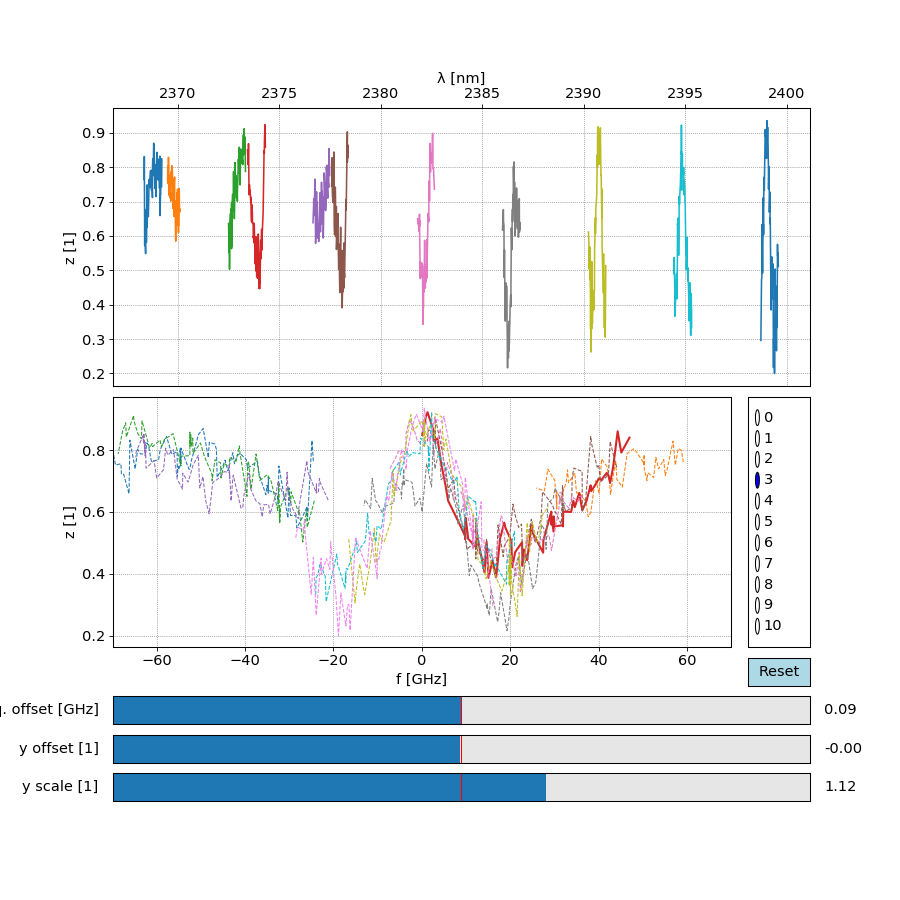

0

In [255]:
# align fragments of "full fringe" to collect approximation of single full fringe
fig = plt.figure(figsize=(12,12))
#d = ds3_WB4_CH4_g300_20

colors = ['C'+str(ind) for ind in range(10)]
colors += ['violet','lightblue']

flim = -70.,70.
sl_ax_color = '0.9'
button_color = 'lightblue'
global cind 
cind = 0
n_curves = len(d['z_zoom_t_min'])
curves = []
f0 = []
f_mod = []
z0 = []
z_mod = []
f_offset = np.zeros(n_curves) * u.GHz
y_offset = np.zeros(n_curves)
y_scale = np.ones(n_curves)

gs = GridSpec(6,2,height_ratios=[1,0.9,0.1,0.1,0.1,0.1],width_ratios=[1,0.1],wspace=0.05,hspace=0.1)

ax0 = fig.add_subplot(gs[0,:])
ax1 = fig.add_subplot(gs[1,0])
ax_sel = fig.add_subplot(gs[1,1])
ax_reset = fig.add_subplot(gs[2,1])
ax_fo = fig.add_subplot(gs[3,:],facecolor=sl_ax_color)
ax_yo = fig.add_subplot(gs[4,:],facecolor=sl_ax_color)
ax_ys = fig.add_subplot(gs[5,:],facecolor=sl_ax_color)


sl_fo = Slider(ax_fo, 'freq. offset [GHz]', -200., 200., valinit=0.)
sl_yo = Slider(ax_yo, 'y offset [1]', -0.5, 0.5, valinit=0.)
sl_ys = Slider(ax_ys, 'y scale [1]', 0.5, 1.5, valinit=1.)

ax0.set_ylabel('z [1]')
ax0.set_xlabel('λ [nm]')
ax0.xaxis.tick_top() 
ax0.xaxis.set_label_position('top') 
ax1.set_ylabel('z [1]')
ax1.set_xlabel('f [GHz]')
ax1.set_xlim(flim)

for ind in range(n_curves):
    z = d['z_zoom_t_min'][ind]
    z0.append(z)
    z_mod.append(z)
    ax0.plot(d['λ_zoom_t_min'][ind],z,color=colors[ind])
    f_abs = d['λ_zoom_t_min'][ind].to(u.GHz,'sp')
    f_rel = f_abs - f_abs.min()
    f0.append(f_rel)
    f_mod.append(f_rel)
    curves.append(ax1.plot(f_rel,z,color=colors[ind],ls='--',lw=1)[0])
    

def update(val):
    cind = int(rad_sel.value_selected)
    cc = curves[cind]
    fo = sl_fo.val
    yo = sl_yo.val
    ys = sl_ys.val
    f_offset[cind] = fo * u.GHz
    y_offset[cind] = yo
    y_scale[cind] = ys
    ff = f0[cind].m + fo
    yy0 = z0[cind].max() + yo
    yy_rel = (z0[cind] - z0[cind].max()) * ys
    yy = yy0 + yy_rel
    f_mod[cind] = ff * u.GHz
    z_mod[cind] = yy
    cc.set_xdata(ff)
    cc.set_ydata(yy)
    fig.canvas.draw_idle()
#     fig.canvas.draw()
#     fig.canvas.flush_events()

sl_fo.on_changed(update)
sl_yo.on_changed(update)
sl_ys.on_changed(update)


reset_button = Button(ax_reset, 'Reset', color=button_color, hovercolor='0.975')


def reset(event):
    sl_fo.reset()
    sl_yo.reset()
    sl_ys.reset()
reset_button.on_clicked(reset)


rad_sel = RadioButtons(ax_sel, [str(j) for j in range(n_curves)], active=0)


def select_curve(label):
    cind = int(label)
    for cc in curves[:cind]:
        cc.set_ls('--')
        cc.set_lw(1.0)
    for cc in curves[cind+1:]:
        cc.set_ls('--')
        cc.set_lw(1.0)
    cc = curves[cind]
    cc.set_ls('-')
    cc.set_lw(2.0)
    sl_fo.set_val(f_offset[cind].m)
    sl_yo.set_val(y_offset[cind])
    sl_ys.set_val(y_scale[cind])
    fig.canvas.draw_idle()
rad_sel.on_clicked(select_curve)

In [256]:
# add fragment alignment data to dataset dictionary
d['f0'] = f0
d['f_mod'] = f_mod 
d['z0'] = z0 
d['z_mod'] = z_mod 
d['f_offset'] = f_offset 
d['y_offset'] = y_offset 
d['y_scale'] = y_scale 
f_mod_tot = np.hstack(f_mod)
z_mod_tot = np.hstack(z_mod)
d['f_mod_tot'] = f_mod_tot
d['z_mod_tot'] = z_mod_tot

<IPython.core.display.Javascript object>


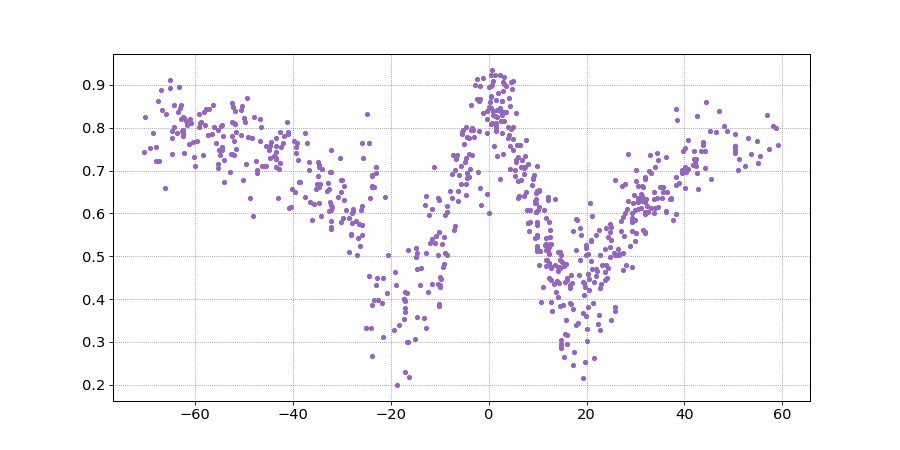

In [257]:
# plot combined fragment data as one lineshape
f_mod_tot = np.hstack(f_mod)
z_mod_tot = np.hstack(z_mod)
fig,ax = plt.subplots(figsize=(12,6))
ax.plot(f_mod_tot,z_mod_tot,'C4.')

In [258]:
# save processing and alignment data as pickled dictionary alongside raw data for future use
ds3_WB4_CH4_g300_20_proc = {}
keys = ['pts', 'λ_zoom_t_min', 'z_zoom_t_min', 'λ_min_zoom_vs_t', 'f0', 'f_mod', 'z0', 'z_mod', 'f_offset', 'y_offset', 'y_scale','f_mod_tot','z_mod_tot']

for kk in keys:
    ds3_WB4_CH4_g300_20_proc[kk] = d[kk]

fpath_ds3_WB4_CH4_g300_20_proc = path.join(default_data_dir,'OPO_data_proc_ds3_V2_WB1_CH2_w800_g300_wb4_ch4_T20_2019_02_18_15_54_45.dat')
with open(fpath_ds3_WB4_CH4_g300_20_proc, 'wb') as f:
    pickle.dump(ds3_WB4_CH4_g300_20_proc, f, protocol=pickle.HIGHEST_PROTOCOL)


In [14]:
# load processed data
fpath_ds3_WB4_CH4_g300_20_proc = path.join(default_data_dir,'OPO_data_proc_ds3_V2_WB1_CH2_w800_g300_wb4_ch4_T20_2019_02_18_15_54_45.dat')
with open(fpath_ds3_WB4_CH4_g300_20_proc, 'rb') as handle:
    ds3_WB4_CH4_g300_20_proc_reload = pickle.load(handle)
#    ds3_WB4_CH4_g300_20_proc = pickle.load(handle)

f_g300 = ds3_WB4_CH4_g300_20_proc_reload['f_mod_tot']
T_min_g300 = ds3_WB4_CH4_g300_20_proc_reload['z_mod_tot']

## Analysis of g200 data

<IPython.core.display.Javascript object>


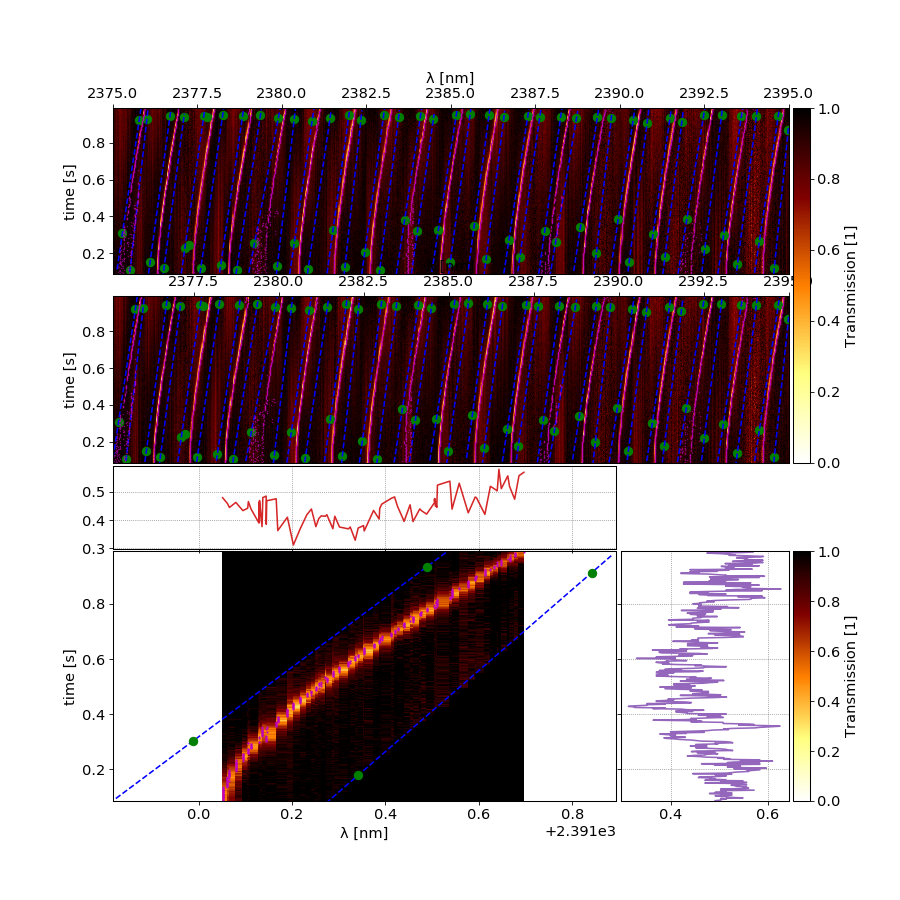

In [311]:
# pick out diagonal regions of 2D tuning with nice resonance data
#d = ds3_WB4_unmarked_flattened_g200_20
d = ds3_WB4_unmarked_flattened_g200_20_new_bg
t = d['t']
c_full = cm.afmhot_r # cm.gist_heat_r
c_zoom = cm.bone_r
λ_lim = 2375,2395 #d['λ'].min().to(u.nm).m,d['λ'].max().to(u.nm).m
#λ_lim = 2340,2405 
#λ_lim = 2383,2384.1
#λ_lim = 2386.,2388. # x limits in nm
#λ_lim = 2384.,2390. # x limits in nm
t_lim = 0.085,d['t'].max().m
vmax = 1
vmin = 0
recalc_model = True

#f = d['λ'].to(u.THz,'sp')
λ = d['λ'].to(u.nm)
ref = d['V_ref_24']
T = d['V_trans_24'] - 290.3 * u.mV #(d['V_trans_24'] - 286.7 * u.mV) / ref

λ_mask = (λ.m<λ_lim[1])*(λ.m>λ_lim[0])
t_mask = (t.m<t_lim[1])*(t.m>t_lim[0])
ref_max = ref[t_mask,:][:,λ_mask].max()
ref_rel = ref / ref_max
T_max = T[t_mask,:][:,λ_mask].max()

λ = λ[λ_mask]
t = t[t_mask]
T = T[t_mask,:][:,λ_mask]
#z_full = T.m /T.max().m
z_full = T /T.max(axis=0)
z = T.m



fig = plt.figure(figsize=(12,12))

gs = GridSpec(5,3,width_ratios=(30,10,1),height_ratios=(2,0.2,2,1,3),hspace=0.02,wspace=0.02)
ax_full = fig.add_subplot(gs[0,:2])
ax_partial = fig.add_subplot(gs[2,:2])
ax_zoom = fig.add_subplot(gs[4,0])
ax_zoom_t_int = fig.add_subplot(gs[3,0])
ax_zoom_λ_int = fig.add_subplot(gs[4,1])
cb_ax_full = fig.add_subplot(gs[:3,2])
cb_ax_zoom = fig.add_subplot(gs[4,2])

def onselect_full(xmin, xmax):
    ax_partial.set_xlim((xmin,xmax))
    fig.canvas.draw()

# Set useblit=True on most backends for enhanced performance.
partial_span = SpanSelector(ax_full, onselect_full, 'horizontal', useblit=True,
                    rectprops=dict(alpha=0.5, facecolor='blue'))

p_full = ax_full.pcolormesh(λ,t,z_full,vmin=vmin,vmax=vmax,cmap=c_full)
p_partial = ax_partial.pcolormesh(λ,t,z_full,vmin=vmin,vmax=vmax,cmap=c_full)

λ_zoom=λ
z_zoom = z_full
z_zoom_min_t = z_zoom.min(axis=0)
z_zoom_min_λ = z_zoom.min(axis=1)
ax_zoom_t_int.plot(λ_zoom,z_zoom_min_t,'C3')
ax_zoom_λ_int.plot(z_zoom_min_λ,t,'C4')
p_zoom = ax_zoom.pcolormesh(λ_zoom,t,z_zoom,vmin=vmin,vmax=vmax,cmap=c_full)
plt.colorbar(p_zoom,label='Transmission [1]',cax=cb_ax_zoom)
ax_zoom.set_xlim(λ_lim)
ax_zoom.set_ylim(t_lim)



ax_zoom_t_int.set_xticklabels([])
ax_zoom_λ_int.set_yticklabels([])
ax_zoom.set_ylabel('time [s]')
ax_zoom.set_xlabel('λ [nm]')

for aa in [ax_full,ax_partial]:
    aa.set_xlim(λ_lim)
    aa.set_ylim(t_lim)
    aa.set_ylabel('time [s]')
    aa.set_xlabel('λ [nm]')
    aa.xaxis.tick_top() 
    aa.xaxis.set_label_position('top') 

#     ax2 = lm2f_twiny_offset(ax_model_T_int,offset=ax_expt.get_xlim()[1],units='GHz',w=3,p=1)
#     ax2.grid('off')
plt.colorbar(p_full,label='Transmission [1]',cax=cb_ax_full)
pts = []
λ_zoom_t_min = []
z_zoom_t_min = []
λ_min_zoom_vs_t = []
z_zoom_store = []

def onclick(event):
    if event.inaxes==ax_partial:
        if event.button == 1:
            pts.append([event.xdata,event.ydata])
            #print(f'x: {event.xdata:3.3f}, y: {event.ydata:3.3f}')
            for aa in [ax_full,ax_partial]:
                aa.plot(event.xdata,event.ydata,'go')
            plt.draw()
        elif event.button == 3:
    #         normalize_slice(z,pts,z_zoom_t_min,λ_zoom_t_min,ax_full,ax_zoom,ax_zoom_t_int,
    #                         ax_zoom_λ_int,cb_ax_zoom,vmin=0,vmax=1)
            #ax_full.plot(event.xdata,event.ydata,'bo') 
            u_p0 = pts[-4]
            u_p1 = pts[-3]
            m_u = (u_p1[1] - u_p0[1])/(u_p1[0] - u_p0[0])
            b_u = u_p0[1] - m_u * u_p0[0]

            l_p0 = pts[-2]
            l_p1 = pts[-1]
            m_l = (l_p1[1] - l_p0[1])/(l_p1[0] - l_p0[0])
            b_l = l_p0[1] - m_l * l_p0[0]
            λ_zoom_lim = (t_lim[0]-b_u)/m_u, (t_lim[1]-b_l)/m_l
            λ_zoom_mask = (λ.m<λ_zoom_lim[1])*(λ.m>λ_zoom_lim[0])
            λ_zoom = λ[λ_zoom_mask]
            T_zoom = T[:,λ_zoom_mask]
            z_zoom = T_zoom.m

            bg_u = m_u * λ_zoom.m + b_u
            bg_l = m_l * λ_zoom.m + b_l
    #         ax_full.plot(λ_zoom,bg_u,'b--')
    #         ax_full.plot(λ_zoom,bg_l,'b--')
    #         plt.draw()
            # now find values at points closest to these lines
            z_norm_l = np.zeros(len(λ_zoom))
            z_norm_u = np.zeros(len(λ_zoom))
            z_norm = np.zeros(len(λ_zoom))
            tind_norm_u = np.zeros(len(λ_zoom),dtype=np.int)
            tind_norm_l = np.zeros(len(λ_zoom),dtype=np.int)
            for lind,ll in enumerate(λ_zoom):
                t_norm_u = m_u * ll.m + b_u
                t_norm_l = m_l * ll.m + b_l
                tind_norm_u[lind] = np.argmin(np.abs(t.m-t_norm_u))
                tind_norm_l[lind] = np.argmin(np.abs(t.m-t_norm_l))
                z_norm_u[lind] = T_zoom[tind_norm_u[lind],lind].m
                z_norm_l[lind] = T_zoom[tind_norm_l[lind],lind].m
                z_norm[lind] = np.max((z_norm_u[lind],z_norm_l[lind]))
                z_zoom[:,lind] = z_zoom[:,lind] / (z_norm[lind]*np.ones(len(t)))

            # mask selected region and locally process data
            λ_mesh,t_mesh = np.meshgrid(λ_zoom.m,t.m)
            mask = (m_u*λ_mesh+b_u > t_mesh) * (m_l*λ_mesh+b_l < t_mesh)
            not_mask = (m_u*λ_mesh+b_u < t_mesh) + (m_l*λ_mesh+b_l > t_mesh)
            z_zoom = z_zoom*mask + np.ones(z_zoom.shape)*not_mask
            λ_zoom_old = λ_zoom
            z_zoom_old = z_zoom
            z_zoom_store.append(z_zoom)
            λ_min_zoom_vs_t.append(λ_zoom_old[np.argmin(z_zoom,axis=1)]) # λ values where min over λ occurs for each t val
            λ_zoom_cutoff_mask = (λ_zoom_old >= λ_min_zoom_vs_t[-1][0]) * (λ_zoom_old <= λ_min_zoom_vs_t[-1][-1])
            # this cut λ values for which resonance was not observed at any t out of zoomed dataset
            λ_zoom = λ_zoom_old[λ_zoom_cutoff_mask]
            z_zoom = z_zoom_old[:,λ_zoom_cutoff_mask]
            z_zoom_min_t = z_zoom.min(axis=0)
            z_zoom_min_λ = z_zoom.min(axis=1)
            ax_zoom_t_int.clear()
            ax_zoom_t_int.plot(λ_zoom,z_zoom_min_t,'C3')
            ax_zoom_t_int.set_xlim(λ_zoom_lim)
            ax_zoom_t_int.set_xticklabels([])
            ax_zoom_λ_int.clear()
            ax_zoom_λ_int.plot(z_zoom_min_λ,t,'C4')
            ax_zoom_λ_int.set_ylim(t_lim)
            ax_zoom_λ_int.set_yticklabels([])
            λ_zoom_t_min.append(λ_zoom)
            z_zoom_t_min.append(z_zoom_min_t)

            # save selected region and locally processed data to dataset
            d['pts'] = pts
            d['λ_zoom_t_min'] = λ_zoom_t_min
            d['z_zoom_t_min'] = z_zoom_t_min
            d['λ_min_zoom_vs_t'] = λ_min_zoom_vs_t

            # plot selected region and locally processed data
            ax_zoom.clear()
            p_zoom = ax_zoom.pcolormesh(λ_zoom,t,z_zoom,vmin=vmin,vmax=vmax,cmap=c_full)
            ax_zoom.plot(λ_zoom_old,bg_u,'b--')
            ax_zoom.plot(u_p0[0],u_p0[1],'go')
            ax_zoom.plot(u_p1[0],u_p1[1],'go')
            ax_zoom.plot(λ_zoom_old,bg_l,'b--')
            ax_zoom.plot(l_p0[0],l_p0[1],'go')
            ax_zoom.plot(l_p1[0],l_p1[1],'go')
            ax_zoom.set_xlim(λ_zoom_lim)
            ax_zoom.set_ylim(t_lim)
            ax_zoom.plot(λ_min_zoom_vs_t[-1],t,'m.',ms=2)
            ax_zoom.set_ylabel('time [s]')
            ax_zoom.set_xlabel('λ [nm]')
            plt.sca(ax_full) #
            ax_full.plot(λ_zoom_old,bg_u,'b--')
            ax_full.plot(λ_zoom_old,bg_l,'b--')
            ax_full.plot(λ_min_zoom_vs_t[-1],t,'m.',ms=0.5)
            plt.sca(ax_partial)
            ax_partial.plot(λ_zoom_old,bg_u,'b--')
            ax_partial.plot(λ_zoom_old,bg_l,'b--')
            ax_partial.plot(λ_min_zoom_vs_t[-1],t,'m.',ms=0.5)
            #plt.colorbar(p_zoom,label='Transmission [1]',cax=cb_ax_zoom)
            plt.draw()
            fig.canvas.flush_events()
        else:
            pass # Do nothing


fig.canvas.mpl_connect('button_press_event', onclick)
fig.show()

<IPython.core.display.Javascript object>


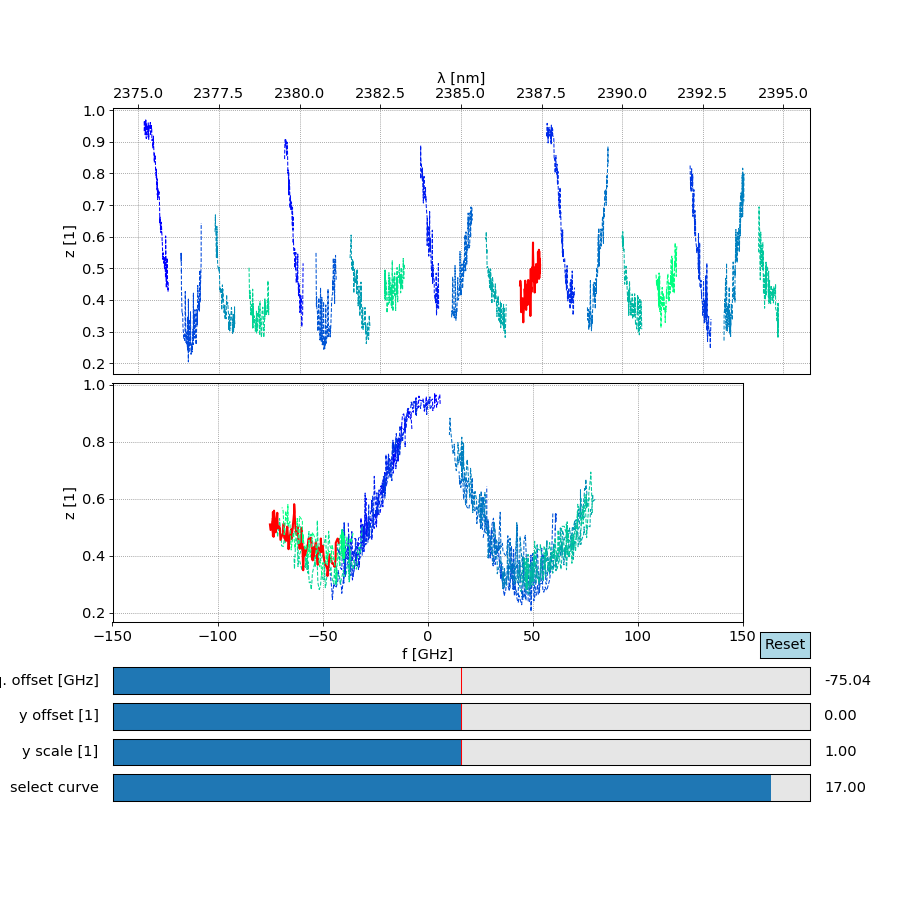

0

In [312]:
# align fragments of "full fringe" to collect approximation of single full fringe
fig = plt.figure(figsize=(12,12))
#d = ds3_WB4_CH4_g300_20

colors = ['C'+str(ind) for ind in range(10)]
colors += ['violet','lightblue']

flim = -150.,150.
sl_ax_color = '0.9'
button_color = 'lightblue'
global cind 
cind = 0
n_curves = len(d['z_zoom_t_min'])
curves = []
curves_f0 = []
f0 = []
f_mod = []
z0 = []
z_mod = []
f_offset = np.zeros(n_curves) * u.GHz
y_offset = np.zeros(n_curves)
y_scale = np.ones(n_curves)

# color=cmap(norm(TT.m))

cmap = cm.winter
norm = Normalize(0,n_curves-1)
sm = cm.ScalarMappable(norm, cmap)
sm.set_array([]) # You have to set a dummy-array for this to work...

gs = GridSpec(7,2,height_ratios=[1,0.9,0.1,0.1,0.1,0.1,0.1],
                width_ratios=[1,0.08],wspace=0.05,hspace=0.1)

ax0 = fig.add_subplot(gs[0,:])
ax1 = fig.add_subplot(gs[1,0])
# ax_sel = fig.add_subplot(gs[1,1])
# ax_sel1 = fig.add_subplot(gs[1,2])
# ax_sel2 = fig.add_subplot(gs[1,3])
# ax_sel3 = fig.add_subplot(gs[1,4])
ax_reset = fig.add_subplot(gs[2,1])
ax_fo = fig.add_subplot(gs[3,:],facecolor=sl_ax_color)
ax_yo = fig.add_subplot(gs[4,:],facecolor=sl_ax_color)
ax_ys = fig.add_subplot(gs[5,:],facecolor=sl_ax_color)
ax_sel = fig.add_subplot(gs[6,:],facecolor=sl_ax_color)

sl_fo = Slider(ax_fo, 'freq. offset [GHz]', -200., 200., valinit=0.)
sl_yo = Slider(ax_yo, 'y offset [1]', -0.5, 0.5, valinit=0.)
sl_ys = Slider(ax_ys, 'y scale [1]', 0.5, 1.5, valinit=1.)
sl_sel = Slider(ax_sel, 'select curve', 0, n_curves-1, valinit=0,valstep=1)

ax0.set_ylabel('z [1]')
ax0.set_xlabel('λ [nm]')
ax0.xaxis.tick_top() 
ax0.xaxis.set_label_position('top') 
ax1.set_ylabel('z [1]')
ax1.set_xlabel('f [GHz]')
ax1.set_xlim(flim)

for ind in range(n_curves):
    z = d['z_zoom_t_min'][ind]
    z0.append(z)
    z_mod.append(z)
    curves_f0.append(ax0.plot(d['λ_zoom_t_min'][ind],z,color=cmap(norm(ind*1.0)))[0])
    f_abs = d['λ_zoom_t_min'][ind].to(u.GHz,'sp')
    f_rel = f_abs - f_abs.min()
    f0.append(f_rel)
    f_mod.append(f_rel)
    curves.append(ax1.plot(f_rel,z,color=cmap(norm(ind*1.0)))[0])
    

def update(val):
    cind = int(sl_sel.val)
    cc = curves[cind]
    fo = sl_fo.val
    yo = sl_yo.val
    ys = sl_ys.val
    f_offset[cind] = fo * u.GHz
    y_offset[cind] = yo
    y_scale[cind] = ys
    ff = f0[cind].m + fo
    yy0 = z0[cind].max() + yo
    yy_rel = (z0[cind] - z0[cind].max()) * ys
    yy = yy0 + yy_rel
    f_mod[cind] = ff * u.GHz
    z_mod[cind] = yy
    cc.set_xdata(ff)
    cc.set_ydata(yy)
    fig.canvas.draw_idle()

sl_fo.on_changed(update)
sl_yo.on_changed(update)
sl_ys.on_changed(update)


reset_button = Button(ax_reset, 'Reset', color=button_color, hovercolor='0.975')

def reset(event):
    sl_fo.reset()
    sl_yo.reset()
    sl_ys.reset()
reset_button.on_clicked(reset)

def update_sel_curve(val):
    cind = int(val)
    for ccind, cc in enumerate(curves):
        if ccind != cind:
            cc_f0 = curves_f0[ccind]
            for c in [cc,cc_f0]:
                c.set_ls('--')
                c.set_lw(1.0)
                c.set_color(cmap(norm(ccind*1.0)))
    cc = curves[cind]
    cc_f0 = curves_f0[cind]
    for c in [cc,cc_f0]:
        c.set_ls('-')
        c.set_lw(2.0)
        c.set_color('red')
#     cc.set_color('red')
#     cc.set_ls('-')
#     cc.set_lw(2.0)
    sl_fo.set_val(f_offset[cind].m)
    sl_yo.set_val(y_offset[cind])
    sl_ys.set_val(y_scale[cind])
    fig.canvas.draw_idle()

sl_sel.on_changed(update_sel_curve)


In [313]:
# add fragment alignment data to dataset dictionary
d['f0'] = f0
d['f_mod'] = f_mod 
d['z0'] = z0 
d['z_mod'] = z_mod 
d['f_offset'] = f_offset 
d['y_offset'] = y_offset 
d['y_scale'] = y_scale 
f_mod_tot = np.hstack(f_mod)
z_mod_tot = np.hstack(z_mod)
d['f_mod_tot'] = f_mod_tot
d['z_mod_tot'] = z_mod_tot

f_mod_tot1 = f_mod_tot
z_mod_tot1 = z_mod_tot
# f_mod_tot0 = f_mod_tot
# z_mod_tot0 = z_mod_tot

<IPython.core.display.Javascript object>


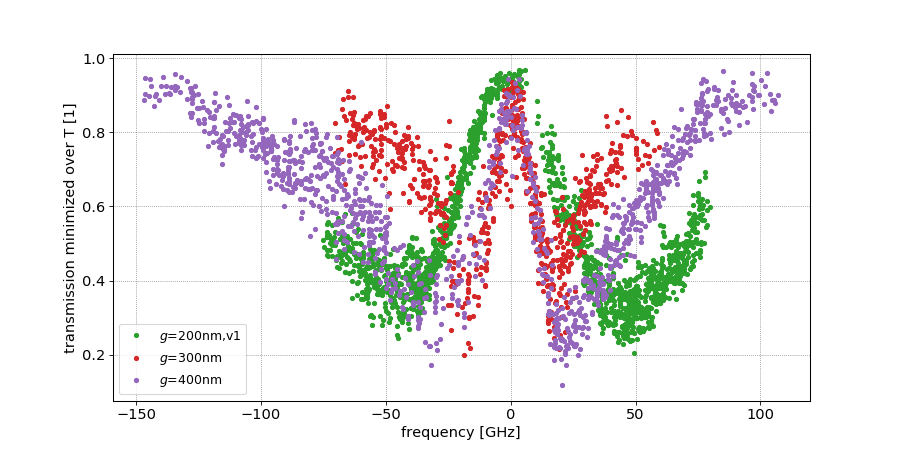

Text(0, 0.5, 'transmission minimized over T [1]')

In [181]:
# plot combined fragment data as one lineshape
fig,ax = plt.subplots(figsize=(12,6))

# f_g200_0 = f_mod_tot0
# T_min_g200_0 = z_mod_tot0

# f_g200_1 = f_mod_tot1
# T_min_g200_1 = z_mod_tot1

#ax.plot(f_g200_0,T_min_g200_0,'C5.',label='$g$=200nm,v0')
ax.plot(f_g200,T_min_g200,'C2.',label='$g$=200nm,v1')
ax.plot(f_g300,T_min_g300,'C3.',label='$g$=300nm')
ax.plot(f_g400,T_min_g400,'C4.',label='$g$=400nm')

ax.legend()
ax.set_xlabel('frequency [GHz]')
ax.set_ylabel('transmission minimized over T [1]')


In [321]:
# save processing and alignment data as pickled dictionary alongside raw data for future use
ds3_WB4_unmarked_flattened_g200_20_new_bg_proc = {}

keys = ['pts', 'λ_zoom_t_min', 'z_zoom_t_min', 'λ_min_zoom_vs_t', 'f0', 'f_mod', 'z0', 'z_mod', 'f_offset', 'y_offset', 'y_scale','f_mod_tot','z_mod_tot']

for kk in keys:
    ds3_WB4_unmarked_flattened_g200_20_new_bg_proc[kk] = d[kk]

# fpath_ds3_WB4_unmarked_flattened_g200_20_new_bg_proc = path.join(default_data_dir,'OPO_data_proc_ds3_V2_WB4_unmarked_flattened_pins_w800_g200_T20_new_bg_2019_02_20_05_26_26.dat')

fpath_ds3_WB4_unmarked_flattened_g200_20_new_bg_proc = path.join(default_data_dir,'OPO_data_proc_v1_ds3_V2_WB4_unmarked_flattened_pins_w800_g200_T20_new_bg_2019_02_20_05_26_26.dat')
with open(fpath_ds3_WB4_unmarked_flattened_g200_20_new_bg_proc, 'wb') as f:
    pickle.dump(ds3_WB4_unmarked_flattened_g200_20_new_bg_proc, f, protocol=pickle.HIGHEST_PROTOCOL)

In [15]:
# load processed data
fpath_ds3_WB4_unmarked_flattened_g200_20_new_bg_proc = path.join(default_data_dir,'OPO_data_proc_v1_ds3_V2_WB4_unmarked_flattened_pins_w800_g200_T20_new_bg_2019_02_20_05_26_26.dat')
with open(fpath_ds3_WB4_unmarked_flattened_g200_20_new_bg_proc, 'rb') as handle:
    ds3_WB4_unmarked_flattened_g200_20_new_bg_proc = pickle.load(handle)

f_g200 = ds3_WB4_unmarked_flattened_g200_20_new_bg_proc['f_mod_tot']
T_min_g200 = ds3_WB4_unmarked_flattened_g200_20_new_bg_proc['z_mod_tot']

# Fitting T$_{\rm min}$ to a model

In [190]:
# calculate expected FSRs of ring and racetrack as a sanity check
ng = 3.58 # from lumerical
λ0 = 2400*u.nm
L_U_straight=583*u.um
d_U_curve=122.35*u.um
d_ring=120*u.um
L_U_curve = π * d_U_curve / 2.0
L_U = (2 * L_U_straight + L_U_curve) # .to(u.cm).m
L_ring = (π * d_ring) # .to(u.cm).m
L_rt = L_U + L_ring/2.
printval(L_ring)
printval(L_rt)
FSR_ring = ( u.speed_of_light / (ng * L_ring) ).to(u.GHz)
FSR_rt = ( u.speed_of_light / (ng * L_rt) ).to(u.GHz)
printval(FSR_ring)
printval(FSR_rt)
FSR_ring_nm = δf = λ0 - (λ0.to(u.GHz,'sp') + FSR_ring).to(u.nm,'sp') 
FSR_rt_nm = δf = λ0 - (λ0.to(u.GHz,'sp') + FSR_rt).to(u.nm,'sp') 
printval(FSR_ring_nm)
printval(FSR_rt_nm)

print('measured width of resonance collapsed over time (temperature, ring resonance):')
δλ = 3*u.nm
δf = λ0.to(u.GHz,'sp') - (λ0+δλ).to(u.GHz,'sp')
printval(δλ)
printval(δf)


L_ring: 377.0 micrometer
L_rt: 1546.7 micrometer
FSR_ring: 222.1 gigahertz
FSR_rt: 54.1 gigahertz
FSR_ring_nm: 4.3 nanometer
δf: 1.0 nanometer
measured width of resonance collapsed over time (temperature, ring resonance):
δλ: 3.0 nanometer
δf: 155.9 gigahertz


In [17]:
# new model function definitions for fitting experiment data
def get_P_U_with_loss_manual_thermooptics(λ,T_U,T_ring, L_U, L_ring, alpha_half_ring, alpha_u, T1, δT, E0=1,thermooptic_coeff=2e-4):
    t1 = np.sqrt(T1) #np.r_[0.2]
    t2 = sqrt( T1 * ( 1 - δT ) ) # T2 = T1 * ( 1 - δT )
    r1 = 1.j*sqrt(1.-t1**2) #[newaxis,newaxis,:] # field reflection from input dir. coupler
    r2 = 1.j*sqrt(1.-t2**2) #[newaxis,newaxis,:] # field reflection from output dir. coupler
    N_λ = len(λ)
    N_T_U = 1 #len(T_U)
    N_T_ring = len(T_ring)
    n_ring = f_neff_s_interp(25.0,λ.to(u.um).m) + (T_ring.m - 25.0) * thermooptic_coeff
    n_u = f_neff_s_interp(25.0,λ.to(u.um).m) + (T_U.m - 25.0) * thermooptic_coeff
    k = 2*np.pi / ( λ[:, newaxis]*ones(N_T_ring) )
    ϕ_rt = ((n_u*L_U+n_ring*L_ring/2.)*k).to(u.dimensionless).m
    ϕ_ring = (n_ring*L_ring*k).to(u.dimensionless).m
    ϕ_U = (n_u*L_U*k).to(u.dimensionless).m
    numerator = t1*r2*(1.-alpha_half_ring)**2*exp(1.j*n_ring*L_ring*k)+t2*r1*(1.-alpha_u)*(1.-alpha_half_ring)*exp(1.j*(n_u*L_U+n_ring*L_ring/2.)*k)
    z = r1*r2*(1.-alpha_half_ring)**2*exp(1.j*n_ring*L_ring*k) + t1*t2*(1.-alpha_u)*(1.-alpha_half_ring)*exp(1.j*(n_u*L_U+n_ring*L_ring/2.)*k)
    denominator = 1. - z
    E_ring_2 = numerator/denominator*E0
    E_ring_1 = (1.-alpha_half_ring)*exp(1.j*n_ring*L_ring/2.*k)*(t1*E0 + r1*E_ring_2)
    E_cavity = r1*E0 + t1*E_ring_2
    E_out = t2*E_ring_1 + r2*(1.-alpha_u)*E_cavity*exp(1.j*n_u*L_U*k)
#     P_ring_2 = abs(E_ring_2)**2
#     P_ring_1 = abs(E_ring_1)**2
    P_cavity = abs(E_cavity)**2
    P_out = abs(E_out)**2
    return P_cavity, P_out, ϕ_ring, ϕ_U, ϕ_rt

def linear_res_model(λ_lim,nλ=1001,T_ring_min=Q_(21,'degC'),T_ring_max=Q_(21,'degC'),nT_ring=1000,g=300*u.nm,
                     T_U=Q_(21,'degC'),Λ=1.41*u.um,L_U_straight=583*u.um,d_U_curve=122.35*u.um,d_ring=120*u.um,
                     T1=None,δT=0.05,α_db_u=0.5/u.cm,α_db_ring=0.5/u.cm,include_taper_dc=True,manual_to=False,to_coeff=2e-4):
    ds_model = {}
    λ = np.linspace(λ_lim[0],λ_lim[1],nλ) * u.nm
    T_U = Q_(np.array([T_U.m]),u.degC)
    T_ring = Q_(np.linspace(T_ring_min.m,T_ring_max.m,nT_ring),u.degC)
    L_U_curve = np.pi * d_U_curve / 2.0
    L_U = 2 * L_U_straight + L_U_curve
    L_ring = np.pi * d_ring
    T_taper_dc = np.ones(λ.shape) # transmission across dir. coupler between 2.4μm grating coupler taper and U
    if not(T1):
        T1 = np.sqrt(f_dc(λ.to(u.nm).m,g.to(u.nm).m))
    #κ_2 = sqrt(κ_1**2 - δκ *κ_1**2)
    if include_taper_dc:
        T_taper_dc = np.sqrt(np.interp(λ.to(u.nm).m[::-1],
                                   ds_grating_dir_coupler['signal_wavelength'][::-1],
                                   ds_grating_dir_coupler['total_signal_through'][::-1]))[::-1]
    α_u = dB_to_fractional_loss((L_U*α_db_u).to('dimensionless').m) 
    α_half_ring = dB_to_fractional_loss((L_ring/2.*α_db_ring).to('dimensionless').m) # dimensionless
    if manual_to:
        P_cavity,P_out,ϕ_ring,ϕ_U,ϕ_rt = get_P_U_with_loss_manual_thermooptics(λ,T_U,T_ring, L_U, L_ring, α_half_ring, α_u, T1, δT,thermooptic_coeff=to_coeff)
    else:
        P_cavity,P_out,ϕ_ring,ϕ_U,ϕ_rt = get_P_U_with_loss(λ,T_U,T_ring, L_U, L_ring, α_half_ring, α_u, κ_1, κ_2)
    η_rel_SHG = η_SHG_U(λ,T_U,L_U,Λ,α_u)#*T_taper_dc**2
    P_out = P_out #* T_taper_dc**2
    P_cavity = P_cavity# * T_taper_dc
    ds_model['λ'] = λ
    ds_model['T_ring'] = T_ring
    ds_model['T_U'] = T_U[0]
    ds_model['L_U_straight'] = L_U_straight
    ds_model['d_U_curve'] = d_U_curve
    ds_model['d_ring'] = d_ring
    ds_model['κ_1'] = κ_1
    ds_model['κ_2'] = κ_2
    ds_model['δκ'] = δκ
    ds_model['α_db_u'] = α_db_u
    ds_model['α_db_ring'] = α_db_ring
    ds_model['α_u'] = α_u
    ds_model['α_half_ring'] = α_half_ring
    ds_model['L_U'] = L_U
    ds_model['T_taper_dc'] = T_taper_dc
    ds_model['L_ring'] = L_ring
    ds_model['P_cavity'] = P_cavity.m
    ds_model['P_out'] = P_out.m
    ds_model['η_rel_SHG'] = η_rel_SHG
    ds_model['ϕ_U'] = ϕ_U
    ds_model['ϕ_ring'] = ϕ_ring
    ds_model['ϕ_rt'] = ϕ_rt
    return ds_model




<IPython.core.display.Javascript object>


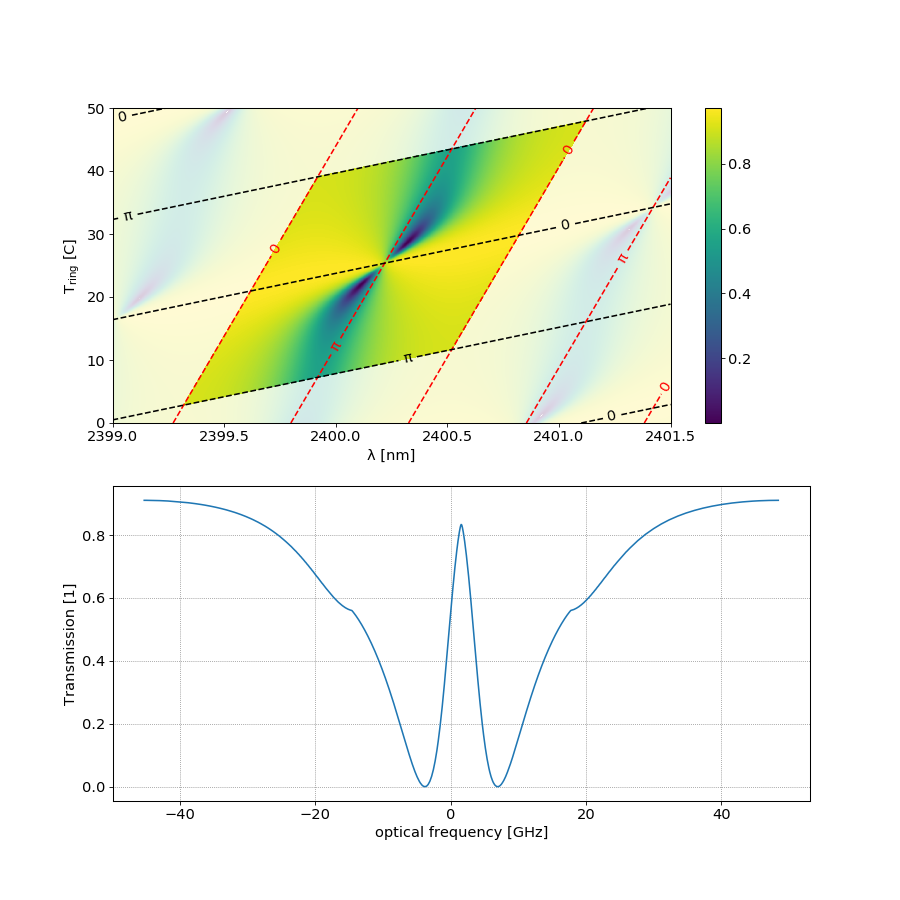

Text(0.5, 0, 'optical frequency [GHz]')

In [18]:
# model thermooptic tuning to match experiment
λ0 = 2400.25 * u.nm
δλ = 2.5 * u.nm
T0 = 25 # C
δT = 50 # C



λ_lim = λ0-δλ/2.,λ0+δλ/2.
T_lim = T0-δT/2.,T0+δT/2.

# T1 = 0.9 
# δT = 0.1
# α_db_U = 1.5/u.cm
# α_db_ring = 1.5/u.cm

ds_model = linear_res_model(λ_lim,
                            nλ=2001,
                            T_ring_min=Q_(T_lim[0],'degC'),
                            T_ring_max=Q_(T_lim[1],'degC'),
                            nT_ring=1000,
                            T_U=Q_(21,'degC'),
                            Λ=1.41*u.um,
                            L_U_straight=583*u.um,
                            d_U_curve=122.35*u.um,
                            d_ring=120*u.um,
                            δκ=0.1,
                            κ_1 = np.r_[0.8],
                            #g=400*u.nm,
                            α_db_u = 3.5/u.cm,
                            α_db_ring=1.5/u.cm,
                            include_taper_dc=False,
                            manual_to=True,
                            to_coeff=2e-4)

f = ds_model['λ'].to(u.GHz,'sp')
f_rel = f - f.mean()

# P_out = ds_model['P_out'].min(axis=1)
Φ_rt = ds_model['ϕ_rt'] - ds_model['ϕ_rt'].min() + ds_model['ϕ_rt'].min()%(2*π)
Φ_ring = ds_model['ϕ_ring'] - ds_model['ϕ_ring'].min() + ds_model['ϕ_ring'].min()%(2*π)

central_unit_cell_mask = (Φ_rt.T > 4*π) * (Φ_rt.T < 6*π) * (Φ_ring.T > 3*π) * (Φ_ring.T < 5*π)

fig,ax = plt.subplots(2,1,figsize=(12,12))
cmap = cm.viridis
alpha=0.2
light_cmap = cmap_map(lambda x: x*alpha + (1-alpha), cmap)
P_out_central = np.ma.masked_where(~central_unit_cell_mask, ds_model['P_out'].T)
P_out_outside = np.ma.masked_where(central_unit_cell_mask, ds_model['P_out'].T)
p0_bg = ax[0].pcolormesh(ds_model['λ'],ds_model['T_ring'],P_out_outside,cmap=light_cmap)
p0 = ax[0].pcolormesh(ds_model['λ'],ds_model['T_ring'],P_out_central,cmap=cmap)


#p0 = ax.pcolormesh(ds_model['T_ring'],ds_model['λ'],z_rt)
plt.colorbar(p0,ax=ax[0])
c_rt = ax[0].contour(ds_model['λ'],ds_model['T_ring'],Φ_rt.T,
              levels=[π,2*π,3*π,4*π,5*π,6*π],colors='r',linestyles='--')
c_ring = ax[0].contour(ds_model['λ'],ds_model['T_ring'],Φ_ring.T,
              levels=[π,2*π,3*π,4*π,5*π,6*π],colors='k',linestyles='--')

fmt = {}
strs = ['π','0','π','0','π','0']
for l, s in zip(c_rt.levels, strs):
    fmt[l] = s
# Label every other level using strings
ax[0].clabel(c_rt, c_rt.levels, inline=True, fmt=fmt, fontsize=14)
ax[0].clabel(c_ring, c_ring.levels, inline=True, fmt=fmt, fontsize=14)
ax[0].set_xlabel('λ [nm]')
ax[0].set_ylabel('T$_{\mathrm{ring}}$ [C]')


p1 = ax[1].plot(f_rel,P_out_central.min(axis=0))
ax[1].set_ylabel('Transmission [1]')
ax[1].set_xlabel('optical frequency [GHz]')

In [19]:
# check directional coupler field coefficient math
T1 = 0.9 # power transmission across directional coupler 1 (input side)
δT = 0.1 # fractional imbalance in ring/U directional coupler power transmission

t1 = np.sqrt(T1) #np.r_[0.2]
t2 = sqrt( T1 * ( 1 - δT ) )
r1 = 1.j*sqrt(1.-t1**2) #[newaxis,newaxis,:] # field reflection from input dir. coupler
r2 = 1.j*sqrt(1.-t2**2) #[newaxis,newaxis,:] # field reflection from output dir. coupler

x1 = np.abs(t1)**2 + np.abs(r1)**2
x2 = np.abs(t2)**2 + np.abs(r2)**2
y1 = t1*r1.conjugate() + r1*t1.conjugate()
y2 = t2*r2.conjugate() + r2*t2.conjugate()
print(f'|t1|^2 + |r1|^2: {x1:3.3f}, should be 1.0')
print(f'|t2|^2 + |r2|^2: {x2:3.3f}, should be 1.0')
print(f't1 * r1.conj + r1 * t1.conj: {y1:5.5f}, should be 0.0')
print(f't2 * r2.conj + r2 * t2.conj: {y2:5.5f}, should be 0.0')

|t1|^2 + |r1|^2: 1.000, should be 1.0
|t2|^2 + |r2|^2: 1.000, should be 1.0
t1 * r1.conj + r1 * t1.conj: 0.00000+0.00000j, should be 0.0
t2 * r2.conj + r2 * t2.conj: 0.00000+0.00000j, should be 0.0


In [20]:
# define resonance calculators that just use phase delays
def hamerly_U_resonance_fixed_ϕ_rt(α_ring, α_U, T1, δT,
                                ϕ_rt=0.,E0=1.,ϕ_ring=np.linspace(0,4*π,1000),ϕ_U=np.linspace(0,4*π,1000)):
    t1 = np.sqrt(T1) #np.r_[0.2]
    t2 = sqrt( T1 * ( 1 - δT ) ) # T2 = T1 * ( 1 - δT )
    r1 = 1.j*sqrt(1.-t1**2) #[newaxis,newaxis,:] # field reflection from input dir. coupler
    r2 = 1.j*sqrt(1.-t2**2) #[newaxis,newaxis,:] # field reflection from output dir. coupler
    # fix ϕ_rt = ϕ_U + ϕ_ring/2. = 0 (or n*π) to stay along racetrack resonance 
    ϕ_U = ϕ_rt - ϕ_ring/2.
#     ϕ_ring = 2 * ( ϕ_rt - ϕ_U )
    numerator = t1*r2*(1.-α_ring/2.)**2*exp(1.j*ϕ_ring)+t2*r1*(1.-α_U)*(1.-α_ring/2.)*exp(1.j*ϕ_rt)
    z = r1*r2*(1.-α_ring/2.)**2*exp(1.j*ϕ_ring) + t1*t2*(1.-α_U)*(1.-α_ring/2.)*exp(1.j*ϕ_rt)
    denominator = 1. - z
    E_ring_2 = numerator/denominator*E0
    E_ring_1 = (1.-α_ring/2.)*exp(1.j*ϕ_ring/2.)*(t1*E0 + r1*E_ring_2)
    E_U = r1*E0 + t1*E_ring_2
    E_out = t2*E_ring_1 + r2*(1.-α_U)*E_U*exp(1.j*ϕ_U)
    P_U = abs(E_U)**2
    P_out = abs(E_out)**2
    return P_U, P_out

def hamerly_U_resonance(α_ring, α_U, T1, δT,
                                E0=1,ϕ_ring=np.linspace(0,4*π,1000),ϕ_rt=np.linspace(0,4*π,1001)):
    t1 = np.sqrt(T1) #np.r_[0.2]
    t2 = sqrt( T1 * ( 1 - δT ) ) # T2 = T1 * ( 1 - δT )
    r1 = 1.j*sqrt(1.-t1**2) #[newaxis,newaxis,:] # field reflection from input dir. coupler
    r2 = 1.j*sqrt(1.-t2**2) #[newaxis,newaxis,:] # field reflection from output dir. coupler
    # define meshgrid with phase delay variables 
    Φ_ring, Φ_rt = np.meshgrid(ϕ_ring,ϕ_rt)
    Φ_U = Φ_rt - Φ_ring/2.
    #Φ_rt = Φ_U + Φ_ring/2. # "rt" stands for racetrack
    numerator = t1*r2*(1.-α_ring/2.)**2*exp(1.j*Φ_ring)+t2*r1*(1.-α_U)*(1.-α_ring/2.)*exp(1.j*Φ_rt)
    z = r1*r2*(1.-α_ring/2.)**2*exp(1.j*Φ_ring) + t1*t2*(1.-α_U)*(1.-α_ring/2.)*exp(1.j*Φ_rt)
    denominator = 1. - z
    E_ring_2 = numerator / denominator * E0
    E_ring_1 = (1.-α_ring/2.) * exp(1.j*Φ_ring/2.) * ( t1*E0 + r1*E_ring_2 )
    E_U = r1*E0 + t1*E_ring_2
    E_out = t2*E_ring_1 + r2*(1.-α_U)*E_U*exp(1.j*Φ_U)
    P_U = abs(E_U)**2
    P_out = abs(E_out)**2
    return P_U, P_out


#     numerator = c1*t2*(1.-alpha_half_ring)**2*exp(1.j*n_ring*L_ring*k)+c2*t1*(1.-alpha_u)*(1.-alpha_half_ring)*exp(1.j*(n_u*L_U+n_ring*L_ring/2.)*k)
#     z = t1*t2*(1.-alpha_half_ring)**2*exp(1.j*n_ring*L_ring*k) + c1*c2*(1.-alpha_u)*(1.-alpha_half_ring)*exp(1.j*(n_u*L_U+n_ring*L_ring/2.)*k)
#     denominator = 1. - z
#     E_ring_2 = numerator/denominator*E0
#     E_ring_1 = (1.-alpha_half_ring)*exp(1.j*n_ring*L_ring/2.*k)*(c1*E0 + t1*E_ring_2)
#     E_cavity = t1*E0 + c1*E_ring_2
#     E_out = c2*E_ring_1 + t2*(1.-alpha_u)*E_cavity*exp(1.j*n_u*L_U*k)
#     ϕ_rt = ((n_u*L_U+n_ring*L_ring/2.)*k).to(u.dimensionless).m
#     ϕ_ring = (n_ring*L_ring*k).to(u.dimensionless).m
#     ϕ_U = (n_u*L_U*k).to(u.dimensionless).m

α_U: 0.016
α_ring: 0.004


<IPython.core.display.Javascript object>


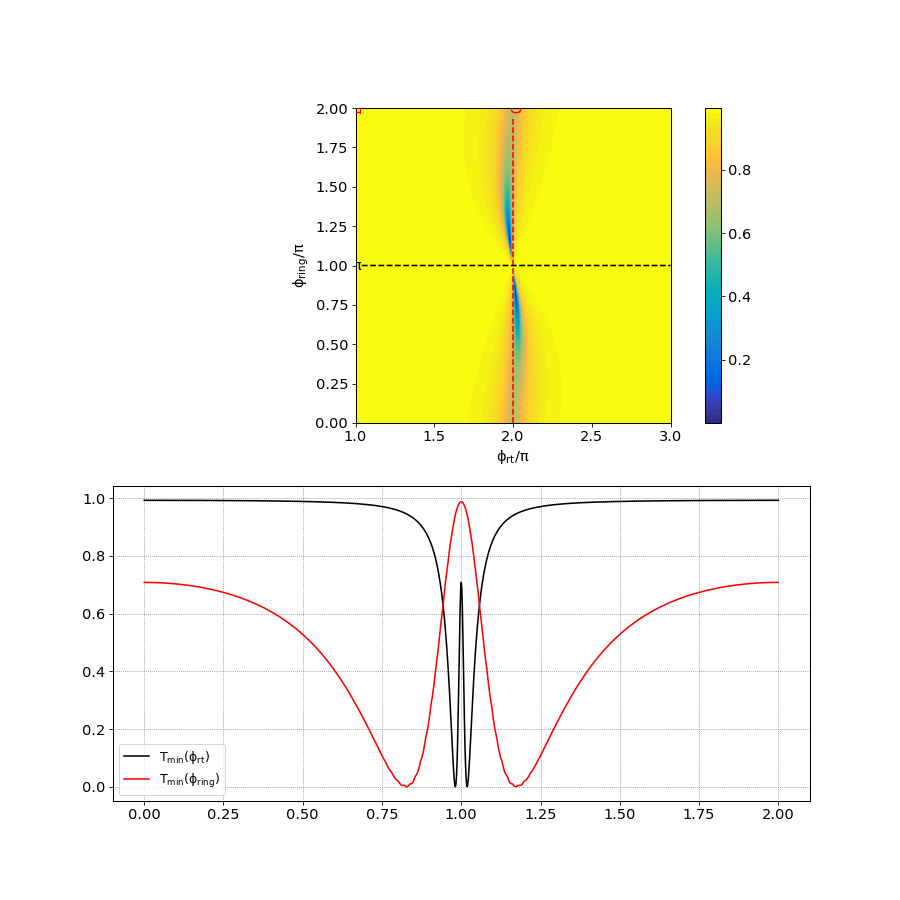

In [21]:
# plot resonance shapes as a function of phase delays
T1 = 0.9
δT = 0.005
α_db_U = 0.5/u.cm
α_db_ring = 0.5/u.cm

# use actual lengths to convert waveguide loss coefficients to power losses over certain resonator regions
L_U_straight=583*u.um
d_U_curve=122.35*u.um
d_ring=120*u.um
L_U_curve = np.pi * d_U_curve / 2.0
L_U = 2 * L_U_straight + L_U_curve
L_ring = np.pi * d_ring
α_U = dB_to_fractional_loss((L_U*α_db_U).to('dimensionless').m) 
α_ring = dB_to_fractional_loss((L_ring*α_db_ring).to('dimensionless').m) # dimensionless
printval(α_U,p=3)
printval(α_ring,p=3)
ϕ_ring = np.linspace(0,2,900)*π
ϕ_rt=np.linspace(1,3,1201)*π
#ϕ_U = ϕ_rt - ϕ_ring/2.
Φ_ring, Φ_rt = np.meshgrid(ϕ_ring,ϕ_rt)
Φ_U = Φ_rt - Φ_ring/2.
# Φ_rt = Φ_U + Φ_ring/2. # "rt" stands for racetrack

# ϕ_U = -ϕ_ring/2.
# P_U_0, P_out_0 = hamerly_U_resonance_fixed_ϕ_rt(α_ring, α_U, T1, δT, ϕ_rt=0,ϕ_U=ϕ_U,ϕ_ring=ϕ_ring)
# P_U_π, P_out_π = hamerly_U_resonance_fixed_ϕ_rt(α_ring, α_U, T1, δT, ϕ_rt=π,ϕ_U=ϕ_U,ϕ_ring=ϕ_ring)

P_U, P_out = hamerly_U_resonance(α_ring, α_U, T1, δT,ϕ_rt=ϕ_rt,ϕ_ring=ϕ_ring)


fig,ax = plt.subplots(2,1,figsize=(12,12))

p = ax[0].pcolormesh(ϕ_rt/π,ϕ_ring/π,P_out.T)
plt.colorbar(p,ax=ax[0])
ax[0].set_aspect('equal')
ax[0].set_xlabel('ϕ$_{\mathrm{rt}}$/π')
ax[0].set_ylabel('ϕ$_{\mathrm{ring}}$/π')
c_rt = ax[0].contour(ϕ_rt/π,ϕ_ring/π,Φ_rt.T,
              levels=[π,2*π,3*π,4*π,5*π,6*π,7*π,8*π,9*π],colors='r',linestyles='--')
c_ring = ax[0].contour(ϕ_rt/π,ϕ_ring/π,Φ_ring.T,
              levels=[π,2*π,3*π,4*π,5*π,6*π,7*π,8*π,9*π],colors='k',linestyles='--')
fmt = {}
strs = ['π','0','π','0','π','0','π','0','π']
for l, s in zip(c_rt.levels, strs):
    fmt[l] = s
# Label every other level using strings
ax[0].clabel(c_rt, c_rt.levels, inline=True, fmt=fmt, fontsize=14)
ax[0].clabel(c_ring, c_ring.levels, inline=True, fmt=fmt, fontsize=14)

ax[1].plot(ϕ_rt/π-1.0,P_out.min(axis=1),'k',label='T$_{\mathrm{min}}$(ϕ$_{\mathrm{rt}}$)')
ax[1].plot(ϕ_ring/π,P_out.min(axis=0),'r',label='T$_{\mathrm{min}}$(ϕ$_{\mathrm{ring}}$)')
ax[1].legend()


In [175]:
from scipy.optimize import curve_fit

λ0 = 2400.25 * u.nm
δf = 110 * u.GHz
T0 = 25 # C
δT = 50 # C

λ0 = 2400.25 * u.nm
δλ = 2.5 * u.nm
T0 = 25 # C
δT = 50 # C



λ_lim = λ0-δλ/2.,λ0+δλ/2.
T_lim = T0-δT/2.,T0+δT/2.


L_U_straight=583*u.um
d_U_curve=122.35*u.um
d_ring=120*u.um

thermooptic_coeff = 2e-4 # dn/dT [1/K]

nT = 2000

T_ring = np.linspace(T0-δT/2.,T0+δT/2.,nT)
n0 = f_neff_s_interp(T0,λ0.to(u.um).m)[0]
ng0 = 3.58 # group index near 2.4um in our waveguides from lumerical
δn_ring = (T_ring - T0) * thermooptic_coeff



f0 = λ0.to(u.GHz,'sp').m
k0 = (2*π*n0 / λ0).to(1/u.cm).m 
c = (1*u.speed_of_light).to(u.cm * u.GHz).m

L_U_curve = π * d_U_curve / 2.0
L_U = (2 * L_U_straight + L_U_curve).to(u.cm).m
L_ring = (π * d_ring).to(u.cm).m

# adjust L_U and L_ring to make ϕ_ring_0 = 0 and ϕ_rt_0 = π, centering the line wrt. swept area
ϕ_U_0 =  L_U*k0 # dimensionless
ϕ_ring_0 =  L_ring*k0 # dimensionless
δϕ_ring_0 = np.mod(ϕ_ring_0-π,2*π)
δL_ring = δϕ_ring_0/( k0)
L_ring -= δL_ring
ϕ_ring_0 =  L_ring*k0
L_ring_change = δL_ring*1e4*u.um
ϕ_ring_0_mod_2π_over_π = np.mod(ϕ_ring_0,2*π)/π
printval(L_ring_change,p=3)
printval(ϕ_ring_0_mod_2π_over_π,p=3)
ϕ_rt_0 = ϕ_U_0 + ϕ_ring_0/2.
δϕ_rt_0 = np.mod(ϕ_rt_0,2*π)
δL_U = δϕ_rt_0/( k0)
L_U -= δL_U
ϕ_U_0 =  L_U*k0
ϕ_rt_0 = ϕ_U_0 + ϕ_ring_0/2.
L_U_change = δL_U*1e4*u.um
ϕ_rt_0_mod_2π_over_π = np.mod(ϕ_rt_0,2*π)/π
printval(L_U_change,p=3)
printval(ϕ_rt_0_mod_2π_over_π,p=3)


E0 = 1.

def fit_func(X, α_ring, α_U, T1, δT):
    δf = X
    #δf,g = X # δf is in GHz, g is in nm
    k = k0 + 2*π/c * ng0 * δf # c is speed of light in cm * GHz, so k is in 1/cm
    δn_ring_mg,k_mg = np.meshgrid(δn_ring,k)
    Φ_U = L_U*k_mg # dimensionless
    Φ_ring = L_ring*k_mg*(1+δn_ring_mg) # dimensionless
    Φ_rt = Φ_U + Φ_ring/2.
    t1 = np.sqrt(T1) #np.r_[0.2]
    t2 = sqrt( T1 * ( 1 - δT ) ) # T2 = T1 * ( 1 - δT )
    r1 = 1.j*sqrt(1.-t1**2) 
    r2 = 1.j*sqrt(1.-t2**2)
    numerator = t1*r2*(1.-α_ring/2.)**2*exp(1.j*Φ_ring)+t2*r1*(1.-α_U)*(1.-α_ring/2.)*exp(1.j*Φ_rt)
    denominator = 1. - (r1*r2*(1.-α_ring/2.)**2*exp(1.j*Φ_ring) + t1*t2*(1.-α_U)*(1.-α_ring/2.)*exp(1.j*Φ_rt))
    E_ring_2 = numerator / denominator * E0
    E_ring_1 = (1.-α_ring/2.) * exp(1.j*Φ_ring/2.) * ( t1*E0 + r1*E_ring_2 )
    E_U = r1*E0 + t1*E_ring_2
    E_out = t2*E_ring_1 + r2*(1.-α_U)*E_U*exp(1.j*Φ_U)
    P_out = abs(E_out)**2
    central_unit_cell_mask = ((Φ_rt-ϕ_rt_0) > -π) * ((Φ_rt-ϕ_rt_0) < π) * ((Φ_ring-ϕ_ring_0) > -π) * ((Φ_ring-ϕ_ring_0) < π)
    P_out_central = np.ma.masked_where(~central_unit_cell_mask, P_out)
    return P_out_central.min(axis=1)
#     return P_out.T.min(axis=0)

def fit_func_2D(X, α_ring, α_U, T1, δT):
    δf = X
    #δf,g = X # δf is in GHz, g is in nm
    k = k0 + 2*π/c * ng0 * δf # c is speed of light in cm * GHz, so k is in 1/cm
    δn_ring_mg,k_mg = np.meshgrid(δn_ring,k)
    Φ_U = L_U*k_mg # dimensionless
    Φ_ring = L_ring*k_mg*(1+δn_ring_mg) # dimensionless
    Φ_rt = Φ_U + Φ_ring/2.
    t1 = np.sqrt(T1) #np.r_[0.2]
    t2 = sqrt( T1 * ( 1 - δT ) ) # T2 = T1 * ( 1 - δT )
    r1 = 1.j*sqrt(1.-t1**2) 
    r2 = 1.j*sqrt(1.-t2**2)
    numerator = t1*r2*(1.-α_ring/2.)**2*exp(1.j*Φ_ring)+t2*r1*(1.-α_U)*(1.-α_ring/2.)*exp(1.j*Φ_rt)
    denominator = 1. - (r1*r2*(1.-α_ring/2.)**2*exp(1.j*Φ_ring) + t1*t2*(1.-α_U)*(1.-α_ring/2.)*exp(1.j*Φ_rt))
    E_ring_2 = numerator / denominator * E0
    E_ring_1 = (1.-α_ring/2.) * exp(1.j*Φ_ring/2.) * ( t1*E0 + r1*E_ring_2 )
    E_U = r1*E0 + t1*E_ring_2
    E_out = t2*E_ring_1 + r2*(1.-α_U)*E_U*exp(1.j*Φ_U)
    P_out = abs(E_out)**2
    print(f'Φ_rt.min()/π: {(Φ_rt-ϕ_rt_0).min()/π:4.3f}')
    print(f'Φ_rt.max()/π: {(Φ_rt-ϕ_rt_0).max()/π:4.3f}')
    print(f'Φ_ring.min()/π: {(Φ_ring-ϕ_ring_0).min()/π:4.3f}')
    print(f'Φ_ring.max()/π: {(Φ_ring-ϕ_ring_0).max()/π:4.3f}')
    central_unit_cell_mask = ((Φ_rt-ϕ_rt_0) > -π) * ((Φ_rt-ϕ_rt_0) < π) * ((Φ_ring-ϕ_ring_0) > -π) * ((Φ_ring-ϕ_ring_0) < π)
    P_out_central = np.ma.masked_where(~central_unit_cell_mask, P_out)
    return P_out_central #.min(axis=0)
#    return P_out



# initial guesses for α_ring, α_U, T1, δT:

# T1_0 = 0.5 
# δT_0 = 0.01
# α_dB_U_0 = 1.0 # 1/u.cm
# α_dB_ring_0 = 0.6 # 1/u.cm
# α_U_0 = dB_to_fractional_loss(L_U*α_dB_U_0) 
# α_ring_0 = dB_to_fractional_loss(L_ring*α_dB_ring_0) 
# printval(α_U_0,p=3)
# printval(α_ring_0,p=3)
# p0 = α_ring_0, α_U_0, T1_0, δT_0
# out = curve_fit(fit_func, f_g400, T_min_g400, p0)
# print(out)

L_ring_change: 0.548 micrometer
φ_ring_0_mod_2π_over_π: 1.000
L_U_change: 0.771 micrometer
φ_rt_0_mod_2π_over_π: 2.000


α_U_0: 0.145
α_ring_0: 0.031


<IPython.core.display.Javascript object>


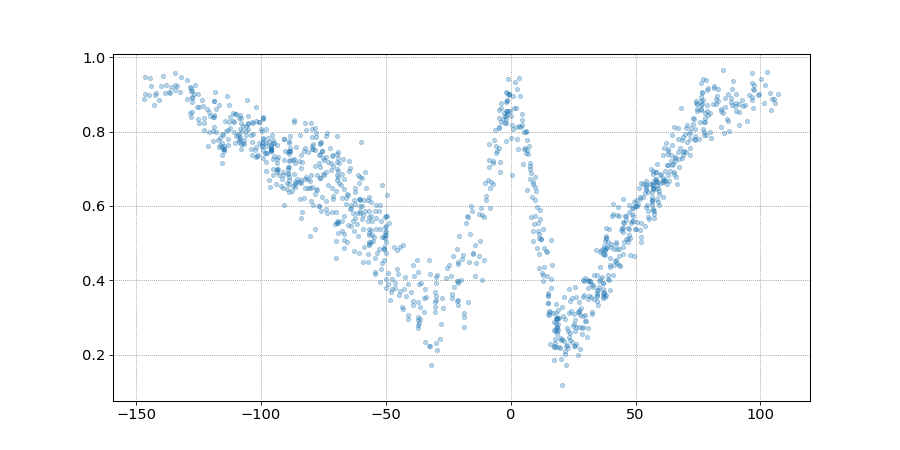

In [173]:
T1_0 = 0.3 
δT_0 = 0.01
α_dB_U_0 = 5.0 # 1/u.cm
α_dB_ring_0 = 3.6 # 1/u.cm
α_U_0 = dB_to_fractional_loss(L_U*α_dB_U_0) 
α_ring_0 = dB_to_fractional_loss(L_ring*α_dB_ring_0) 
printval(α_U_0,p=3)
printval(α_ring_0,p=3)
p0 = α_ring_0, α_U_0, T1_0, δT_0
p_opt = out[0]
f_data = f_g400 # .to(u.GHz).m
f_fit = np.linspace(f_data.min(),f_data.max(),600)
T_min_fit = fit_func(f_fit,*p0)
fig,ax = plt.subplots(1,1,figsize=(12,6))
ax.plot(f_g400,T_min_g400,'.',color='C0',alpha=0.3)
ax.plot(f_fit,T_min_fit,'--',color='C3',lw=2)

α_U_0: 0.046
α_ring_0: 0.004
Φ_rt.min()/π: -7.065
Φ_rt.max()/π: 5.610
Φ_ring.min()/π: -4.618
Φ_ring.max()/π: 4.273


<IPython.core.display.Javascript object>


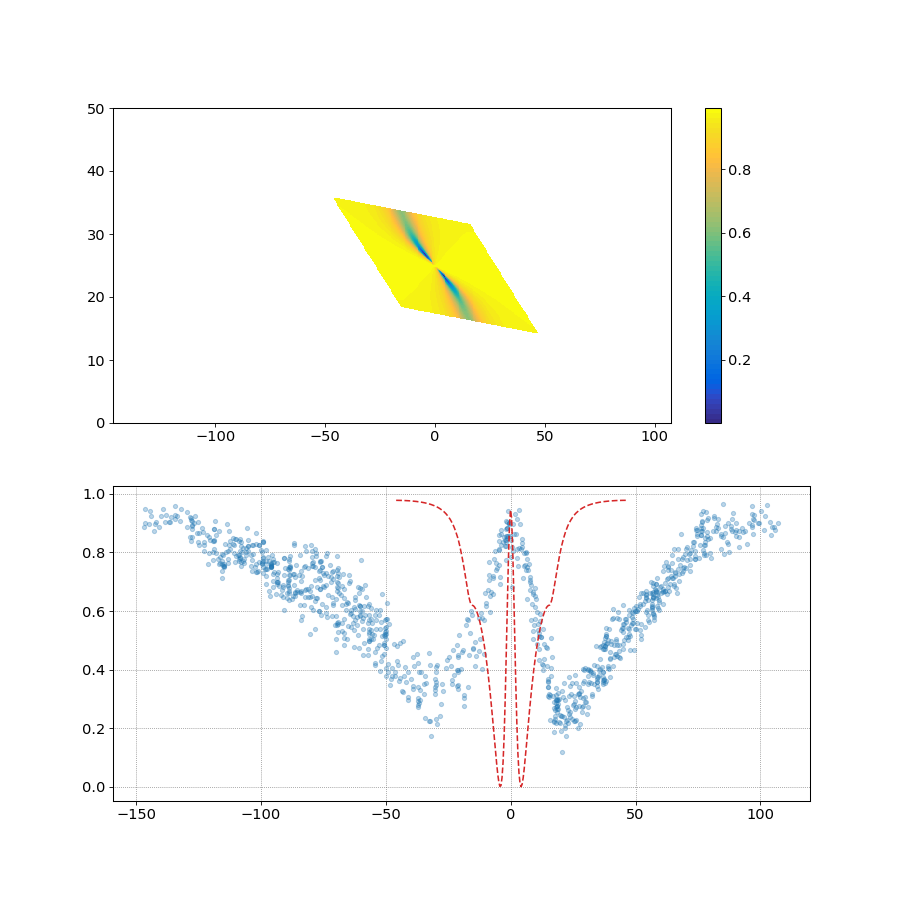

In [178]:
T1_0 = 0.8 
δT_0 = 0.01
α_dB_U_0 = 1.5 # 1/u.cm
α_dB_ring_0 = 0.5 # 1/u.cm
α_U_0 = dB_to_fractional_loss(L_U*α_dB_U_0) 
α_ring_0 = dB_to_fractional_loss(L_ring*α_dB_ring_0) 
printval(α_U_0,p=3)
printval(α_ring_0,p=3)
p0 = α_ring_0, α_U_0, T1_0, δT_0
z_fit = fit_func_2D(f_fit,*p0)

fig,ax = plt.subplots(2,1,figsize=(12,12))

pc = ax[0].pcolormesh(f_fit,T_ring,z_fit.T)
plt.colorbar(pc,ax=ax[0])
ax[1].plot(f_g400,T_min_g400,'.',color='C0',alpha=0.3)
ax[1].plot(f_fit,z_fit.min(axis=1),'--C3')

## old analysis code

<IPython.core.display.Javascript object>


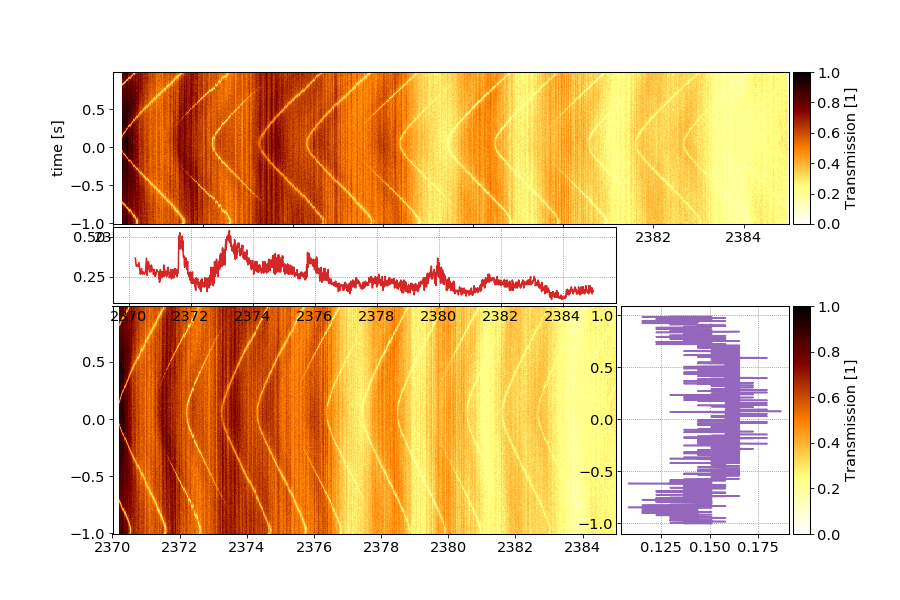

In [332]:
d = ds3_WB4_unmarked_flattened_g200_20
t = d['t']
c_full = cm.afmhot_r # cm.gist_heat_r
c_zoom = cm.bone_r
λ_lim = 2370.,2385. # x limits in nm
t_lim = d['t'].min().m,d['t'].max().m
vmax = 1
vmin = 0
recalc_model = True

#f = d['λ'].to(u.THz,'sp')
λ = d['λ'].to(u.nm)
ref = d['V_ref_24']
T = d['V_trans_24']
T = T - T.min() 
λ_mask = (λ.m<λ_lim[1])*(λ.m>λ_lim[0])
t_mask = (t.m<t_lim[1])*(t.m>t_lim[0])
ref_max = ref[t_mask,:][:,λ_mask].max()
ref_rel = ref / ref_max
T_max = T[t_mask,:][:,λ_mask].max()

λ = λ[λ_mask]
t = t[t_mask]
T = T[t_mask,:][:,λ_mask]
z_full = T.m /T.max().m
z = T.m



fig = plt.figure(figsize=(12,8))

gs = GridSpec(3,3,width_ratios=(30,10,1),height_ratios=(2,1,3),hspace=0.02,wspace=0.02)
ax_full = fig.add_subplot(gs[0,:2])
ax_zoom = fig.add_subplot(gs[2,0])
ax_zoom_t_int = fig.add_subplot(gs[1,0])
ax_zoom_λ_int = fig.add_subplot(gs[2,1])
cb_ax_full = fig.add_subplot(gs[0,2])
cb_ax_zoom = fig.add_subplot(gs[2,2])

p_full = ax_full.pcolormesh(λ,t,z_full,vmin=vmin,vmax=vmax,cmap=c_full)

λ_zoom=λ
z_zoom = z_full
z_zoom_min_t = z_zoom.min(axis=0)
z_zoom_min_λ = z_zoom.min(axis=1)
ax_zoom_t_int.plot(λ_zoom,z_zoom_min_t,'C3')
ax_zoom_λ_int.plot(z_zoom_min_λ,t,'C4')
p_zoom = ax_zoom.pcolormesh(λ_zoom,t,z_zoom,vmin=vmin,vmax=vmax,cmap=c_full)
plt.colorbar(p_zoom,label='Transmission [1]',cax=cb_ax_zoom)
ax_zoom.set_xlim(λ_lim)
ax_zoom.set_ylim(t_lim)


ax_full.set_xlim(λ_lim)
ax_full.set_ylim(t_lim)
ax_full.set_ylabel('time [s]')
ax_full.set_xlabel('λ [nm]')

#     ax2 = lm2f_twiny_offset(ax_model_T_int,offset=ax_expt.get_xlim()[1],units='GHz',w=3,p=1)
#     ax2.grid('off')
plt.colorbar(p_full,label='Transmission [1]',cax=cb_ax_full)
pts = []
λ_zoom_t_min = []
z_zoom_t_min = []


def onclick(event):
    if event.button == 1:
        pts.append([event.xdata,event.ydata])
        #print(f'x: {event.xdata:3.3f}, y: {event.ydata:3.3f}')
        ax_full.plot(event.xdata,event.ydata,'go')
        plt.draw()
    elif event.button == 3:
#         normalize_slice(z,pts,z_zoom_t_min,λ_zoom_t_min,ax_full,ax_zoom,ax_zoom_t_int,
#                         ax_zoom_λ_int,cb_ax_zoom,vmin=0,vmax=1)
        #ax_full.plot(event.xdata,event.ydata,'bo')
        u_p0 = pts[-4]
        u_p1 = pts[-3]
        m_u = (u_p1[1] - u_p0[1])/(u_p1[0] - u_p0[0])
        b_u = u_p0[1] - m_u * u_p0[0]

        l_p0 = pts[-2]
        l_p1 = pts[-1]
        m_l = (l_p1[1] - l_p0[1])/(l_p1[0] - l_p0[0])
        b_l = l_p0[1] - m_l * l_p0[0]
        λ_zoom_lim = (t_lim[0]-b_u)/m_u, (t_lim[1]-b_l)/m_l
        λ_zoom_mask = (λ.m<λ_zoom_lim[1])*(λ.m>λ_zoom_lim[0])
        λ_zoom = λ[λ_zoom_mask]
        T_zoom = T[:,λ_zoom_mask]
        z_zoom = T_zoom.m

        bg_u = m_u * λ_zoom.m + b_u
        bg_l = m_l * λ_zoom.m + b_l
#         ax_full.plot(λ_zoom,bg_u,'b--')
#         ax_full.plot(λ_zoom,bg_l,'b--')
#         plt.draw()
        # now find values at points closest to these lines
        z_norm_l = np.zeros(len(λ_zoom))
        z_norm_u = np.zeros(len(λ_zoom))
        z_norm = np.zeros(len(λ_zoom))
        tind_norm_u = np.zeros(len(λ_zoom),dtype=np.int)
        tind_norm_l = np.zeros(len(λ_zoom),dtype=np.int)
        for lind,ll in enumerate(λ_zoom):
            t_norm_u = m_u * ll.m + b_u
            t_norm_l = m_l * ll.m + b_l
            tind_norm_u[lind] = np.argmin(np.abs(t.m-t_norm_u))
            tind_norm_l[lind] = np.argmin(np.abs(t.m-t_norm_l))
            z_norm_u[lind] = T_zoom[tind_norm_u[lind],lind].m
            z_norm_l[lind] = T_zoom[tind_norm_l[lind],lind].m
            z_norm[lind] = np.max((z_norm_u[lind],z_norm_l[lind]))
            z_zoom[:,lind] = z_zoom[:,lind] / (z_norm[lind]*np.ones(len(t)))

        λ_mesh,t_mesh = np.meshgrid(λ_zoom.m,t.m)
        mask = (m_u*λ_mesh+b_u > t_mesh) * (m_l*λ_mesh+b_l < t_mesh)
        not_mask = (m_u*λ_mesh+b_u < t_mesh) + (m_l*λ_mesh+b_l > t_mesh)
        z_zoom = z_zoom*mask + np.ones(z_zoom.shape)*not_mask
        z_zoom_min_t = z_zoom.min(axis=0)
        z_zoom_min_λ = z_zoom.min(axis=1)
        
#         plt.sca(ax_zoom_t_int) #
#         plt.cla() #
        ax_zoom_t_int.clear()
        ax_zoom_t_int.plot(λ_zoom,z_zoom_min_t,'C3')
        
#         plt.sca(ax_zoom_λ_int) #
#         plt.cla() #
        ax_zoom_λ_int.clear()
        ax_zoom_λ_int.plot(z_zoom_min_λ,t,'C4')
        λ_zoom_t_min.append(λ_zoom)
        z_zoom_t_min.append(z_zoom_min_t)
        
#         plt.sca(ax_zoom) #
#         plt.cla() #
        ax_zoom.clear()
        p_zoom = ax_zoom.pcolormesh(λ_zoom,t,z_zoom,vmin=vmin,vmax=vmax,cmap=c_full)
        ax_zoom.plot(λ_zoom,bg_u,'b--')
        ax_zoom.plot(u_p0[0],u_p0[1],'go')
        ax_zoom.plot(u_p1[0],u_p1[1],'go')
        ax_zoom.plot(λ_zoom,bg_l,'b--')
        ax_zoom.plot(l_p0[0],l_p0[1],'go')
        ax_zoom.plot(l_p1[0],l_p1[1],'go')
        ax_zoom.set_xlim(λ_zoom_lim)
        ax_zoom.set_ylim(t_lim)
        
        
        plt.sca(ax_full) #
        ax_full.plot(λ_zoom,bg_u,'b--')
        ax_full.plot(λ_zoom,bg_l,'b--')
        
        #plt.colorbar(p_zoom,label='Transmission [1]',cax=cb_ax_zoom)
        plt.draw()
        fig.canvas.flush_events()
    else:
        pass # Do nothing

fig.canvas.mpl_connect('button_press_event', onclick)
fig.show()

<IPython.core.display.Javascript object>


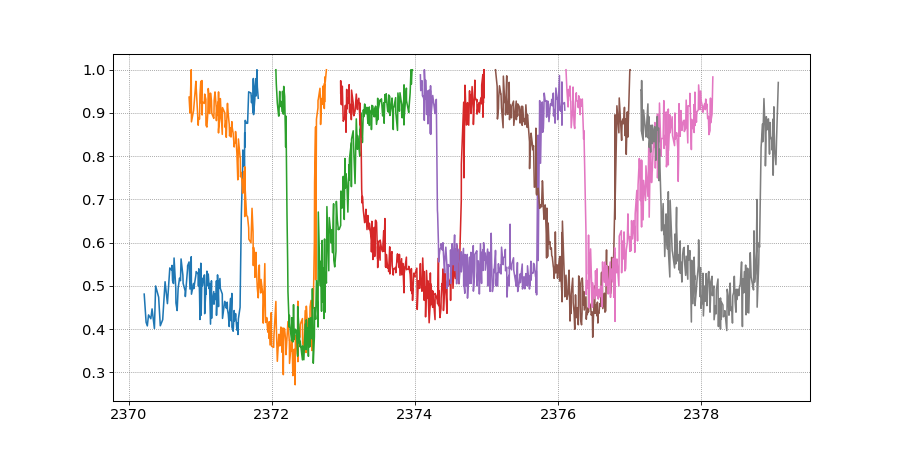

In [328]:
fig,ax = plt.subplots(1,1,figsize=(12,6))
for ind,zz in enumerate(z_zoom_t_min):
    ax.plot(λ_zoom_t_min[ind],z_zoom_t_min[ind])

# Approximate RoC of grating-to-U couplers used in IMEC V2 OPOs

<IPython.core.display.Javascript object>


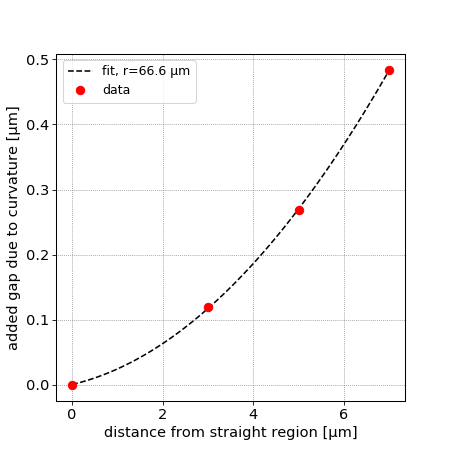

In [126]:
# Meysam just used a cubic spline. I've measured the changing distance
# from waveguide center to the edge of the U waveguide by hand to estimate the RoC for a simulation

# distance from straight region of racetrack coupler
#x = np.array([0,1,3,5,7]) * u.um
x = np.array([0,3,5,7]) * u.um
# distance from center of incoming racetrack waveguide to straight U waveguide edge
#d = np.array([0.83,0.816,0.949,1.098,1.314]) * u.um
d = np.array([0.83,0.949,1.098,1.314]) * u.um
y = d - d[0]
p = np.polyfit(x,y,2)
x_fit = np.linspace(x.min().m,x.max().m,100)
y_fit = np.polyval(p,x_fit)
fig,ax = plt.subplots(1,1,figsize=(6,6))
r_fit = 1 / (2*p[0]) * u.um
ax.plot(x_fit,y_fit,'k--',label=f'fit, r={r_fit.m:3.1f} μm')
ax.plot(x,y,'ro',label='data')
ax.set_xlabel('distance from straight region [μm]')
ax.set_ylabel('added gap due to curvature [μm]')
ax.legend()

# Calibration data from experiments

In [22]:
### 2.4um detector properties 

## Thorlabs DET10D, Extended InGaAs biased photodiode, 900-2600nm

# from datasheet
# Peak Response (λ p) 1.3 A/W
# Shunt Resistance Rsh 14 kΩ (Typ.)
# Diode Capacitance CJ 500 pF (Typ.)
# Rise Timea,b,c tr 25 ns (Typ.)
# NEP (λ p) - 1.5 x 10-12 W/√Hz (Typ.)
# Bias Voltage VR 1.8 V
# Dark Currentd ID 5 µA (Typ.)
# 40 µA (Max)
# Output Voltage VOUT 0 to 2 V 

responsivity_DET10D = 1.3 * u.ampere / u.watt
R_load_DET10D = 50 * u.ohm
V_responsivity_DET10D = (responsivity_DET10D * R_load_DET10D).to(u.volt/u.watt)
NEP_DET10D = 1.5e-12*u.watt/(u.Hz**(0.5))
#det_bw_24 = 10 * u.kHz # just used to calculate SNR given detector's NEP in W/Hz^(1/2)

## Thorlabs PDA20H, Amplified PbSe photoconductor, 1.5-4.8μm, AC couple
# Detector PbSe
# Active Area 2 x 2 mm
# Wavelength Range 1.5 μm to 4.8 μm
# Peak Wavelength (λp) 4.0 μm
# Bandwidth (-3 dB) 0.2 Hz to 10 kHz
# Rise Time (0 - 63%) 35 μs
# Voltage Gaina 50x / 100x
# Output Voltagea ±5 V / ±10 V
# NEPb 1.5 x 10-10 W/√Hz
# Detectivity, D* (at λp) 1.3 x 109
#  cm × √Hz/W
# Peak Sensitivity 3.0 x 103 V/W (Typ.)
# 1.5 x 103 V/W (Min.) 


V_responsivity_PDA20H = 0.6 * 3e3 * u.volt/u.watt # at 2.4um, ~70% of peak
NEP_PDA20H = 1.5e-10*u.watt/(u.Hz**(0.5))


# Thorlabs PDA10D2, Extended InGaAs amplified photodiode, 900-2600nm

# Detector - InGaAs
# Active Area - Ø1.0 mm (0.8 mm2)
# Wavelength Range λ 900 to 2600 nm
# Peak Wavelength λ p 2300 nm (Typ.)
# Peak Response ( λ p) 1.35 A/W (Typ.)
# Small Signal Bandwidth - 25 MHz
# NEP (λ p) W/√Hz 1.01 x 10-11
# Noise (RMS) - 2.5 mVrms
# Max Ouput Current IOUT 100 mA
# Dark Offset - ±75 mV (Typ.), ±375 mV (Max)
# Load Impedance - 50 Ω to Hi-Z
# Transimpedance Gain 
#  V/A (50 Ω) 5 x 10^3
#  V/A (Hi-Z) 1 x 10^4
# Output Voltage VOUT
# 0 to 5 V (50 Ω)
# 0 to 10 V (Hi-Z)

responsivity_PDA10D2 = 1.3 * u.ampere / u.watt # near 2.4μm
tia_gain_PDA10D2 = 1e4 * u.volt / u.ampere
V_responsivity_PDA10D2 = (responsivity_PDA10D2 * tia_gain_PDA10D2).to(u.volt/u.watt)
NEP_PDA10D2 = 1e-11*u.watt/(u.Hz**(0.5))
bandwidth_PDA10D2 = 25 * u.MHz # 


# 1.2 μm detector properties

# # 1.2um detector properties (Thorlabs PDA10CF)
# responsivity_12 = 0.76 * u.ampere / u.watt
# tia_gain_12 = 1e4 * u.volt / u.ampere
# NEP_12 = 1.2e-11*u.watt/(u.Hz**(0.5)) # this is the NEP at peak responsivity = 1.04A/W @ 1.5um, should adjust
# det_bw_12 = 1 * u.Hz # just used to calculate SNR given detector's NEP in W/Hz^(1/2)

# # 1.2um detector properties (Thorlabs PDA10CS at 60dB gain setting)
# responsivity_12 = 0.83 * u.ampere / u.watt
# tia_gain_12 = 1.5e6 * u.volt / u.ampere
# NEP_12 = 1.5e-12*u.watt/(u.Hz**(0.5)) # this is the NEP at peak responsivity = 1.04A/W @ 1.5um, should adjust
# det_bw_12 = 3e3 * u.Hz # just used to calculate SNR given detector's NEP in W/Hz^(1/2)


#### 1.2um detector properties

## New Focus 2011 "candybar" at G=1e4 gain setting
responsivity_NF2011_12 = 0.8 * u.ampere / u.watt
tia_gain_NF2011_12 = 1.5e7 * u.volt / u.ampere
NEP_NF2011_12 = 2e-13*u.watt/(u.Hz**(0.5)) # this is the NEP at peak responsivity = 1.04A/W @ 1.5um, should adjust
det_bw_NF2011_12 = 3e3 * u.Hz # just used to calculate SNR given detector's NEP in W/Hz^(1/2)

printval(V_responsivity_DET10D)

## Thorlabs DET08C 80μm InGaAs detector

# wavelength range: 800 - 1700 nm
# Material: InGaAs
# Active Area: Ø80 µm
# Bandwidth (-3 dB): 5 GHz
# Input: Flat, AR-Coated Window
# Minimum Resistor Load: 50 Ω
# Maximum Peak Power	18 mW	100 mW
# Output Voltage: 2 V (Max)
# Rise Time (tr):70 ps @ 1538 nm, 20%/80% (Typ.)
# Fall Time (tf): 250 ps @ 1538 nm, 80%/20% (Typ.)
# Bias Voltage: 12 V
# Dark Current: 1.5 nA
# NEP (Maximum): 2e-15 W/√Hz (@ 1550 nm)
# Junction Capacitance: 0.3 pF

responsivity_DET08C_12 = 0.8 * u.ampere / u.watt
NEP_DET08C_12 = 2e-15 * u.watt / np.sqrt(1*u.Hz)


V_responsivity_DET10D: 65.0 volt / watt


η_iso: 0.813
η_fiber: 0.157
T_DM_24: 1.000
P_beam_sample_24: 476.923 microwatt
power_ratio_beam_sample_24: 0.0177
P_T_bs_trans_24: 1.222 milliwatt
power_ratio_bs_trans_24: 0.123
P_T_chip_24: 0.954 microwatt
P_input_chip_24: 5.3 milliwatt
P_output_chip_24: 13.8 microwatt
η_chip_24: 0.0026
η_gc_24_floor: 0.051
η_gc_24_input_estimate: 0.093
η_pm2000_mean: 0.372
max η_pm2000: 0.389
min η_pm2000: 0.338
P_trans_12: 56.2 microwatt


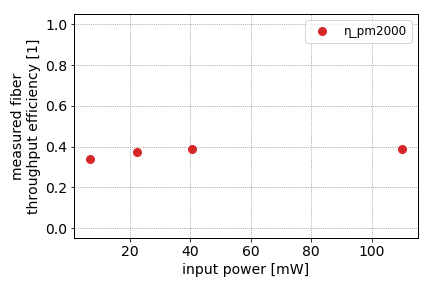

In [23]:
##### Measurements to document coupling efficiencies
%matplotlib inline
#### Oct 28 2018

### Thermal power meter measurements at several points along the optical path

## Uncoated CaF2 optic transmission@2.4μm ~ 89% (from Thorlabs UC CaF2 lens page)
T_CaF2_24 = 0.89

# 45 degree reflectance of gold and silver mirrors at 1.2 and 2.4μm
R_gold_45deg_24 = 0.98
R_gold_45deg_12 = 0.97
R_silver_45deg_24 = 0.98
R_silver_45deg_12 = 0.97

# D-coated CaF2 transmission
T_D_CaF2_24 = 0.988

# D-coated BD2 transmission
T_D_BD2_24 = 0.988

# Mitutoyo 20x NIR objective transmission near 2.4μm
T_Mitutoyo_20x_24 = 0.3

# Mitutoyo 20x NIR objective transmission near 1.2μm
T_Mitutoyo_20x_12 = 0.5


## Thorlabs BSW23 microscope "50/50" IR fused silica beamsplitter 
T_BSW23_24_S = 0.32
T_BSW23_24_P = 0.65
R_BSW23_24_S = 0.67
R_BSW23_24_P = 0.35
T_BSW23_12_S = 0.28
T_BSW23_12_P = 0.65
R_BSW23_12_S = 0.70
R_BSW23_12_P = 0.35

# simulated 2.4μm grating coupler efficiency (from Shahryar)
η_gc_24_sim = 0.3

## Thorlabs I2300C4, MIR 2.3μm isolator
# Type: Adjustable Narrowband
# Center Wavelength: 2.3 µm
# Tuning Range	2.25 - 2.35 µm
# Operating Range	2.20 - 2.40 µm
# Transmissiona	85%
# Isolationa	35 dB (Min)
# Performance Graph
# (Click for Details)	Click for Details
# Max Beam Diameterb	3.6 mm
# Max Powerc	1.2 W
# Max Power Densityd	10 W/cm2 (CW, Blocking)
# 25 W/cm2 (CW, Transmission)

P_pre_iso_pre_tele = 428*u.mW # power before telescope with 2 UC CaF2 lenses and MIR isolator
P_pre_iso_post_tele = 373*u.mW # power after telescope with 2 UC CaF2 lenses andb before MIR isolator
P_post_iso = 256*u.mW # power after MIR isolator and 1x D-coated CaF2 lens <==not sure about this one since it seems sensitive to focusing 
P_post_iso_post_tele = 228*u.mW # power after MIR isolator and telescope with 1x D-coated CaF2 lens and 1x uncoated CaF2 lens
P_post_fiber = 27 * u.mW # power after 2m PM2000 fiber, 2x D-coated BD2 aspheres, 5x D-coated CaF2 lenses, 1x 2μm HWP, 1x UC CaF2 wedge beam sampler
P_post_bs = 9.9 * u.mW # power after dichroic mirror (LayerTec 103080, high transmission near 2.4μm) and BS023

η_iso = (P_post_iso/P_pre_iso_post_tele / T_CaF2_24 / T_D_CaF2_24 / R_gold_45deg_24 / R_gold_45deg_24 ).to(u.dimensionless).m
η_fiber =( P_post_fiber / P_post_iso_post_tele / T_CaF2_24 / T_D_CaF2_24**5 / T_D_BD2_24**2 / R_gold_45deg_24**4).to(u.dimensionless).m
T_DM_24 = 1.0 # this came out >1... ( P_post_bs / P_post_fiber / R_gold_45deg_24 / T_BSW23_24_S).to(u.dimensionless).m # measured Layertec 103080 transmission near 2.4μm

printval(η_iso,p=3)
printval(η_fiber,p=3)
printval(T_DM_24,p=3)

# InGaAs DET10D + 50Ω load monitoring 2.4μm transmission via CaF2 wedge beam sampler on microscope after fiber coupler, strong attenuation
V_beam_sample_24 = 31*u.mV # measured 2.4um transmitted power through microscope beamsplitter, strong attenuation 
P_beam_sample_24 = (V_beam_sample_24 / (responsivity_DET10D * 50. * u.ohm)).to(u.uW)
power_ratio_beam_sample_24 = (P_beam_sample_24 / P_post_fiber).to(u.dimensionless).m

# PbSe detector monitoring 2.4μm transmission through microscope beamsplitter
V_T_bs_trans_24 = 2.2*u.V # measured 2.4um transmitted power through microscope beamsplitter, strong attenuation
P_T_bs_trans_24 = (V_T_bs_trans_24 / V_responsivity_PDA20H).to(u.mW)
power_ratio_bs_trans_24 = (P_T_bs_trans_24 / P_post_bs).to(u.dimensionless).m

# measured 2.4μm power transmitted through chip
# measured with PDA10D2 after BSW23 transmission, 2x UC CaF2 lens, 3x D-CaF2 lens, Layertec 103080 Dichro, spatial filter, measured near (2382nm)
V_T_chip_24 = 21*u.mV - 8.6*u.mV # remove background that is present when I move the chip to misalign from grating
P_T_chip_24 = (V_T_chip_24 / V_responsivity_PDA10D2).to(u.uW)

# estimates of power delivered to and through chip
P_input_chip_24 = P_post_fiber * R_BSW23_24_S * R_gold_45deg_24 * T_Mitutoyo_20x_24
P_output_chip_24 = ( P_T_chip_24 / T_Mitutoyo_20x_24 / T_BSW23_24_S / R_gold_45deg_24**3 / T_CaF2_24**2 / T_D_CaF2_24**3 / T_DM_24 )
η_chip_24 = (P_output_chip_24 / P_input_chip_24).to(u.dimensionless).m
η_gc_24_floor = np.sqrt(η_chip_24)
η_gc_24_input_estimate = np.sqrt(η_chip_24/η_gc_24_sim) 

printval(P_beam_sample_24,p=3)
printval(power_ratio_beam_sample_24,form='g',p=3)
printval(P_T_bs_trans_24,p=3)
printval(power_ratio_bs_trans_24,form='g',p=3)
printval(P_T_chip_24,p=3)
printval(P_input_chip_24)
printval(P_output_chip_24)
printval(η_chip_24,form='g',p=2)
printval(η_gc_24_floor,form='g',p=2)
printval(η_gc_24_input_estimate,form='g',p=2)


######### Post fiber-realignment #########

##### Note: HWP after isolator, before fiber couple:
### 225 deg <====> Horizontal/'P' polarization
### 270/71 deg <====> Vertical/'S' polarization

## optimized efficiency with PM2000 FC/APC with adjustable AR-asphere fiber couple (beam looks nice on PyroCam)
η_pm2000_max = 2.5/6.5
η_pm2000_min = 2.1/6.5

# printval(η_pm2000_min,p=3)
# printval(η_pm2000_max,p=3)


#### Oct 28 2018

## optimized efficiency with PM2000 FC/APC with adjustable AR-asphere fiber couple (beam looks nice on PyroCam)
P_fiber_in = np.array([6.8,22.4,40.5,110.0])*u.mW
P_fiber_out = np.array([2.3,8.4,15.65,42.8])*u.mW
η_pm2000 = (P_fiber_out/P_fiber_in).to(u.dimensionless).m
η_pm2000_mean = η_pm2000.mean()
fig,ax = plt.subplots(1,1)
ax.plot(P_fiber_in,η_pm2000,'C3o',label='η_pm2000')
ax.set_xlabel('input power [mW]')
ax.set_ylabel('measured fiber\nthroughput efficiency [1]')
ax.set_ylim([-0.05,1.05])
ax.legend()
fig.tight_layout()

printval(η_pm2000_mean,p=3)
printspan(η_pm2000,p=3)

# air transmission
lm_air = np.array([2382.33])*u.nm
P_air_0m = np.array([43]) * u.mW
P_air_1m = np.array([43]) * u.mW


#### Nov 2, 2018 

# measured 1.2μm power transmitted through device with DET08C
TIA_gain = 1*u.volt/(100*u.microampere) # SR570
V_P_trans_12 = 450 *u.mV
P_trans_12 = (V_P_trans_12 / TIA_gain / responsivity_DET08C_12).to(u.uW)
printval(P_trans_12)

In [24]:
# estimate 2.4um power in the device based on detected transmitted signal amplitude
# also conservatively estimate peak SHG power expected

# 2.4um detector properties (Thorlabs PDA10D2)
responsivity_24 = 1.3 * u.ampere / u.watt
tia_gain_24 = 1e4 * u.volt / u.ampere
NEP_24 = 1e-11*u.watt/(u.Hz**(0.5))
det_bw_24 = 10 * u.kHz # just used to calculate SNR given detector's NEP in W/Hz^(1/2)

# # 1.2um detector properties (Thorlabs PDA10CF)
# responsivity_12 = 0.76 * u.ampere / u.watt
# tia_gain_12 = 1e4 * u.volt / u.ampere
# NEP_12 = 1.2e-11*u.watt/(u.Hz**(0.5)) # this is the NEP at peak responsivity = 1.04A/W @ 1.5um, should adjust
# det_bw_12 = 1 * u.Hz # just used to calculate SNR given detector's NEP in W/Hz^(1/2)

# # 1.2um detector properties (Thorlabs PDA10CS at 60dB gain setting)
# responsivity_12 = 0.83 * u.ampere / u.watt
# tia_gain_12 = 1.5e6 * u.volt / u.ampere
# NEP_12 = 1.5e-12*u.watt/(u.Hz**(0.5)) # this is the NEP at peak responsivity = 1.04A/W @ 1.5um, should adjust
# det_bw_12 = 3e3 * u.Hz # just used to calculate SNR given detector's NEP in W/Hz^(1/2)


# 1.2um detector properties (New Focus 2011 "candybar" at G=1e4 gain setting)
responsivity_12 = 0.8 * u.ampere / u.watt
tia_gain_12 = 1.5e7 * u.volt / u.ampere
NEP_12 = 2e-13*u.watt/(u.Hz**(0.5)) # this is the NEP at peak responsivity = 1.04A/W @ 1.5um, should adjust
det_bw_12 = 3e3 * u.Hz # just used to calculate SNR given detector's NEP in W/Hz^(1/2)


# signal properties
V_det_24 = 60*u.mV #30*u.mV

# peak SHG efficiency eta_SHG=P_SHG/P_wg**2, (for now taken from Timurdogan Watts paper, also using ~1mm device) 
eta_SHG = 0.12/u.watt

# 2.4um path losses
T_bs_24 = 0.5 # beamsplitter transmission
T_obj_24 = 0.3 # objective transmission
T_gc_24 = 0.3 # 2.4um grating coupler efficiency

# 1.2um path losses
T_bs_12 = 0.5 # beamsplitter transmission
T_obj_12 = 0.5 # objective transmission
T_gc_12 = 0.5 # 1.2um grating coupler efficiency

#  power calculations
P_det_24 = (V_det_24 / tia_gain_24 / responsivity_24).to(u.uW)
SNR_24 = (P_det_24 / (NEP_24 * det_bw_24**(0.5))).to(u.dimensionless).m
P_gc_24 = P_det_24 / T_bs_24 / T_obj_24
P_wg_24 = P_gc_24 / T_gc_24
P_wg_12 = (P_wg_24**2 * eta_SHG).to(u.W)
P_gc_12 = P_wg_12 * T_gc_12
P_det_12 = P_gc_12 * T_bs_12 * T_obj_12
V_det_12 = (P_det_12 * responsivity_12 * tia_gain_12).to(u.V)
SNR_12 = (P_det_12 / (NEP_12 * det_bw_12**(0.5))).to(u.dimensionless).m

# syntax: printval(x,w=4,p=1,form='f')

printval(V_det_24)
printval(SNR_24)
printval(P_det_24)
printval(P_gc_24)
printval(P_wg_24)
printval(P_det_12,form='g')
printval(P_gc_12,form='g')
printval(P_wg_12,form='g')
printval(V_det_12,form='g')
printval(SNR_12)

V_det_24: 60.0 millivolt
SNR_24: 4615.4
P_det_24: 4.6 microwatt
P_gc_24: 30.8 microwatt
P_wg_24: 102.6 microwatt
P_det_12: 2e-10 watt
P_gc_12: 6e-10 watt
P_wg_12: 1e-09 watt
V_det_12: 0.002 volt
SNR_12: 14.4


In [36]:
# 2.4 μm power calculations, Nov 20 2018
V_out = 100 * u.mV
η_fc = 0.33
P_in_fc = 0.9 * u.watt
P_in_chip = (P_in_fc * η_fc * R_BSW23_24_S * R_gold_45deg_24 * T_Mitutoyo_20x_24).to(u.mW)
P_out_det = (V_out/V_responsivity_PDA10D2).to(u.uW)
P_out_chip = ( P_out_det / T_Mitutoyo_20x_24 / T_BSW23_24_S / R_gold_45deg_24**3 / T_CaF2_24**2 / T_D_CaF2_24**3 / T_DM_24 ).to(u.uW)
η_chip = (P_out_chip / P_in_chip).to(u.dimensionless).m
η_gc_24_max = 0.3
η_gc_24_min = np.sqrt(η_chip)

# P_U_min = P_out_chip / η_gc_24_max
# P_U_max = P_out_chip.to(u.mW) / η_gc_24_min
η_input_est = (η_chip / η_gc_24_max) # case where output coupling to detector is ~30% efficient, so input is 0.6%
P_U_min = P_in_chip * η_input_est 
P_U_max = P_in_chip.to(u.mW) * η_gc_24_min


printval(η_input_est,p=4)
printval(P_in_chip,p=3)
printval(P_out_det,p=3)
printval(P_out_chip,p=3)
printval(η_chip,p=4)
printval(η_input_est,p=4)
printval(η_gc_24_min,p=4)
printval(η_gc_24_max,p=4)
printval(P_U_min,p=3)
printval(P_U_max,p=2)


# "V" value lost, output for original run of this code in experiment notebook

# P_in_chip: 58.503 milliwatt
# P_out_chip: 111.444 microwatt
# η_chip: 0.0019
# η_gc_24_min: 0.0436
# η_gc_24_max: 0.3000
# P_U_min: 371.5 microwatt
# P_U_max: 2.6 milliwatt

# it turns out 'V' should just be V_out, now fixed

η_input_est: 0.0063
P_in_chip: 58.503 milliwatt
P_out_det: 7.692 microwatt
P_out_chip: 111.444 microwatt
η_chip: 0.0019
η_input_est: 0.0063
η_gc_24_min: 0.0436
η_gc_24_max: 0.3000
P_U_min: 0.371 milliwatt
P_U_max: 2.55 milliwatt


In [26]:
# 1.2 μm power calculations, Nov 20 2018
# V_out = 150 * u.mV
# g_tia = 1 * u.volt / u.mA
# η_fc = 0.55
# P_in_fc = 50.0 * u.milliwatt
# P_in_us = P_in_fc * η_fc 
# P_in_obj_meas = 13.8 * u.mW
# P_in_obj_theory = P_in_us * R_BSW23_12_S * R_gold_45deg_12**2 
# P_in_chip = (P_in_obj_meas * T_Mitutoyo_20x_12).to(u.mW)
# P_out_det = (V_out/g_tia/responsivity_DET08C_12).to(u.uW)
# P_out_chip = ( P_out_det / T_Mitutoyo_20x_12 / T_BSW23_12_S / R_gold_45deg_12**2).to(u.uW)
# η_chip = (P_out_chip / P_in_chip).to(u.dimensionless).m
# η_gc_12_max = 0.5
# η_gc_12_min = np.sqrt(η_chip)
# P_U_min = P_out_chip.to(u.mW) / η_gc_12_max
# P_U_max = P_out_chip.to(u.mW) / η_gc_12_min


# 1.2 μm power calculations, Dec 15 2018
V_out = 25 * u.mV
g_tia = 1 * u.volt / u.mA

P_in_fc = 8.8 * u.milliwatt
P_in_us = 6.6*u.milliwatt
η_fc = (P_in_us / P_in_fc).to(u.dimensionless).m
P_in_obj_meas = 4.05 * u.mW
P_in_obj_theory = P_in_us * R_BSW23_12_S * R_gold_45deg_12**2 
P_in_chip = (P_in_obj_meas * T_Mitutoyo_20x_12).to(u.mW)
P_out_det = (V_out/g_tia/responsivity_DET08C_12).to(u.uW)
P_out_chip = ( P_out_det / T_Mitutoyo_20x_12 / T_BSW23_12_S / R_gold_45deg_12**2).to(u.uW)
η_chip = (P_out_chip / P_in_chip).to(u.dimensionless).m
η_gc_12_max = 0.5
η_gc_12_min = np.sqrt(η_chip)
P_U_min = P_out_chip.to(u.mW) / η_gc_12_max
P_U_max = P_out_chip.to(u.mW) / η_gc_12_min

printval(P_in_chip,p=3)
printval(P_out_chip,p=3)
printval(η_fc,p=3)
printval(η_chip,p=4)
printval(η_gc_12_min,p=4)
printval(η_gc_12_max,p=4)
printval(P_U_min)
printval(P_U_max)

P_in_chip: 2.025 milliwatt
P_out_chip: 237.235 microwatt
η_fc: 0.750
η_chip: 0.1172
η_gc_12_min: 0.3423
η_gc_12_max: 0.5000
P_U_min: 0.5 milliwatt
P_U_max: 0.7 milliwatt


# Comparison of $\chi^{\mathrm (2)}$ from Timurdogan/Watts paper with our data

In [49]:
# numbers from Timurdogan/Watts paper
P_ω = 25.0 * u.mW # reported SHG pump power (called signal here) on chip
P_2ω_dBm = -12.5 # max on chip SHG power reported in fig 3 of published timurdogan paper, in dBm
P_2ω = (1 * u.mW * 10**(P_2ω_dBm/10.0)).to(u.uW)
printval(P_2ω)
η_SHG_calc = (P_2ω / P_ω**2).to(1/u.watt)
printval(η_SHG_calc,p=3)
η_SHG_rep = 0.12 / u.watt # reported P_2ω / (P_ω)**2, so for fixed L_qpm = 0.5mm
Vrb = 21.*u.volt
λ_ω = 2.29 * u.um
λ_2ω = λ_ω / 2.
n_2ω = 3.043
n_ω = 2.245
A = 0.0915*u.um**2
α_2ω = 0.2/u.cm
α_ω = 3.6/u.cm
L_qpm = 0.5 * u.mm
L_tot = 1.0 * u.mm
c = 1 * u.speed_of_light
eps0 = 1 * u.electric_constant
Z0 = 1 * u.impedance_of_free_space

def η_SHG_watts(χ2=41*u.pm/u.volt,Δk=0.0/u.cm):
    η_0 = 8 * χ2**2 * L_qpm**2  / ( eps0 * n_ω**2 * n_2ω * c * λ_ω**2 * A )
    loss_factor_0 = np.exp(-1*(2*α_ω + α_2ω) * L_tot / 2. )
    loss_factor_1_num = np.sin(Δk*L_qpm / 2.)**2 + np.sinh((2*α_ω - α_2ω)*L_tot/4.)**2
    loss_factor_1_denom = (Δk*L_qpm / 2.)**2 + ((2*α_ω - α_2ω)*L_tot/4.)**2
    loss_factor_1 = loss_factor_1_num / loss_factor_1_denom
    return (η_0  * loss_factor_0 * loss_factor_1).to(1/u.watt)

def η_SHG_watts_lossless(χ2=41*u.pm/u.volt,Δk=0.0/u.cm):
    η_0 = 8 * χ2**2 * L_qpm**2  / ( eps0 * n_ω**2 * n_2ω * c * λ_ω**2 * A )
    return (η_0).to(1/u.watt)

def η_SHG_watts_corrected(χ2=82*u.pm/u.volt,Δk=0.0/u.cm):
    η_0 = 2 * χ2**2 * L_qpm**2  / ( eps0 * n_ω**2 * n_2ω * c * λ_ω**2 * A )
    loss_factor_0 = np.exp(-1*(2*α_ω + α_2ω) * L_tot / 2. )
    loss_factor_1_num = np.sin(Δk*L_qpm / 2.)**2 + np.sinh((2*α_ω - α_2ω)*L_tot/4.)**2
    loss_factor_1_denom = (Δk*L_qpm / 2.)**2 + ((2*α_ω - α_2ω)*L_tot/4.)**2
    loss_factor_1 = loss_factor_1_num / loss_factor_1_denom
    return (η_0  * loss_factor_0 * loss_factor_1).to(1/u.watt)


η_SHG_full_calc = η_SHG_watts()
η_SHG_full_calc_lossless = η_SHG_watts_lossless()
η_SHG_full_calc_corrected = η_SHG_watts_corrected()
η_SHG_norm = (η_SHG_rep / L_qpm**2 / Vrb**2).to(1/u.watt/u.mm**2/u.volt**2)
printval(η_SHG_full_calc,p=3)
printval(η_SHG_full_calc_lossless,p=3)
printval(η_SHG_full_calc_corrected,p=3)
printval(η_SHG_norm,p=5)
# this matches what they report, which is problematic because published their formula for η_0 includes
# a χ^(2) that is not properly reduced to account for *one-way* periodic poling (1/π rather than 2/π)

χ2_bulk_watts_corrected = 82*u.pm/u.volt
χ2_eff_oneway_watts_corrected = χ2_bulk_watts_corrected / np.pi
printval(χ2_eff_oneway_watts_corrected,p=2)

P_2ω: 56.2 microwatt
η_SHG_calc: 0.090 / watt
η_SHG_full_calc: 0.120 / watt
η_SHG_full_calc_lossless: 0.172 / watt
η_SHG_full_calc_corrected: 0.120 / watt
η_SHG_norm: 0.00109 / millimeter ** 2 / volt ** 2 / watt
χ2_eff_oneway_watts_corrected: 26.10 picometer / volt


In [70]:
### calculate χ2 from our data ###

# Powers
P_ω_in_chip = 60 * u.mW # I believe this is accurate for 2.38-2.4um range with the setup version used for SHG data
P_2ω_out_det = 3*u.nW
η_in_chip_min = 0.0063 # from Nov 20, 2018 calibration data 
η_in_chip_max = 0.0436 # from Nov 20, 2018 calibration data 
res_enhancement = 1.
P_ω_wg_min = P_ω_in_chip * η_in_chip_min * res_enhancement
P_ω_wg_max = P_ω_in_chip * η_in_chip_max * res_enhancement
printval(P_ω_wg_min,p=3)
printval(P_ω_wg_max,p=3)
P_2ω_out_chip = ( P_2ω_out_det / T_Mitutoyo_20x_12 / T_BSW23_12_S / R_gold_45deg_12**2).to(u.uW)
η_2ω_gc_out_min = 0.3423 # from Nov 20, 2018 calibration data 
η_2ω_gc_out_max = 0.3423 # from Nov 20, 2018 calibration data 
P_2ω_wg_min = P_2ω_out_chip.to(u.nanowatt) / η_2ω_gc_out_max
P_2ω_wg_max = P_2ω_out_chip.to(u.nanowatt) / η_2ω_gc_out_min
printval(P_2ω_wg_min,p=3)
printval(P_2ω_wg_max,p=3)

# Lengths
L_U_straight=583*u.um
d_U_curve=122.35*u.um
d_ring=120*u.um
L_QPM_gap = 73.15*u.um # length of unpoled waveguide on each straight leg of U (between poling and ring)
L_U_curve = np.pi * d_U_curve / 2.0
L_U = 2 * L_U_straight + L_U_curve
L_ring = np.pi * d_ring
L_QPM = (L_U - 2 * L_QPM_gap).to(u.mm)

printval(L_QPM,p=3)

# Efficiencies
Vrb = 8.5 * u.volt
η_SHG_max = (P_2ω_wg_max / P_ω_wg_min**2 / L_QPM**2).to(1/u.watt/u.mm**2)
η_SHG_min = (P_2ω_wg_min / P_ω_wg_max**2 / L_QPM**2).to(1/u.watt/u.mm**2)
η_SHG_norm_max = (P_2ω_wg_max / P_ω_wg_min**2 / Vrb**2 / L_QPM**2).to(1/u.watt/u.volt**2/u.mm**2)
η_SHG_norm_min = (P_2ω_wg_min / P_ω_wg_max**2 / Vrb**2 / L_QPM**2).to(1/u.watt/u.volt**2/u.mm**2)


# χ2 calculation
n_2ω = 2.96
n_ω = 2.12
A_eff_2ω = 0.14 * u.um**2
A_eff_ω = 0.23 * u.um**2
A_eff = 0.0915*u.um**2 
λ_ω = 2.381*u.um
π = np.pi
χ2_eff_min = np.sqrt( ( n_2ω * n_ω**2 * λ_ω**2 * A_eff) / ( 2 * π**2 * Z0 ) * η_SHG_min ).to(u.pm/u.volt)
χ2_eff_max = np.sqrt( ( n_2ω * n_ω**2 * λ_ω**2 * A_eff) / ( 2 * π**2 * Z0 ) * η_SHG_max ).to(u.pm/u.volt)

# loss calculation
L_round_trip = (L_U + L_ring/2.0).to(u.mm)
printval(L_round_trip,p=3)
ng_2ω = 3.95
ng_ω = 3.58
FSR = (c / L_round_trip / ng_ω).to(u.GHz)
linewidth = 1.0*u.GHz
finesse = (FSR/linewidth).to(u.dimensionless).m
round_trip_loss = 2 * π / finesse
α_ω_calc = -(1 * np.log(1 - round_trip_loss) / L_QPM).to(1/u.cm)


printval(η_SHG_min,p=3,form='g')
printval(η_SHG_max,p=3,form='g')
printval(η_SHG_norm_min,p=3,form='g')
printval(η_SHG_norm_max,p=3,form='g')
printval(χ2_eff_min,p=3,form='g')
printval(χ2_eff_max,p=3,form='g')
printval(L_round_trip,p=3)
printval(FSR,p=3)
printval(finesse)
printval(round_trip_loss,p=4)
printval(α_ω_calc,p=3)

P_ω_wg_min: 0.378 milliwatt
P_ω_wg_max: 2.616 milliwatt
P_2ω_wg_min: 66.534 nanowatt
P_2ω_wg_max: 66.534 nanowatt
L_QPM: 1.212 millimeter
L_round_trip: 1.547 millimeter
η_SHG_min: 0.00662 / millimeter ** 2 / watt
η_SHG_max: 0.317 / millimeter ** 2 / watt
η_SHG_norm_min: 9.16e-05 / millimeter ** 2 / volt ** 2 / watt
η_SHG_norm_max: 0.00439 / millimeter ** 2 / volt ** 2 / watt
χ2_eff_min: 2.48 picometer / volt
χ2_eff_max: 17.2 picometer / volt
L_round_trip: 1.547 millimeter
FSR: 54.142 gigahertz
finesse: 54.1
round_trip_loss: 0.1160
α_ω_calc: 1.018 / centimeter


In [54]:
printval?